In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
import pandas as pd
import pickle
import yaml
from pathlib import Path

import bacco
import baccoemu

import sys
sys.path.append('/dipc/kstoreyf/muchisimocks/scripts')
import data_loader
import plotter
import plot_utils
import utils
import generate_params as genp

%load_ext autoreload
%autoreload 2

2025-07-02 07:45:25.858327: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-02 07:45:25.958199: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-02 07:45:25.958240: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-02 07:45:25.970920: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-02 07:45:26.000861: I tensorflow/core/platform/cpu_feature_guar

In [2]:
%matplotlib inline
mpl.pyplot.style.use('default')
mpl.pyplot.close('all')

font, rcnew = plot_utils.matplotlib_default_config()
mpl.rc('font', **font)
mpl.pyplot.rcParams.update(rcnew)
mpl.pyplot.style.use('tableau-colorblind10')
%config InlineBackend.figure_format = 'retina'

mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

### Fixed-parameter set to estimate covariance:

In [3]:
data_mode = 'muchisimocks'
statistics = ['pk']

tag_params_cv = '_quijote_p0_n1000'
tag_biasparams_cv = '_b1000_p0_n1'
tag_datagen = ''
kwargs_data = {
    'tag_datagen': tag_datagen
}

tag_stats = f'_{"_".join(statistics)}'    
tag_data = '_'+data_mode + tag_stats + tag_params_cv + tag_biasparams_cv + tag_datagen

In [4]:
k_cv, y_cv, y_err_cv, idxs_params, params_df_cv, param_dict_fixed_cv, biasparams_df_cv, biasparams_dict_fixed_cv, random_ints_cosmo_cv, random_ints_bias_cv = \
            data_loader.load_data(data_mode, statistics, 
                                    tag_params_cv, tag_biasparams_cv,
                                    tag_data=tag_data,
                                    kwargs=kwargs_data)
k_cv, y_cv, y_err_cv = k_cv[0], y_cv[0], y_err_cv[0]

Loading muchisimocks data
Found 1000 diff cosmo pks in /scratch/kstoreyf/muchisimocks/data/pks_mlib/pks_quijote_p0_n1000_b1000_p0_n1
Loaded pk data with shape (1000, 30)
fn_mask: ../data/masks/mask_muchisimocks_pk_quijote_p0_n1000_b1000_p0_n1.txt
Loading from ../data/masks/mask_muchisimocks_pk_quijote_p0_n1000_b1000_p0_n1.txt (already exists)
Masked 1 out of 30 bins


In [5]:
# this should align with y_cv
param_names_cv = data_loader.get_param_names(tag_params=tag_params_cv, tag_biasparams=tag_biasparams_cv)

In [6]:
params_dict_cv = param_dict_fixed_cv.copy()
params_dict_cv.update(biasparams_dict_fixed_cv)
print(params_dict_cv)

{'omega_cold': 0.3175, 'sigma8_cold': 0.834, 'hubble': 0.6711, 'omega_baryon': 0.049, 'ns': 0.9624, 'neutrino_mass': 0.0, 'w0': -1.0, 'wa': 0.0, 'b1': 1, 'b2': 0, 'bs2': 0, 'bl': 0}


In [7]:
cov_fid = np.cov(y_cv, rowvar=False)
print(cov_fid.shape)

(29, 29)


In [8]:
theta_fid = [params_dict_cv[param] for param in utils.param_names_all_ordered]

## Load in fisher muchisimocks set - cosmo only

In [9]:
data_mode = 'muchisimocks'
statistics = ['pk']

tag_params = '_fisher_quijote'
tag_biasparams = '_b1000_p0_n1'
tag_datagen = ''
kwargs_data = {
    'tag_datagen': tag_datagen
}

tag_stats = f'_{"_".join(statistics)}'    
tag_data = '_'+data_mode + tag_stats + tag_params + tag_biasparams + tag_datagen

In [10]:
k, y, y_err, idxs_params, params_df, param_dict_fixed, biasparams_df, biasparams_dict_fixed, random_ints_cosmo, random_ints_bias = \
            data_loader.load_data(data_mode, statistics, 
                                    tag_params, tag_biasparams,
                                    tag_data=tag_data,
                                    kwargs=kwargs_data)
k, y, y_err = k[0], y[0], y_err[0]
print(y.shape)
print(k.shape)

Loading muchisimocks data
Found 21 diff cosmo pnns in /scratch/kstoreyf/muchisimocks/data/pnns_mlib/pnns_fisher_quijote
Loaded pk data with shape (21, 30)
fn_mask: ../data/masks/mask_muchisimocks_pk_fisher_quijote_b1000_p0_n1.txt
Loading from ../data/masks/mask_muchisimocks_pk_fisher_quijote_b1000_p0_n1.txt (already exists)
Masked 1 out of 30 bins
(21, 29)
(29,)


### Compute derivatives

In [11]:
def compute_derivatives_from_fisherset(params_df, pk_array, param_names,
                                       n_deltas_for_diff=1):
    """
    Compute derivatives of the power spectra using finite differences from the _fisher_quijote set.
    Assumes params_df has columns 'changed_param' and 'n_delta', and pk_array is aligned row-wise.
    Uses n_delta = n_deltas_for_diff and n_delta = -n_deltas_for_diff for each parameter.

    Returns:
        derivatives: dict of {param_name: derivative array (same shape as pk)}
    """
    derivatives = {}
    for param in param_names:
        # Find indices for n_delta = n_deltas_for_dif and n_delta = -n_deltas_for_diff for this parameter
        idx_plus = params_df[(params_df['param_shifted'] == param) & (params_df['n_deltas'] == n_deltas_for_diff)].index
        idx_minus = params_df[(params_df['param_shifted'] == param) & (params_df['n_deltas'] == -n_deltas_for_diff)].index
        if len(idx_plus) == 0 or len(idx_minus) == 0:
            raise ValueError(f"Missing n_delta=2 or n_delta=-2 for parameter {param}")
        pk_plus = pk_array[idx_plus[0]]
        pk_minus = pk_array[idx_minus[0]]
        delta_tot = params_df.loc[idx_plus[0], param] - params_df.loc[idx_minus[0], param]
        derivatives[param] = (pk_plus - pk_minus) / delta_tot
    return derivatives

In [12]:
derivatives_shift_nd1 = compute_derivatives_from_fisherset(params_df, y, 
                        utils.cosmo_param_names_ordered, n_deltas_for_diff=1)

In [13]:
derivatives_shift_nd2 = compute_derivatives_from_fisherset(params_df, y, 
                        utils.cosmo_param_names_ordered, n_deltas_for_diff=2)

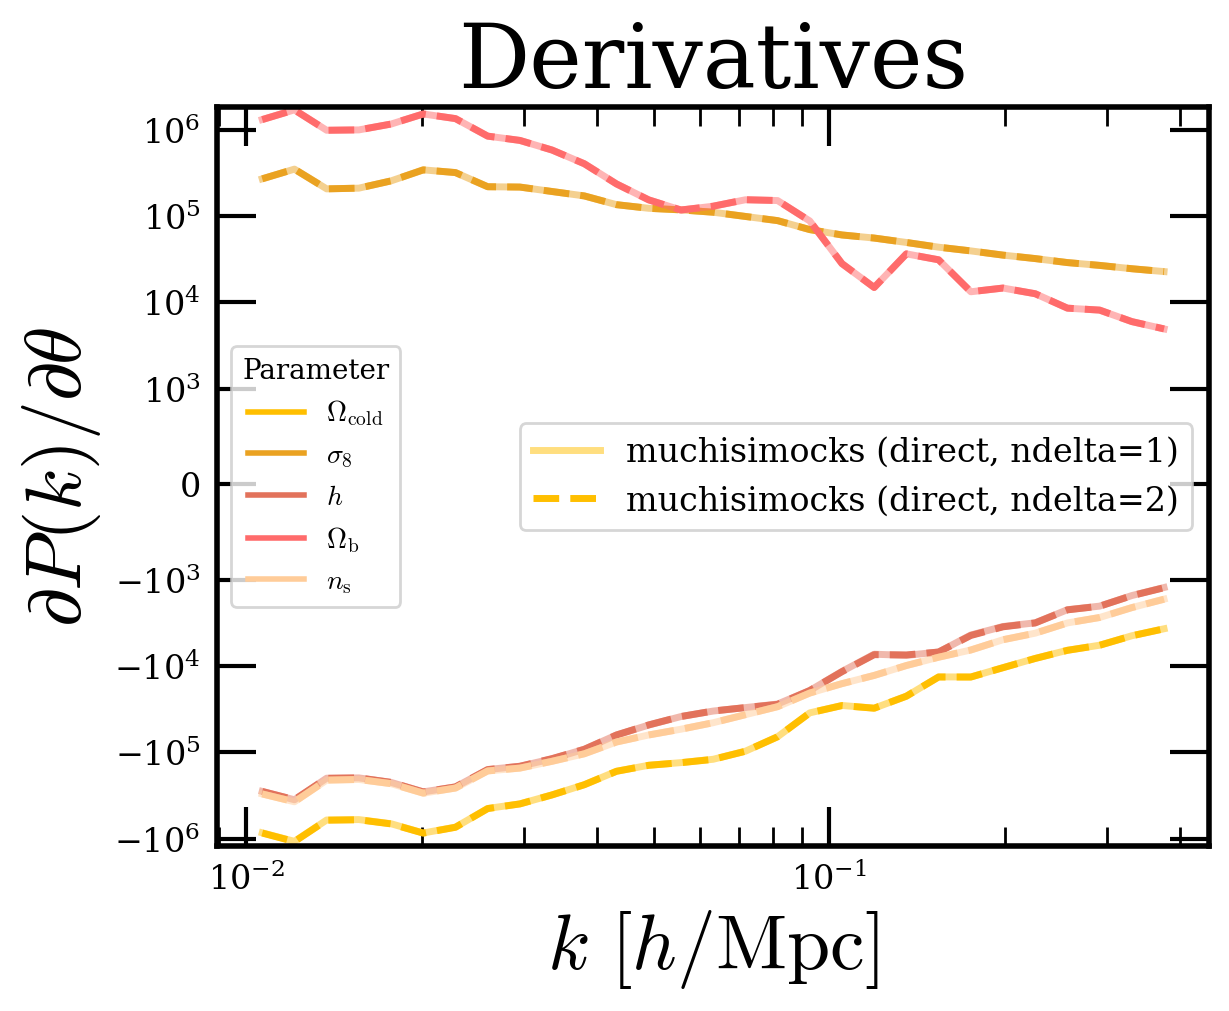

In [14]:
colors_params = ["#FFBF00", "#EAA221", "#E2725B", "#FF6B6B", "#FFCC99", "#9CAF88", "#008080", "#4682B4", "#CCCCFF"]

param_names_show = utils.cosmo_param_names_ordered
for i, param_name in enumerate(param_names_show):
#for i, param_name in enumerate(param_names):
    if i==0:
        label_muchisimocks = 'muchisimocks (direct, ndelta=1)'
        label_muchisimocks2 = 'muchisimocks (direct, ndelta=2)'
    else:
        label_muchisimocks = None
        label_muchisimocks2 = None

    plt.plot(k, derivatives_shift_nd1[param_name], label=label_muchisimocks, color=colors_params[i], alpha=0.5)
    plt.plot(k, derivatives_shift_nd2[param_name], label=label_muchisimocks2, color=colors_params[i], ls='--')
    # plt.plot(k_emu, derivatives_emu[param_name], label=label_emuPk, ls='--', lw=1, color=colors_params[i])
    # plt.plot(k_emu, derivatives_emu_shift[param_name], label=label_emuPk_shift, ls=':', color=colors_params[i])
#plt.plot(k_emu, np.sqrt(np.diag(cov_fid_emu)), label='cov_fid_emu', color='red')


# First legend: dataset types
legend1 = plt.legend(fontsize=12, loc='best')
plt.gca().add_artist(legend1)

# Second legend: parameter colors
from matplotlib.lines import Line2D
param_legend_handles = [Line2D([0], [0], color=colors_params[i], lw=2, label=utils.param_label_dict[param_names_show[i]]) for i in range(len(param_names_show))]
plt.legend(handles=param_legend_handles, title='Parameter', loc='best', fontsize=10)

plt.title(f'Derivatives')
plt.xlabel(r'$k\ [h/\mathrm{Mpc}]$')
plt.ylabel(r'$\partial P(k) / \partial \theta$')
plt.xscale('log')
plt.yscale('symlog', linthresh=1e3)

### Compute fisher matrices

In [15]:
fisher_matrix_shift_nd1 = utils.compute_fisher_matrix(derivatives_shift_nd1, cov_fid, param_names_show)
cov_fisher_shift_nd1 = np.linalg.inv(fisher_matrix_shift_nd1)
print("Fisher matrix shape:", fisher_matrix_shift_nd1.shape)

Fisher matrix shape: (5, 5)


In [16]:
fisher_matrix_shift_nd2 = utils.compute_fisher_matrix(derivatives_shift_nd2, cov_fid, param_names_show)
cov_fisher_shift_nd2 = np.linalg.inv(fisher_matrix_shift_nd2)
print("Fisher matrix shape:", fisher_matrix_shift_nd2.shape)

Fisher matrix shape: (5, 5)


In [17]:
n_samples = 10000
samples_shift_nd1 = np.random.multivariate_normal(theta_fid[:len(param_names_show)], cov_fisher_shift_nd1, size=n_samples)

In [18]:
n_samples = 10000
samples_shift_nd2 = np.random.multivariate_normal(theta_fid[:len(param_names_show)], cov_fisher_shift_nd2, size=n_samples)

In [19]:
params_dict = params_df.iloc[0].to_dict()
params_dict.pop('param_shifted')
params_dict.pop('n_deltas')
#params_dict_cv.update(biasparams_dict_fixed_cv)
#print(params_dict_cv)

0

In [20]:
# get bounds
_, dict_bounds_cosmo, _ = genp.define_LH_cosmo('_p5_n10000')
_, dict_bounds_bias, _ = genp.define_LH_bias('_biaszen_p4_n10000')
extents = {**dict_bounds_cosmo, **dict_bounds_bias}
print(extents)

{'omega_cold': [0.23, 0.4], 'omega_baryon': [0.04, 0.06], 'sigma8_cold': [0.65, 0.9], 'ns': [0.92, 1.01], 'hubble': [0.6, 0.8], 'neutrino_mass': [0.0, 0.4], 'w0': [-1.15, -0.85], 'wa': [-0.3, 0.3], 'b1': [-1.0, 2.0], 'b2': [-2.0, 2.0], 'bs2': [-2.0, 2.0], 'bl': [-10.0, 10.0]}


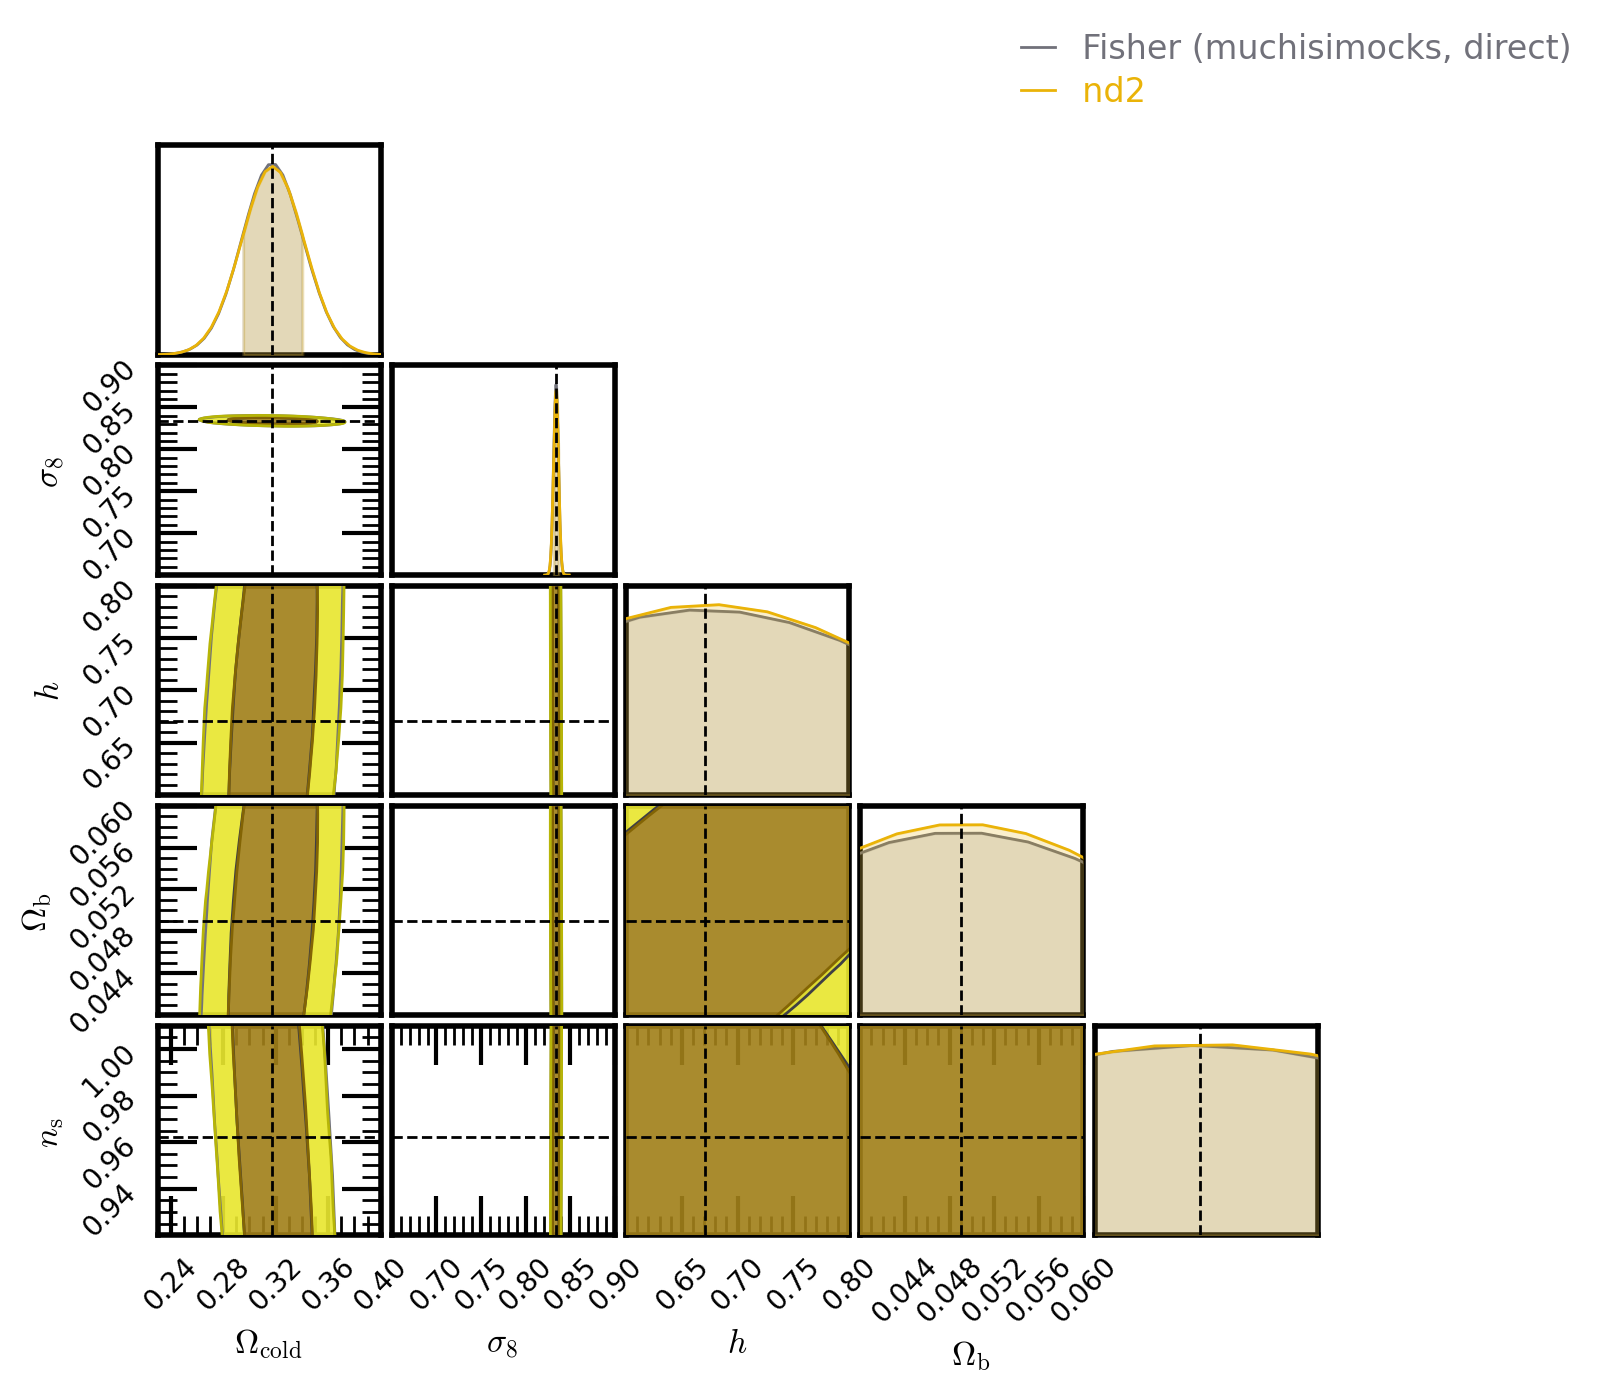

In [21]:

samples_arr = [samples_shift_nd1, samples_shift_nd2]
labels = ['Fisher (muchisimocks, direct)', 'nd2']
colors = ['gray', 'yellow']
smooth_arr = [2]*len(samples_arr)
bins_arr = [10]*len(samples_arr)
plotter.plot_contours(samples_arr, labels, colors, param_names_show, 
                      utils.param_label_dict, 
                  smooth_arr=smooth_arr, bins_arr=bins_arr,
                  truth_loc=params_dict_cv, title=None, extents=extents, 
                  figsize=(7,7), fn_save=None)

## Fisher set now with free bias params

In [22]:
data_mode = 'muchisimocks'
statistics = ['pk']

tag_params = '_fisher_quijote'
tag_biasparams_biaszen = '_fisher_biaszen'
tag_datagen = ''
kwargs_data = {
    'tag_datagen': tag_datagen
}

tag_stats = f'_{"_".join(statistics)}'    
tag_data_biaszen = '_'+data_mode + tag_stats + tag_params + tag_biasparams_biaszen + tag_datagen

In [23]:
k_biaszen, y_biaszen, y_err_biaszen, idxs_params_biaszen, params_df_biaszen, param_dict_fixed_biaszen, biasparams_df_biaszen, biasparams_dict_fixed_biaszen, random_ints_cosmo_biaszen, random_ints_bias_biaszen = \
            data_loader.load_data(data_mode, statistics, 
                                    tag_params, tag_biasparams_biaszen,
                                    tag_data=tag_data_biaszen,
                                    kwargs=kwargs_data)
k_biaszen, y_biaszen, y_err_biaszen = k_biaszen[0], y_biaszen[0], y_err_biaszen[0]
print(k_biaszen.shape)
print(y_biaszen.shape)

Loading muchisimocks data
Found 21 diff cosmo pnns in /scratch/kstoreyf/muchisimocks/data/pnns_mlib/pnns_fisher_quijote
Loaded pk data with shape (37, 30)
fn_mask: ../data/masks/mask_muchisimocks_pk_fisher_quijote_fisher_biaszen.txt
Loading from ../data/masks/mask_muchisimocks_pk_fisher_quijote_fisher_biaszen.txt (already exists)
Masked 1 out of 30 bins
(29,)
(37, 29)


In [24]:
def combine_fisher_param_dfs(params_df, biasparams_df):
    """
    Combine cosmological and bias parameter DataFrames for Fisher analysis.
    For every non-fiducial row in params_df, combine with fiducial biasparams_df.
    For every non-fiducial row in biasparams_df, combine with fiducial params_df.
    The fiducial row is where 'param_shifted' == 'fiducial'.
    Adds columns 'idx_cosmo', 'idx_bias', 'param_shifted', and 'n_deltas' for the original indices and meta info.
    Returns a DataFrame where each row is the fiducial with only one parameter varied.
    """
    # Identify fiducial rows
    fiducial_params_row = params_df[params_df['param_shifted'] == 'fiducial'].iloc[0]
    fiducial_bias_row = biasparams_df[biasparams_df['param_shifted'] == 'fiducial'].iloc[0]

    # Get parameter names (excluding meta columns)
    param_cols = [c for c in params_df.columns if c not in ['param_shifted', 'n_deltas']]
    bias_cols = [c for c in biasparams_df.columns if c not in ['param_shifted', 'n_deltas']]

    # Start with the all-fiducial row
    rows = []
    fiducial_row = {**fiducial_params_row[param_cols].to_dict(), **fiducial_bias_row[bias_cols].to_dict()}
    fiducial_row['idx_cosmo'] = fiducial_params_row.name
    fiducial_row['idx_bias'] = fiducial_bias_row.name
    fiducial_row['param_shifted'] = 'fiducial'
    fiducial_row['n_deltas'] = 0
    rows.append(fiducial_row.copy())

    # For every non-fiducial row in params_df, combine with fiducial biasparams
    for idx, row in params_df[params_df['param_shifted'] != 'fiducial'].iterrows():
        combined = {**row[param_cols].to_dict(), **fiducial_bias_row[bias_cols].to_dict()}
        combined['idx_cosmo'] = idx
        combined['idx_bias'] = fiducial_bias_row.name
        combined['param_shifted'] = row['param_shifted']
        combined['n_deltas'] = row['n_deltas']
        rows.append(combined)

    # For every non-fiducial row in biasparams_df, combine with fiducial params
    for idx, row in biasparams_df[biasparams_df['param_shifted'] != 'fiducial'].iterrows():
        combined = {**fiducial_params_row[param_cols].to_dict(), **row[bias_cols].to_dict()}
        combined['idx_cosmo'] = fiducial_params_row.name
        combined['idx_bias'] = idx
        combined['param_shifted'] = row['param_shifted']
        combined['n_deltas'] = row['n_deltas']
        rows.append(combined)

    all_param_names = param_cols + bias_cols + ['idx_cosmo', 'idx_bias', 'param_shifted', 'n_deltas']
    combined_df = pd.DataFrame(rows, columns=all_param_names)
    return combined_df

In [25]:
params_all_df = combine_fisher_param_dfs(params_df_biaszen, biasparams_df_biaszen)
print(len(params_df_biaszen), len(biasparams_df_biaszen), len(params_all_df))

21 17 37


In [26]:
## need to ensure that the ys are aligned with the params

# Convert both to 2D integer arrays
idxs_params_biaszen = np.array(idxs_params_biaszen)
idxs_params_ordered = params_all_df[['idx_cosmo', 'idx_bias']].values

# Find the matching indices for each ordered pair
matching_indices = [np.where((idxs_params_biaszen == row).all(axis=1))[0][0] for row in idxs_params_ordered]
y_biaszen_ordered = y_biaszen[matching_indices]
print(y_biaszen_ordered.shape)

(37, 29)


### Compute derivs

In [27]:
derivatives_shift_biaszen_nd1 = compute_derivatives_from_fisherset(params_all_df, y_biaszen_ordered, 
                        utils.param_names_all_ordered, n_deltas_for_diff=1)

In [28]:
derivatives_shift_biaszen_nd2 = compute_derivatives_from_fisherset(params_all_df, y_biaszen_ordered, 
                        utils.param_names_all_ordered, n_deltas_for_diff=2)

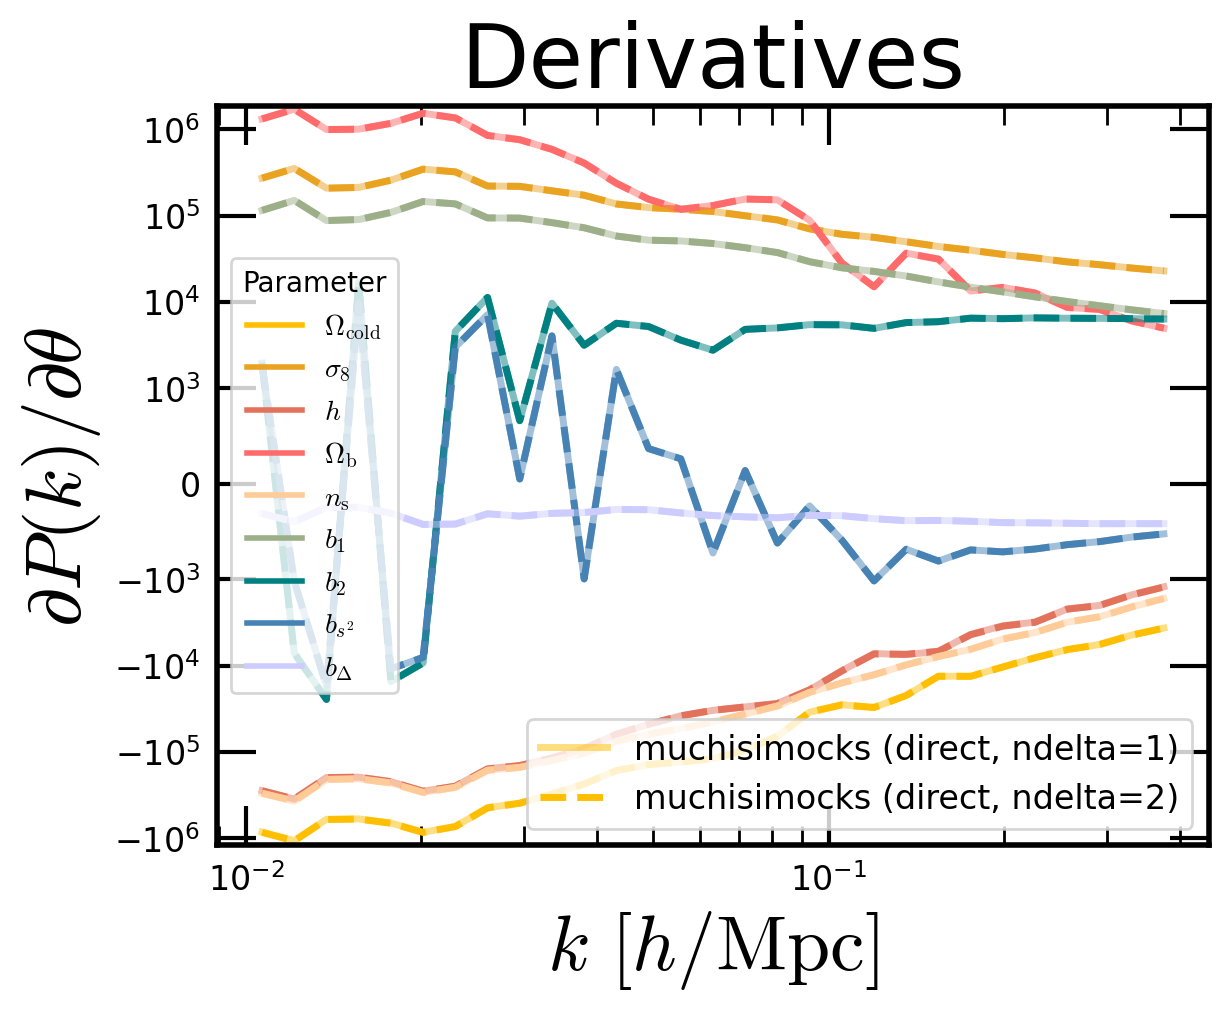

In [29]:
colors_params = ["#FFBF00", "#EAA221", "#E2725B", "#FF6B6B", "#FFCC99", "#9CAF88", "#008080", "#4682B4", "#CCCCFF"]

param_names_show = utils.param_names_all_ordered
for i, param_name in enumerate(param_names_show):
#for i, param_name in enumerate(param_names):
    if i==0:
        label_muchisimocks = 'muchisimocks (direct, ndelta=1)'
        label_muchisimocks2 = 'muchisimocks (direct, ndelta=2)'
    else:
        label_muchisimocks = None
        label_muchisimocks2 = None

    plt.plot(k_biaszen, derivatives_shift_biaszen_nd1[param_name], label=label_muchisimocks, color=colors_params[i], alpha=0.5)
    plt.plot(k_biaszen, derivatives_shift_biaszen_nd2[param_name], label=label_muchisimocks2, color=colors_params[i], ls='--')
    # plt.plot(k_emu, derivatives_emu[param_name], label=label_emuPk, ls='--', lw=1, color=colors_params[i])
    # plt.plot(k_emu, derivatives_emu_shift[param_name], label=label_emuPk_shift, ls=':', color=colors_params[i])
#plt.plot(k_emu, np.sqrt(np.diag(cov_fid_emu)), label='cov_fid_emu', color='red')


# First legend: dataset types
legend1 = plt.legend(fontsize=12, loc='best')
plt.gca().add_artist(legend1)

# Second legend: parameter colors
from matplotlib.lines import Line2D
param_legend_handles = [Line2D([0], [0], color=colors_params[i], lw=2, label=utils.param_label_dict[param_names_show[i]]) for i in range(len(param_names_show))]
plt.legend(handles=param_legend_handles, title='Parameter', loc='best', fontsize=10)

plt.title(f'Derivatives')
plt.xlabel(r'$k\ [h/\mathrm{Mpc}]$')
plt.ylabel(r'$\partial P(k) / \partial \theta$')
plt.xscale('log')
plt.yscale('symlog', linthresh=1e3)

### Compute fisher matrices

In [30]:
fisher_matrix_shift_biaszen_nd1 = utils.compute_fisher_matrix(derivatives_shift_biaszen_nd1, cov_fid, utils.param_names_all_ordered)
cov_fisher_shift_biaszen_nd1 = np.linalg.inv(fisher_matrix_shift_biaszen_nd1)
print("Fisher matrix shape:", fisher_matrix_shift_biaszen_nd1.shape)

Fisher matrix shape: (9, 9)


In [31]:
fisher_matrix_shift_biaszen_nd2 = utils.compute_fisher_matrix(derivatives_shift_biaszen_nd2, cov_fid, utils.param_names_all_ordered)
cov_fisher_shift_biaszen_nd2 = np.linalg.inv(fisher_matrix_shift_biaszen_nd2)
print("Fisher matrix shape:", fisher_matrix_shift_biaszen_nd2.shape)

Fisher matrix shape: (9, 9)


In [32]:
n_samples = 10000
samples_shift_biaszen_nd1 = np.random.multivariate_normal(theta_fid[:len(utils.param_names_all_ordered)], cov_fisher_shift_biaszen_nd1, size=n_samples)

In [33]:
n_samples = 10000
samples_shift_biaszen_nd2 = np.random.multivariate_normal(theta_fid[:len(utils.param_names_all_ordered)], cov_fisher_shift_biaszen_nd2, size=n_samples)

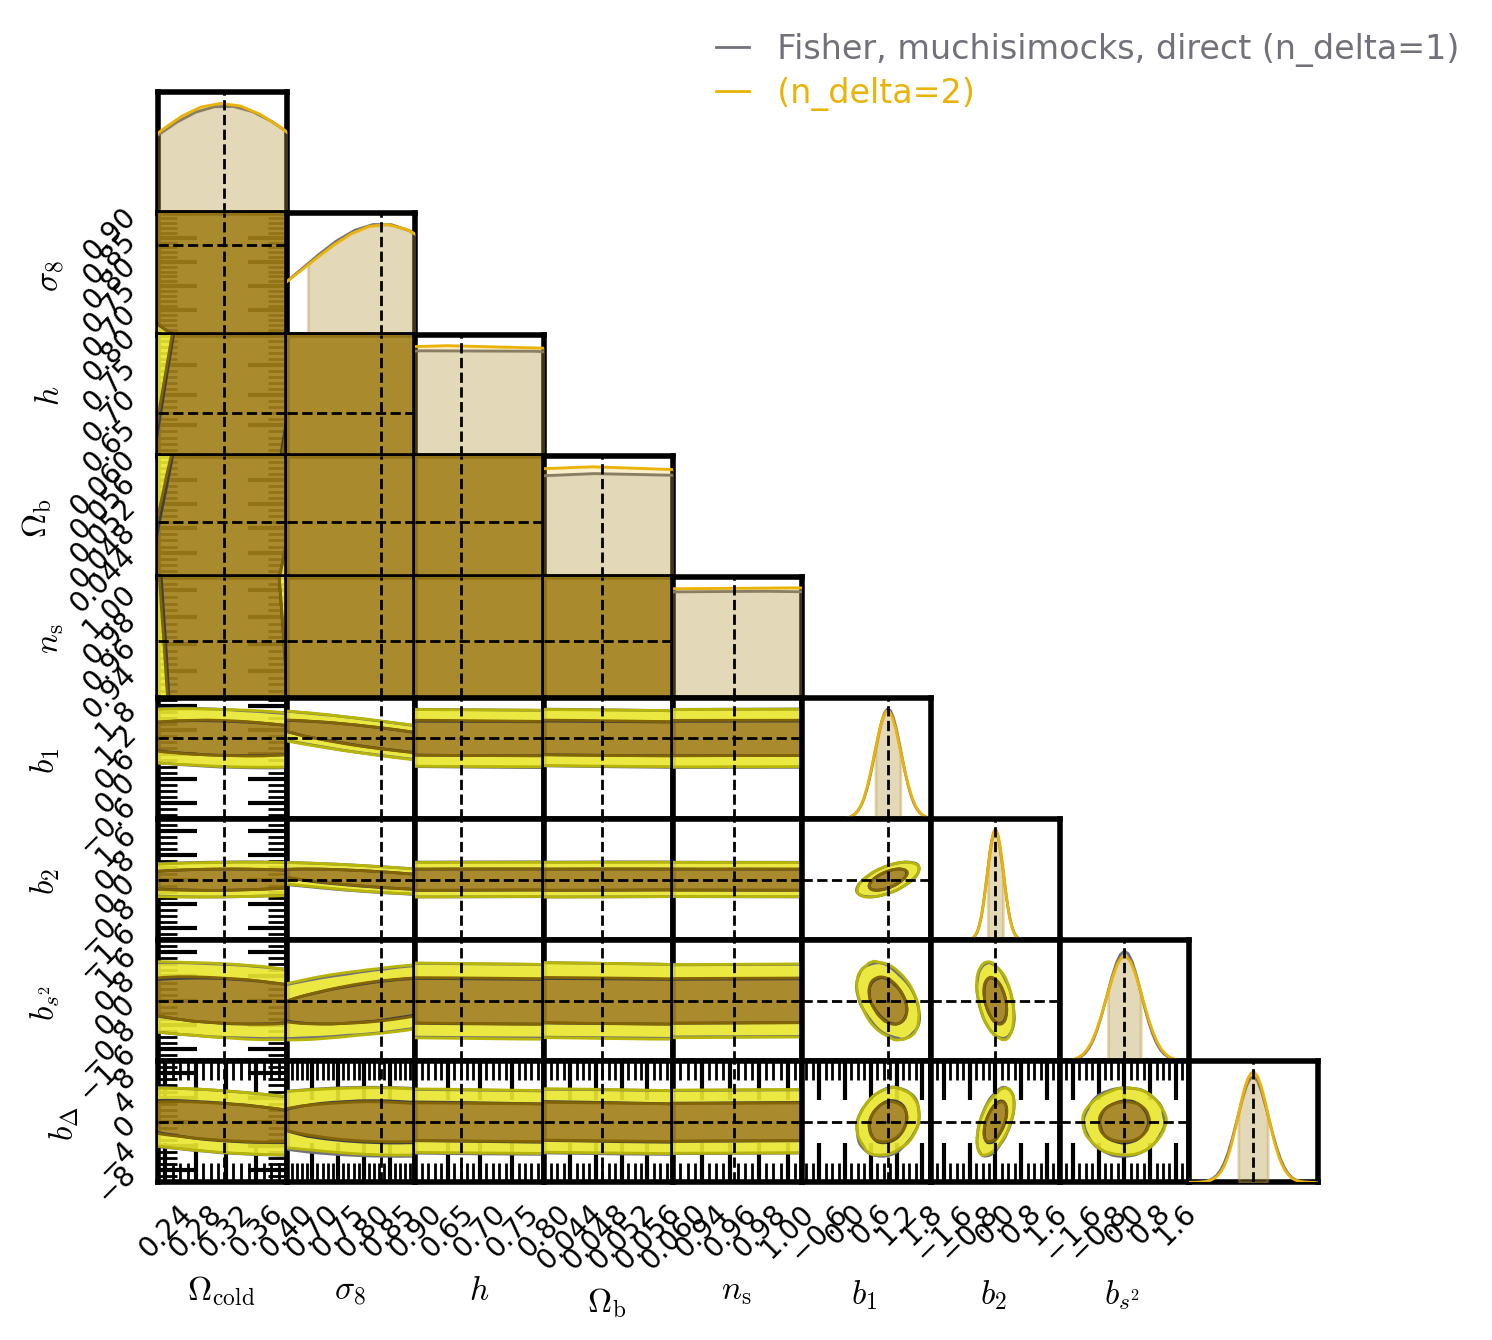

In [34]:

samples_arr = [samples_shift_biaszen_nd1, samples_shift_biaszen_nd2]
labels = ['Fisher, muchisimocks, direct (n_delta=1)', '(n_delta=2)']
colors = ['gray', 'yellow']
smooth_arr = [2]*len(samples_arr)
bins_arr = [10]*len(samples_arr)
plotter.plot_contours(samples_arr, labels, colors, utils.param_names_all_ordered, 
                      utils.param_label_dict, 
                  smooth_arr=smooth_arr, bins_arr=bins_arr,
                  truth_loc=params_dict_cv, title=None, extents=extents, 
                  figsize=(7,7), fn_save=None)

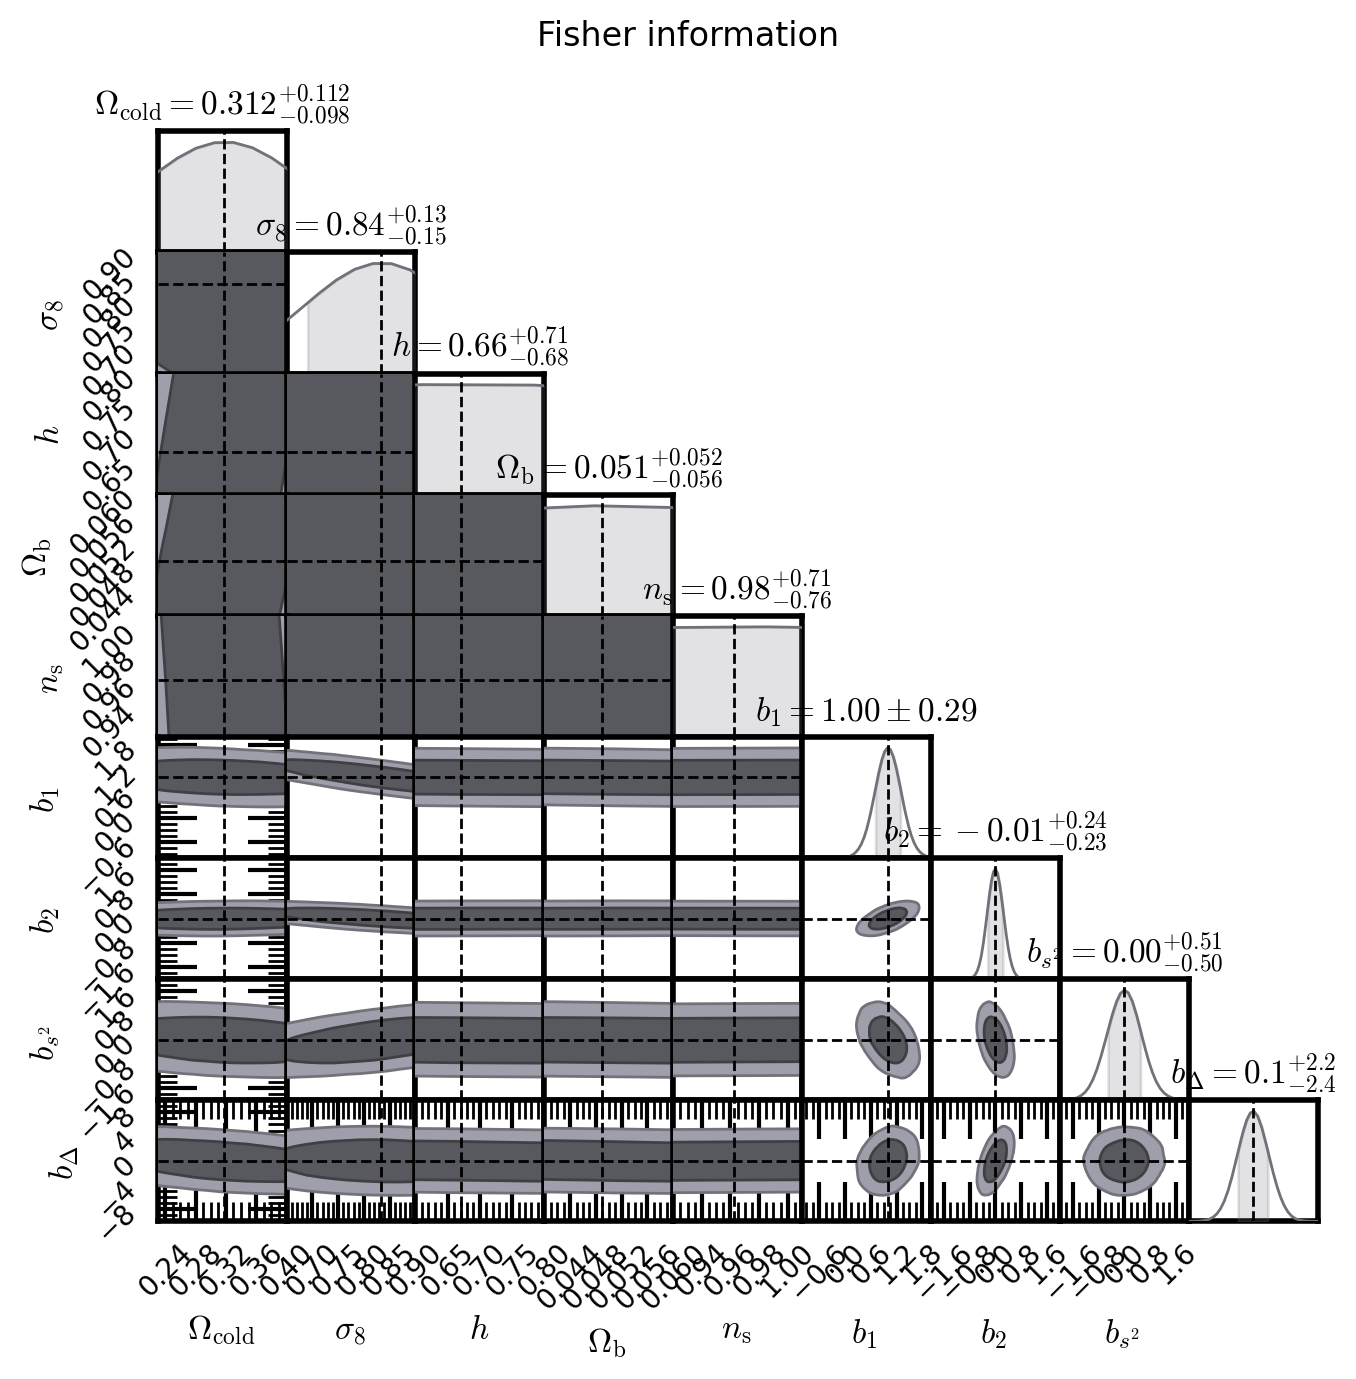

In [35]:

samples_arr = [samples_shift_biaszen_nd1]
labels = ['Fisher, muchisimocks, direct (n_delta=1)', '(n_delta=2)']
colors = ['gray', 'yellow']
smooth_arr = [2]*len(samples_arr)
bins_arr = [10]*len(samples_arr)
plotter.plot_contours(samples_arr, labels, colors, utils.param_names_all_ordered, 
                      utils.param_label_dict, 
                  smooth_arr=smooth_arr, bins_arr=bins_arr,
                  truth_loc=params_dict_cv, title='Fisher information', extents=extents, 
                  figsize=(7,7), fn_save=None)

In [40]:
# n_train = 10000
# tag_params_train = '_p5_n10000'
# tag_biasparams_train = '_biaszen_p4_n10000'
# tag_biasparams_train_x10 = '_biaszen_p4_n100000'

# inf_methods = [
#                'sbi',
#                #'fisher'
#               ]
# tags_inf = [
#             f'_muchisimocksPk{tag_params_train}{tag_biasparams_train}_ntrain{n_train}_best-sbi-rand10',
#             #'_muchisimocks_pk'
#             ]
# tags_test = [
#              #f'{tag_data_test_fixed}_mean',
#              '_muchisimocksPk_quijote_p0_n1000_b1000_p0_n1_mean',
#              ''
#             ]
# labels = [
#                 '',
#                 '',
#                 ]
# title = 'SBI (recovery test: mean of 1000 fixed cosmo mocks)'
# #title = 'SBI'
# colors = ['blue', 'gray']

# print(tags_inf)
# param_names_vary = utils.param_names_all_ordered
# idx_obs = 0
# plotter.plot_contours_inf(param_names_vary, idx_obs, theta_fid, 
#                         inf_methods, tags_inf, tags_test=tags_test,
#                         colors=colors, labels=labels,
#                         title=title, extents=extents)

### Add priors

In [41]:

# assume gaussian w width half the extent
sigmas = np.array([(extents[pn][1]-extents[pn][0]) for pn in utils.param_names_all_ordered])

cov_inv_priors = np.diag(1/sigmas**2)
fisher_matrix_shift_biaszen_nd1_withpriors = fisher_matrix_shift_biaszen_nd1 + cov_inv_priors
cov_fisher_shift_biaszen_nd1_withpriors = np.linalg.inv(fisher_matrix_shift_biaszen_nd1_withpriors)

cov_inv_priors2 = np.diag(1/(sigmas/2)**2)
fisher_matrix_shift_biaszen_nd1_withpriors2 = fisher_matrix_shift_biaszen_nd1 + cov_inv_priors2
cov_fisher_shift_biaszen_nd1_withpriors2 = np.linalg.inv(fisher_matrix_shift_biaszen_nd1_withpriors2)

In [42]:
n_samples = 10000
samples_shift_biaszen_nd1_withpriors = np.random.multivariate_normal(theta_fid[:len(utils.param_names_all_ordered)], cov_fisher_shift_biaszen_nd1_withpriors, size=n_samples)

n_samples = 10000
samples_shift_biaszen_nd1_withpriors2 = np.random.multivariate_normal(theta_fid[:len(utils.param_names_all_ordered)], cov_fisher_shift_biaszen_nd1_withpriors2, size=n_samples)

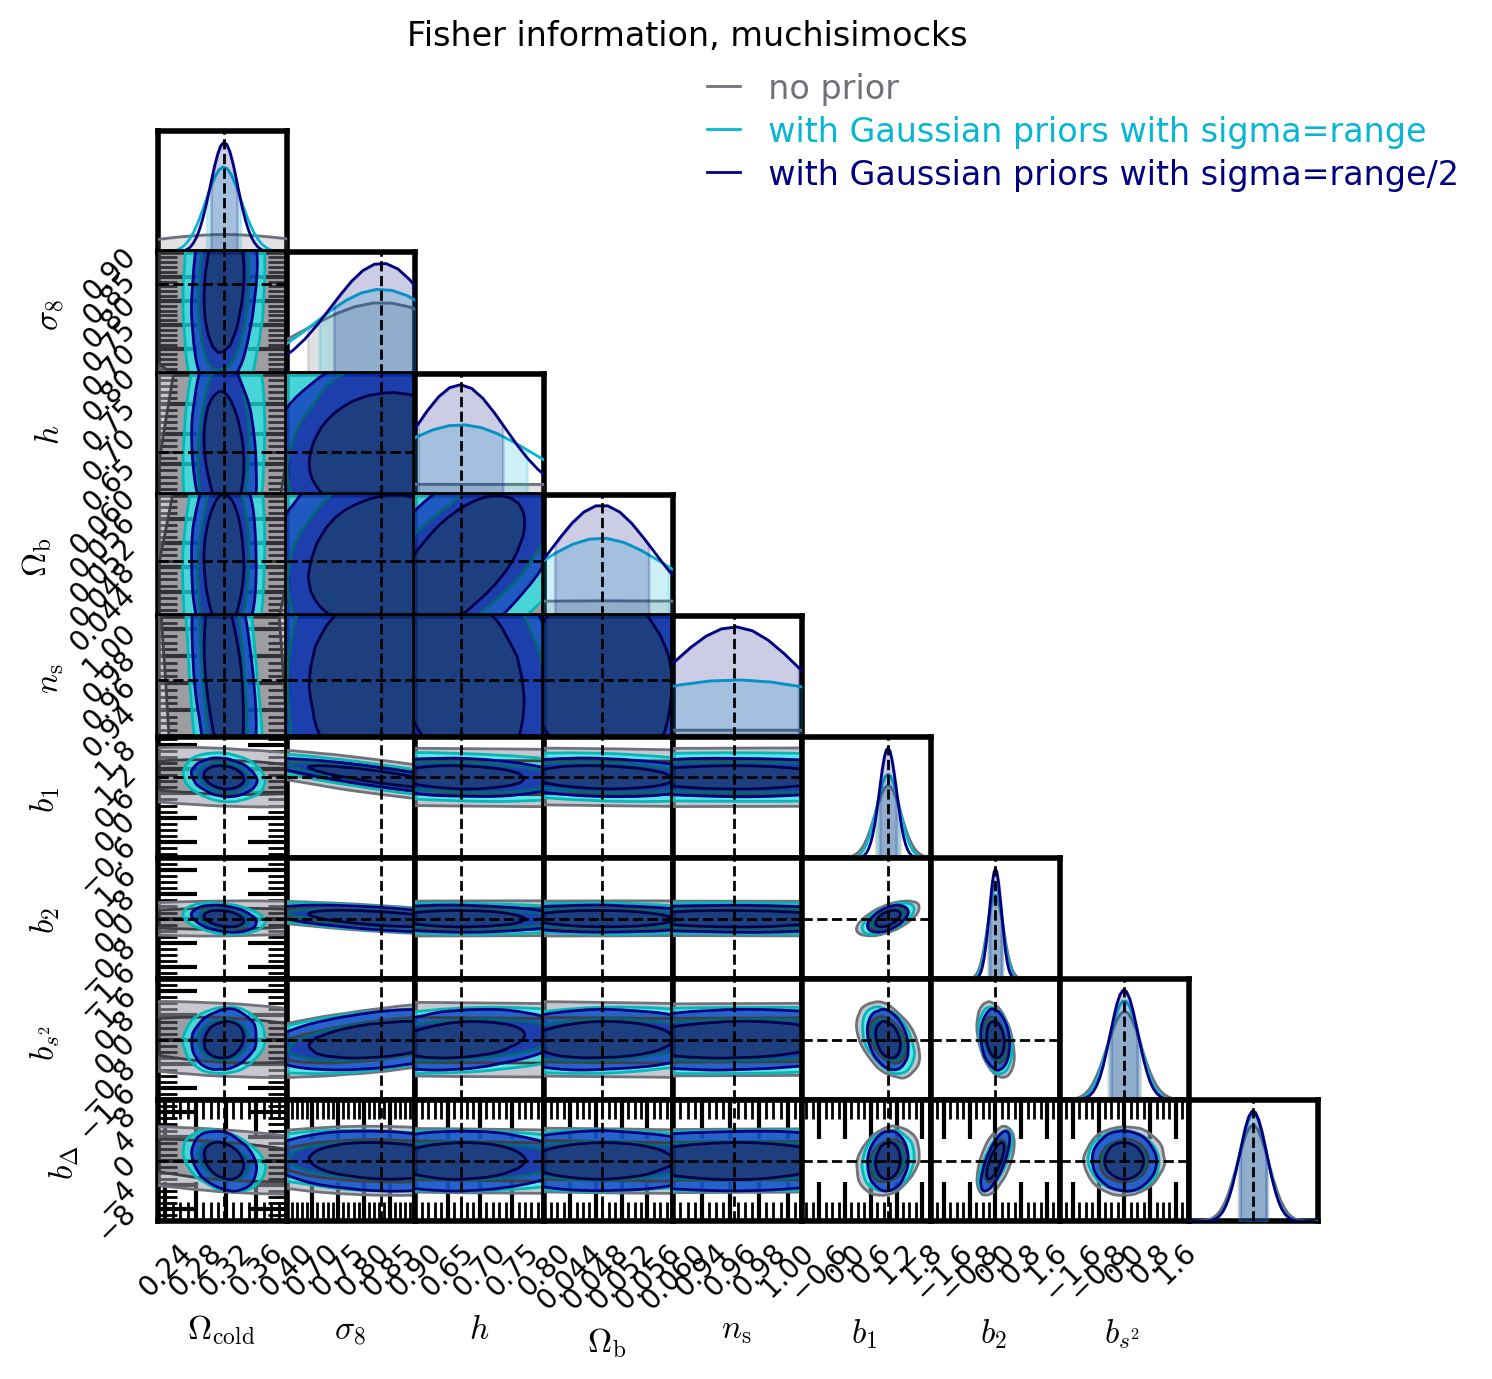

In [43]:

samples_arr = [samples_shift_biaszen_nd1, samples_shift_biaszen_nd1_withpriors, samples_shift_biaszen_nd1_withpriors2]
labels = ['no prior', 
          'with Gaussian priors with sigma=range',
          'with Gaussian priors with sigma=range/2']
colors = ['gray', 'cyan', '#000080']
smooth_arr = [2]*len(samples_arr)
bins_arr = [10]*len(samples_arr)
title = 'Fisher information, muchisimocks'
plotter.plot_contours(samples_arr, labels, colors, utils.param_names_all_ordered, 
                      utils.param_label_dict, 
                  smooth_arr=smooth_arr, bins_arr=bins_arr,
                  truth_loc=params_dict_cv, title=title, extents=extents, 
                  figsize=(7,7), fn_save=None)

# Bispectrum time!

## Fiducial CV set to get cov

In [44]:
data_mode = 'muchisimocks'
statistics_bispec = ['bispec']

tag_params_cv = '_quijote_p0_n1000'
tag_biasparams_cv = '_b1000_p0_n1'
tag_datagen = ''
kwargs_data = {
    'tag_datagen': tag_datagen
}

tag_stats_bispec = f'_{"_".join(statistics)}'    
tag_data_bispec = '_'+data_mode + tag_stats_bispec + tag_params_cv + tag_biasparams_cv + tag_datagen

In [45]:
k_cv_bispec, y_cv_bispec, y_err_cv_bispec, idxs_params_cv_bispec, params_df_cv_bispec, param_dict_fixed_cv_bispec, biasparams_df_cv_bispec, biasparams_dict_fixed_cv_bispec, random_ints_cosmo_cv_bispec, random_ints_bias_cv_bispec = \
            data_loader.load_data(data_mode, statistics_bispec, 
                                    tag_params_cv, tag_biasparams_cv,
                                    tag_data=tag_data_bispec,
                                    kwargs=kwargs_data)
k_cv_bispec, y_cv_bispec, y_err_cv_bispec = k_cv_bispec[0], y_cv_bispec[0], y_err_cv_bispec[0]

Loading muchisimocks data
Found 1000 diff cosmo bispecs in /scratch/kstoreyf/muchisimocks/data/bispecs_mlib/bispecs_quijote_p0_n1000_b1000_p0_n1
Loaded bispec data with shape (1000, 50)
No mask for this statistic, using all data
Masked 0 out of 50 bins


In [46]:
# this should align with y_cv
param_names_cv = data_loader.get_param_names(tag_params=tag_params_cv, tag_biasparams=tag_biasparams_cv)

In [47]:
params_dict_cv = param_dict_fixed_cv.copy()
params_dict_cv.update(biasparams_dict_fixed_cv)
print(params_dict_cv)

{'omega_cold': 0.3175, 'sigma8_cold': 0.834, 'hubble': 0.6711, 'omega_baryon': 0.049, 'ns': 0.9624, 'neutrino_mass': 0.0, 'w0': -1.0, 'wa': 0.0, 'b1': 1, 'b2': 0, 'bs2': 0, 'bl': 0}


In [48]:
cov_fid_bispec = np.cov(y_cv_bispec, rowvar=False)
print(cov_fid_bispec.shape)

(50, 50)


In [49]:
theta_fid = [params_dict_cv[param] for param in utils.param_names_all_ordered]

In [50]:
corr_fid_bispec = cov_fid_bispec / np.sqrt(np.outer(np.diag(cov_fid_bispec), np.diag(cov_fid_bispec)))

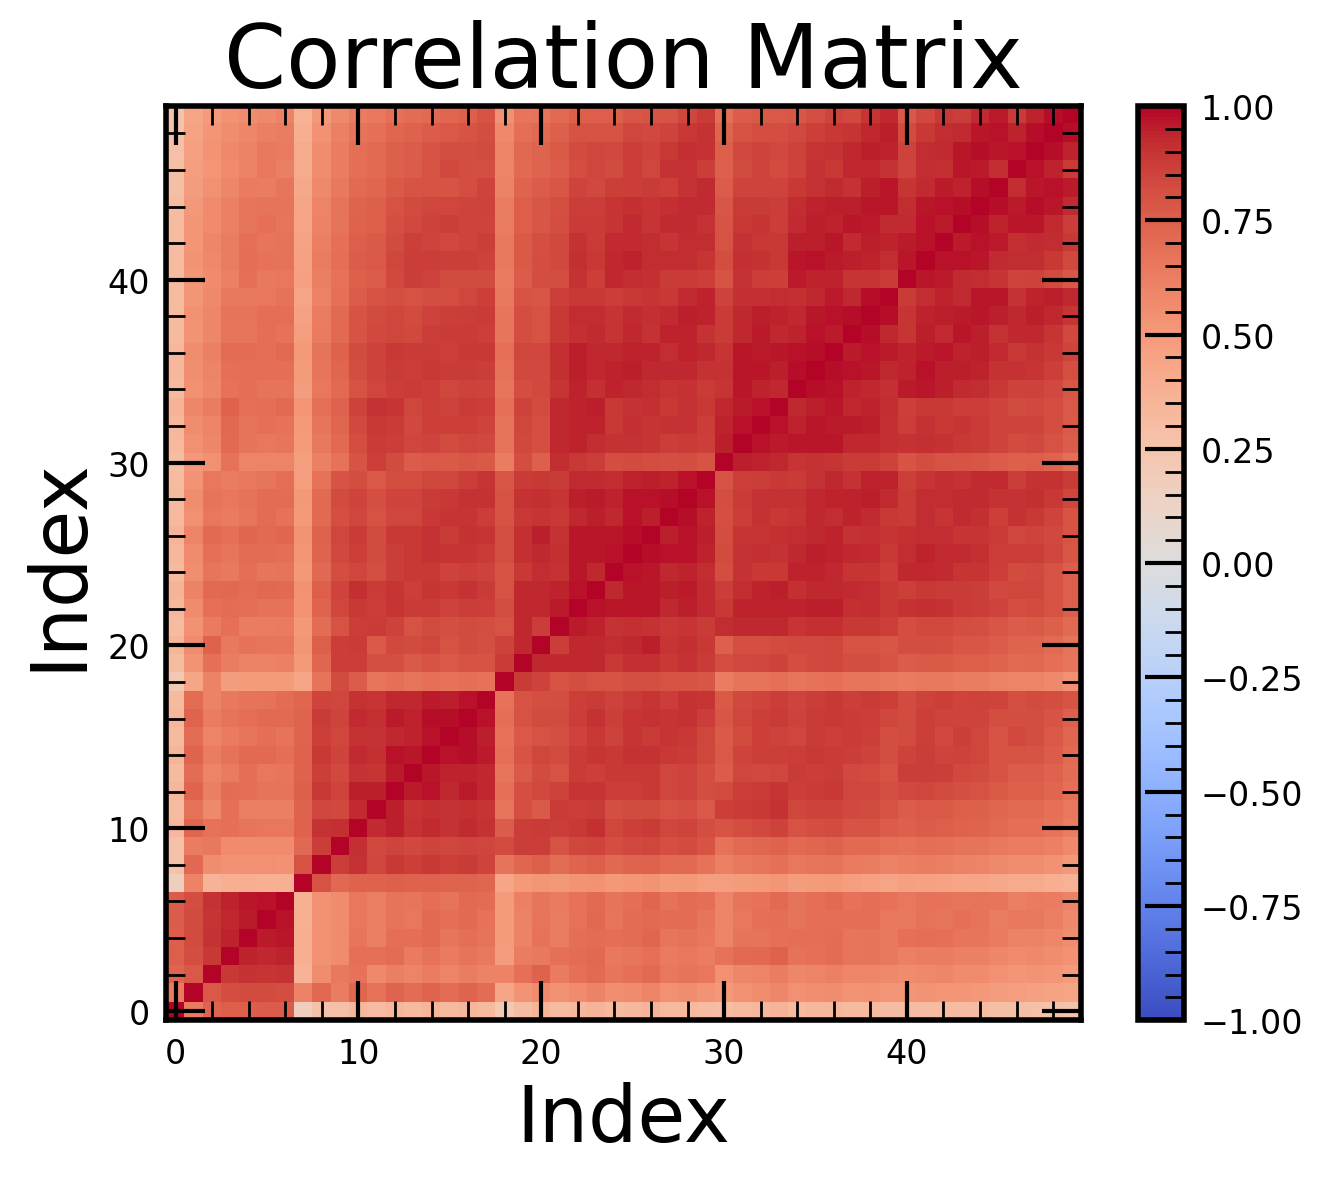

In [51]:
plt.figure(figsize=(8, 6))
im = plt.imshow(corr_fid_bispec, cmap='coolwarm', vmin=-1, vmax=1, aspect='equal', origin='lower')
plt.title('Correlation Matrix')
plt.xlabel('Index')
plt.ylabel('Index')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

## Fisher set to get derivs

In [52]:
data_mode = 'muchisimocks'
statistics_bispec = ['bispec']

tag_params = '_fisher_quijote'
tag_biasparams_biaszen = '_fisher_biaszen'
tag_datagen = ''
kwargs_data = {
    'tag_datagen': tag_datagen
}

tag_stats_bispec = f'_{"_".join(statistics_bispec)}'    
tag_data_biaszen_bispec = '_'+data_mode + tag_stats_bispec + tag_params + tag_biasparams_biaszen + tag_datagen

In [53]:
k_biaszen_bispec, y_biaszen_bispec, y_err_biaszen_bispec, idxs_params_biaszen_bispec, params_df_biaszen_bispec, param_dict_fixed_biaszen_bispec, biasparams_df_biaszen_bispec, biasparams_dict_fixed_biaszen_bispec, random_ints_cosmo_biaszen_bispec, random_ints_bias_biaszen_bispec = \
            data_loader.load_data(data_mode, statistics_bispec, 
                                    tag_params, tag_biasparams_biaszen,
                                    tag_data=tag_data_biaszen_bispec,
                                    kwargs=kwargs_data)
k_biaszen_bispec, y_biaszen_bispec, y_err_biaszen_bispec, = k_biaszen_bispec[0], y_biaszen_bispec[0], y_err_biaszen_bispec[0]
print(k_biaszen_bispec.shape)
print(y_biaszen_bispec.shape)

Loading muchisimocks data
Found 21 diff cosmo bispecs in /scratch/kstoreyf/muchisimocks/data/bispecs_mlib/bispecs_fisher_quijote_fisher_biaszen
Loaded bispec data with shape (37, 50)
No mask for this statistic, using all data
Masked 0 out of 50 bins
(3, 50)
(37, 50)


In [54]:
y_biaszen_bispec_ordered = y_biaszen_bispec[matching_indices]
print(y_biaszen_bispec_ordered.shape)

(37, 50)


### Compute derivs

In [55]:
derivatives_shift_biaszen_bispec_nd1 = compute_derivatives_from_fisherset(params_all_df, 
                                                                   y_biaszen_bispec_ordered, 
                        utils.param_names_all_ordered, n_deltas_for_diff=1)

In [56]:
derivatives_shift_biaszen_bispec_nd2 = compute_derivatives_from_fisherset(params_all_df, 
                                                                   y_biaszen_bispec_ordered, 
                        utils.param_names_all_ordered, n_deltas_for_diff=2)

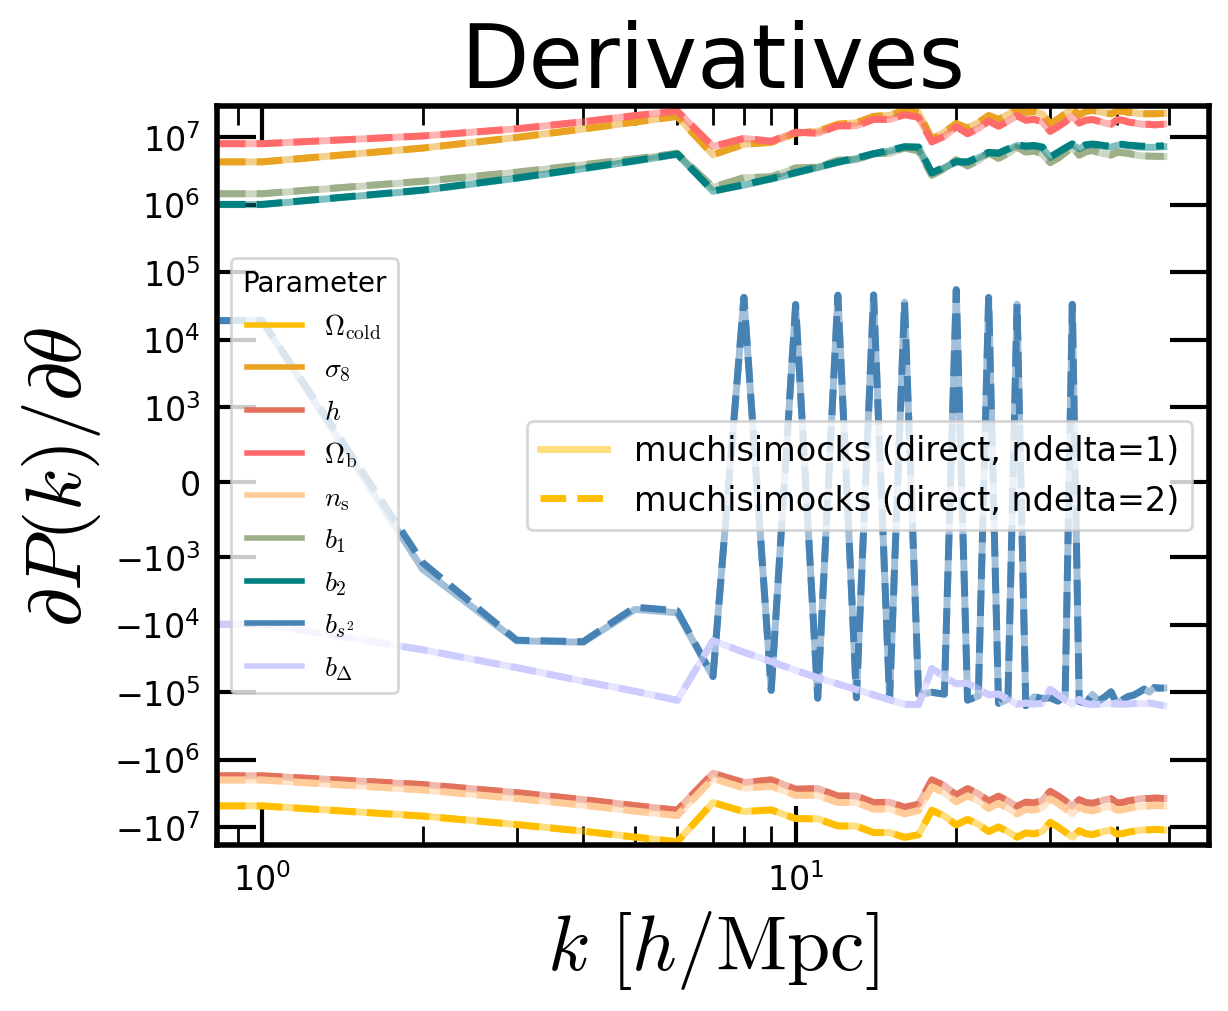

In [57]:
colors_params = ["#FFBF00", "#EAA221", "#E2725B", "#FF6B6B", "#FFCC99", "#9CAF88", "#008080", "#4682B4", "#CCCCFF"]

param_names_show = utils.param_names_all_ordered
for i, param_name in enumerate(param_names_show):
#for i, param_name in enumerate(param_names):
    if i==0:
        label_muchisimocks = 'muchisimocks (direct, ndelta=1)'
        label_muchisimocks2 = 'muchisimocks (direct, ndelta=2)'
    else:
        label_muchisimocks = None
        label_muchisimocks2 = None

    plt.plot(derivatives_shift_biaszen_bispec_nd1[param_name], label=label_muchisimocks, color=colors_params[i], alpha=0.5)
    plt.plot(derivatives_shift_biaszen_bispec_nd2[param_name], label=label_muchisimocks2, color=colors_params[i], ls='--')
    # plt.plot(k_emu, derivatives_emu[param_name], label=label_emuPk, ls='--', lw=1, color=colors_params[i])
    # plt.plot(k_emu, derivatives_emu_shift[param_name], label=label_emuPk_shift, ls=':', color=colors_params[i])
#plt.plot(k_emu, np.sqrt(np.diag(cov_fid_emu)), label='cov_fid_emu', color='red')


# First legend: dataset types
legend1 = plt.legend(fontsize=12, loc='best')
plt.gca().add_artist(legend1)

# Second legend: parameter colors
from matplotlib.lines import Line2D
param_legend_handles = [Line2D([0], [0], color=colors_params[i], lw=2, label=utils.param_label_dict[param_names_show[i]]) for i in range(len(param_names_show))]
plt.legend(handles=param_legend_handles, title='Parameter', loc='best', fontsize=10)

plt.title(f'Derivatives')
plt.xlabel(r'$k\ [h/\mathrm{Mpc}]$')
plt.ylabel(r'$\partial P(k) / \partial \theta$')
plt.xscale('log')
plt.yscale('symlog', linthresh=1e3)

### Compute fisher matrices

In [58]:
fisher_matrix_shift_biaszen_bispec_nd1 = utils.compute_fisher_matrix(derivatives_shift_biaszen_bispec_nd1, cov_fid_bispec, utils.param_names_all_ordered)
cov_fisher_shift_biaszen_bispec_nd1 = np.linalg.inv(fisher_matrix_shift_biaszen_bispec_nd1)
print("Fisher matrix shape:", fisher_matrix_shift_biaszen_bispec_nd1.shape)

Fisher matrix shape: (9, 9)


In [59]:
fisher_matrix_shift_biaszen_bispec_nd2 = utils.compute_fisher_matrix(derivatives_shift_biaszen_bispec_nd2, cov_fid_bispec, utils.param_names_all_ordered)
cov_fisher_shift_biaszen_bispec_nd2 = np.linalg.inv(fisher_matrix_shift_biaszen_bispec_nd2)
print("Fisher matrix shape:", fisher_matrix_shift_biaszen_bispec_nd2.shape)

Fisher matrix shape: (9, 9)


In [60]:
n_samples = 10000
samples_shift_biaszen_bispec_nd1 = np.random.multivariate_normal(theta_fid[:len(utils.param_names_all_ordered)], cov_fisher_shift_biaszen_bispec_nd1, size=n_samples)

In [61]:
n_samples = 10000
samples_shift_biaszen_bispec_nd2 = np.random.multivariate_normal(theta_fid[:len(utils.param_names_all_ordered)], cov_fisher_shift_biaszen_bispec_nd2, size=n_samples)

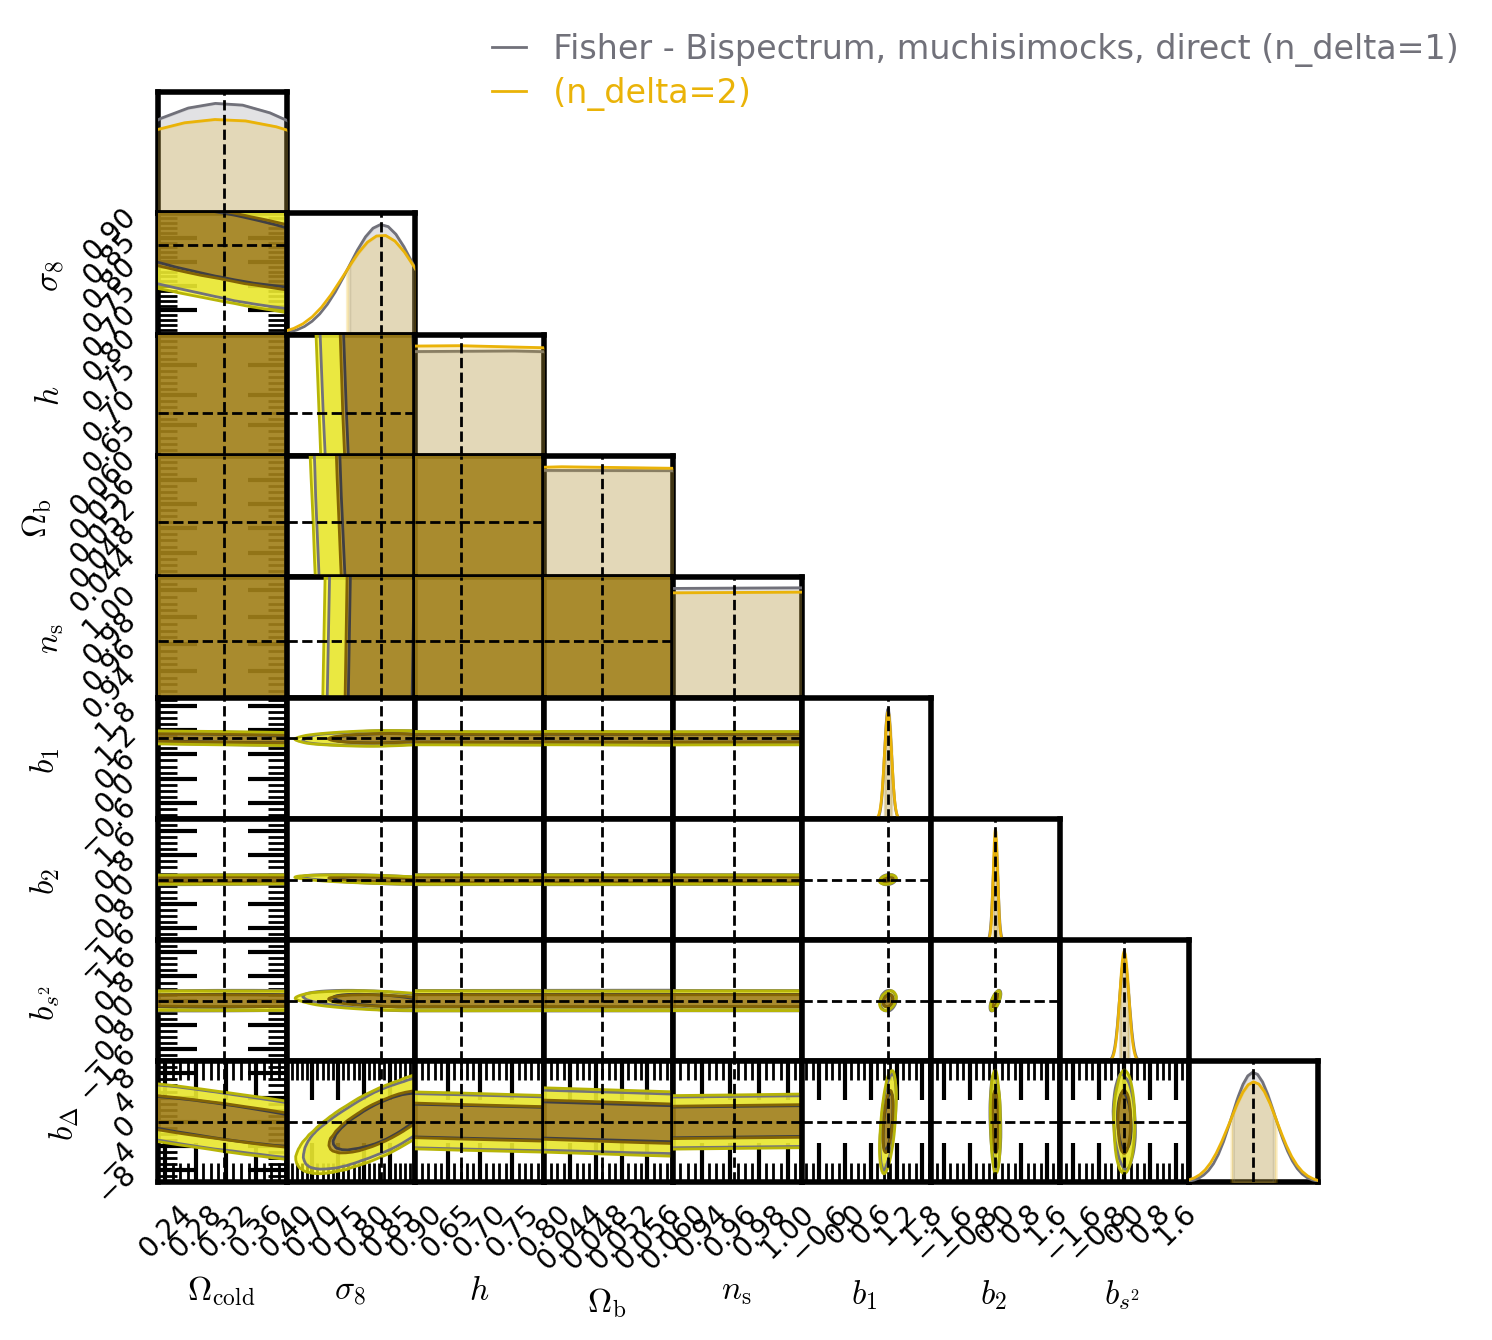

In [62]:

samples_arr = [samples_shift_biaszen_bispec_nd1, samples_shift_biaszen_bispec_nd2]
labels = ['Fisher - Bispectrum, muchisimocks, direct (n_delta=1)', '(n_delta=2)']
colors = ['gray', 'yellow']
smooth_arr = [2]*len(samples_arr)
bins_arr = [10]*len(samples_arr)
plotter.plot_contours(samples_arr, labels, colors, utils.param_names_all_ordered, 
                      utils.param_label_dict, 
                  smooth_arr=smooth_arr, bins_arr=bins_arr,
                  truth_loc=params_dict_cv, title=None, extents=extents, 
                  figsize=(7,7), fn_save=None)

## P(k) + bispec

In [63]:
# 1. Stack the data vectors (not strictly needed for Fisher, but for completeness)
y_cv_combined = np.concatenate([y_cv, y_cv_bispec], axis=1)  # shape: N x (D+D_bispec)

# 2. Build the block-diagonal covariance matrix
from scipy.linalg import block_diag

cov_combined = block_diag(cov_fid, cov_fid_bispec)  # shape: (D+D_bispec, D+D_bispec)

# 3. Concatenate the derivatives for each parameter
derivatives_combined = {}
for param in utils.param_names_all_ordered:
    deriv_pk = derivatives_shift_biaszen_nd1[param]           # shape: D
    deriv_bispec = derivatives_shift_biaszen_bispec_nd1[param] # shape: D_bispec
    derivatives_combined[param] = np.concatenate([deriv_pk, deriv_bispec])

print(len(derivatives_combined['omega_cold']))

fisher_matrix_combined = utils.compute_fisher_matrix(derivatives_combined, cov_combined, utils.param_names_all_ordered)
cov_fisher_combined = np.linalg.inv(fisher_matrix_combined)

print("Combined Fisher matrix shape:", fisher_matrix_combined.shape)

79
Combined Fisher matrix shape: (9, 9)


In [64]:
n_samples = 10000
samples_shift_combined = np.random.multivariate_normal(theta_fid[:len(utils.param_names_all_ordered)], cov_fisher_combined, size=n_samples)

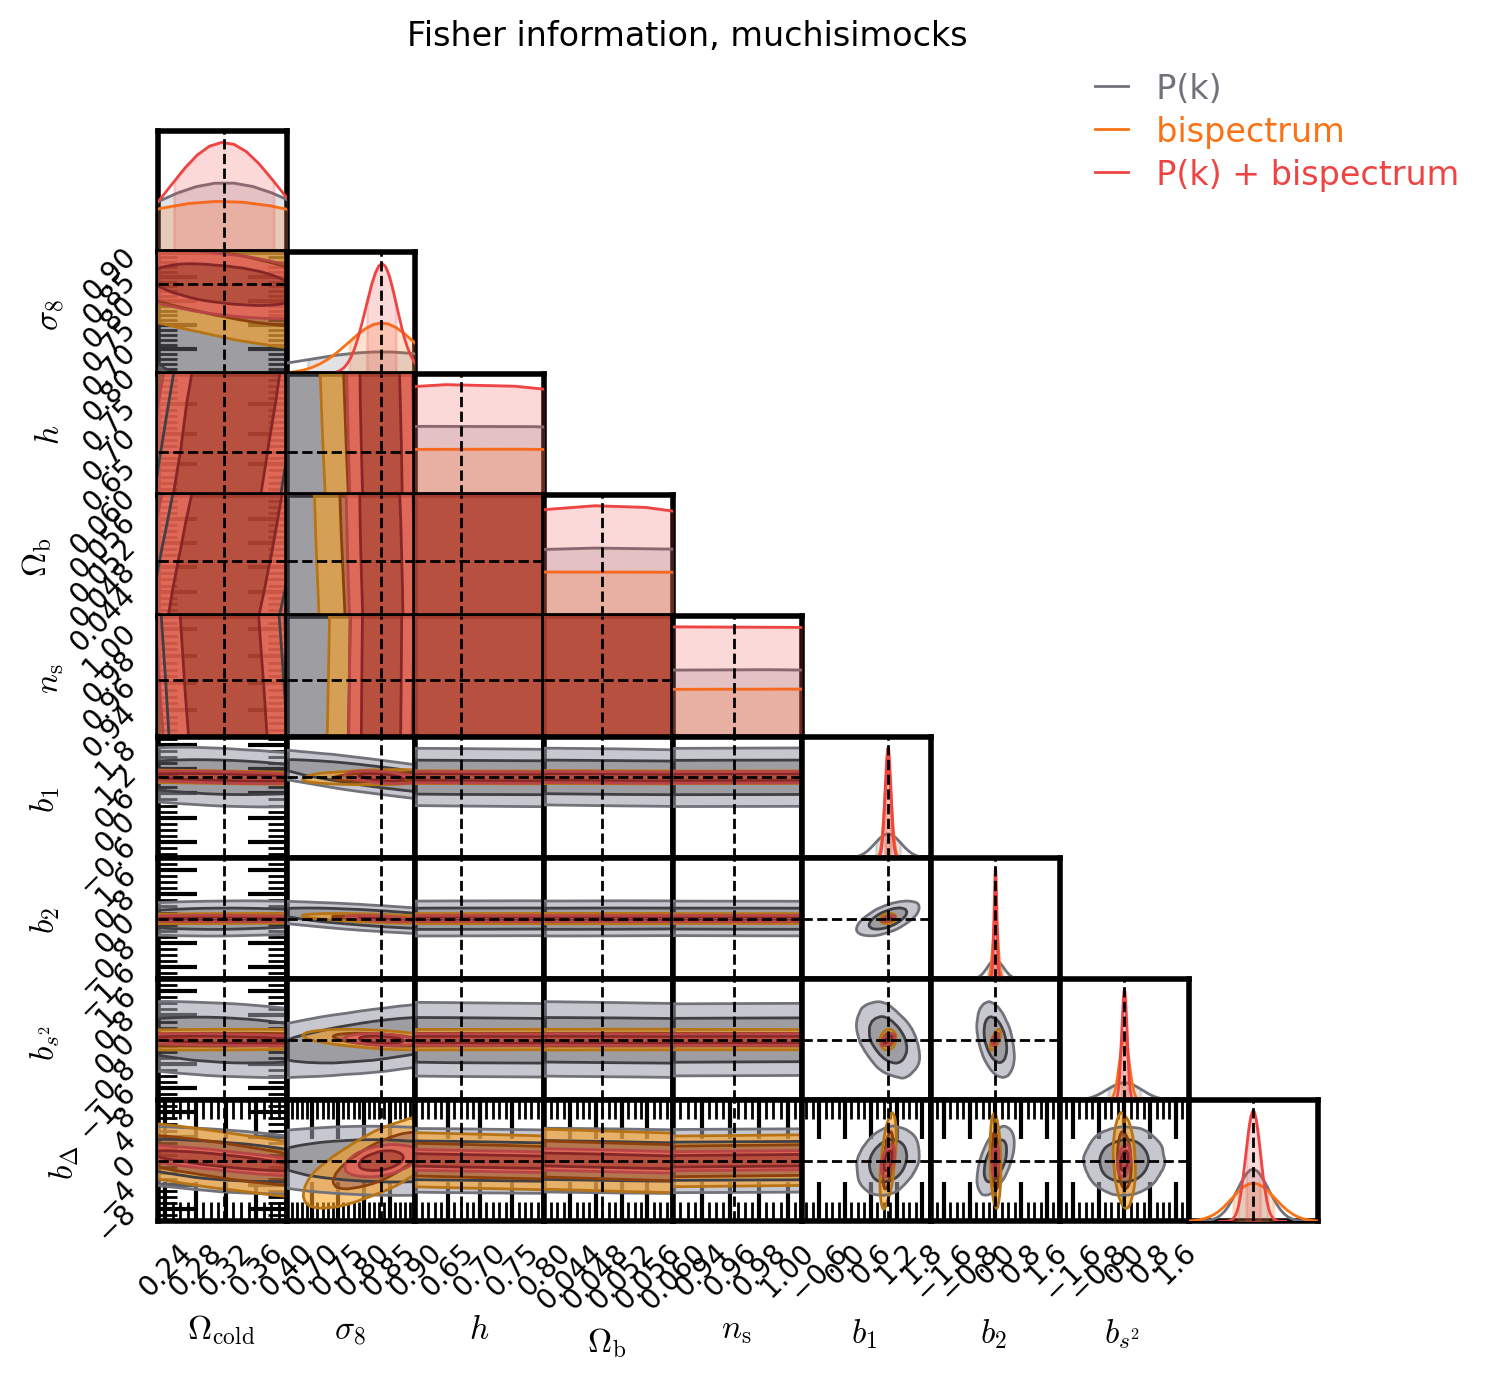

In [65]:

samples_arr = [samples_shift_biaszen_nd1, samples_shift_biaszen_bispec_nd1, samples_shift_combined]
labels = ['P(k)',
          'bispectrum',
          'P(k) + bispectrum']
colors = ['gray', 'orange', 'red']
smooth_arr = [2]*len(samples_arr)
bins_arr = [10]*len(samples_arr)
title = 'Fisher information, muchisimocks'
plotter.plot_contours(samples_arr, labels, colors, utils.param_names_all_ordered, 
                      utils.param_label_dict, 
                  smooth_arr=smooth_arr, bins_arr=bins_arr,
                  truth_loc=params_dict_cv, title=title, extents=extents, 
                  figsize=(7,7), fn_save=None)

# Emulator fisher info estimate

## Emulated CV dataset

In [66]:
data_mode_emu = 'emu'
statistics = ['pk']

tag_params = '_quijote_p0_n1000'
tag_biasparams = '_b1000_p0_n1'
tag_errG = '_boxsize1000'
n_rlzs_per_cosmo = 1
tag_noiseless = ''
#tag_noiseless = '_noiseless' # if use noiseless, set evaluate_mean=False (?)
tag_datagen = f'{tag_errG}_nrlzs{n_rlzs_per_cosmo}'
kwargs_data = {'n_rlzs_per_cosmo': n_rlzs_per_cosmo,
                    'tag_errG': tag_errG,
                    'tag_datagen': tag_datagen,
                    'tag_noiseless': tag_noiseless}
    
tag_stats = f'_{"_".join(statistics)}'    
tag_data_emu = '_'+data_mode_emu + tag_stats + tag_params + tag_biasparams + tag_datagen

In [67]:
k_cv_emu, y_cv_emu, y_err_cv_emu, idxs_params_emu, params_df_cv_emu, param_dict_fixed_cv_emu, biasparams_df_cv_emu, biasparams_dict_fixed_cv_emu, random_ints_cosmo_cv_emu, random_ints_bias_cv_emu = \
            data_loader.load_data(data_mode_emu, statistics, 
                                    tag_params, tag_biasparams,
                                    tag_data=tag_data,
                                    kwargs=kwargs_data)
k_cv_emu, y_cv_emu, y_err_cv_emu = k_cv_emu[0], y_cv_emu[0], y_err_cv_emu[0]

../data/emuPks/emuPks_quijote_p0_n1000_b1000_p0_n1/emuPks_noisy_boxsize1000_nrlzs1.npy
(1000, 30)
Loaded pk data with shape (1000, 30)
fn_mask: ../data/masks/mask_muchisimocks_pk_fisher_quijote_b1000_p0_n1.txt
Loading from ../data/masks/mask_muchisimocks_pk_fisher_quijote_b1000_p0_n1.txt (already exists)
Masked 1 out of 30 bins


In [68]:
mask_emu = data_loader.get_Pk_mask(tag_data)
print(np.sum(mask_emu))

fn_mask: ../data/masks/mask_muchisimocks_pk_fisher_quijote_b1000_p0_n1.txt
Loading from ../data/masks/mask_muchisimocks_pk_fisher_quijote_b1000_p0_n1.txt (already exists)
29


In [69]:
params_dict_cv_emu = param_dict_fixed_cv_emu.copy()
params_dict_cv_emu.update(biasparams_dict_fixed_cv_emu)
print(params_dict_cv_emu)

{'omega_cold': 0.3175, 'sigma8_cold': 0.834, 'hubble': 0.6711, 'omega_baryon': 0.049, 'ns': 0.9624, 'neutrino_mass': 0.0, 'w0': -1.0, 'wa': 0.0, 'b1': 1, 'b2': 0, 'bs2': 0, 'bl': 0}


In [70]:
cov_fid_emu = np.cov(y_cv_emu, rowvar=False)
print(cov_fid_emu.shape)

(29, 29)


## Emulator Pk derivatives

In [71]:
def compute_emulated_pks(params_all_df, param_dict_fixed, emu, k_emu):
    """
    Compute emulated P(k) for each row in params_all_df.
    Returns: array of shape (n_samples, len(k_emu))
    """
    pks = []
    for _, row in params_all_df.iterrows():
        # Build parameter dicts
        cosmo_params = {pn: row[pn] for pn in utils.cosmo_param_names_ordered}
        cosmo_params.update(param_dict_fixed)
        bias_params = [row[bn] for bn in utils.biasparam_names_ordered]
        # Some emulators require specific param names, adapt as needed
        cosmo_params_emu = {utils.param_name_to_param_name_emu(k): v for k, v in cosmo_params.items()}
        cosmo_params_emu['expfactor'] = 1.0
        _, pk, _ = emu.get_galaxy_real_pk(bias=bias_params, k=k_emu, **cosmo_params_emu)
        pks.append(pk)
    return np.array(pks)

In [72]:
dir_emus_lbias = '/home/kstoreyf/external'
emu, emu_bounds, emu_param_names = utils.load_emu(dir_emus_lbias=dir_emus_lbias)

Loading l-bias lpt emulator...


/home/kstoreyf/.conda/envs/benv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/kstoreyf/.conda/envs/benv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/kstoreyf/.conda/envs/benv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version

/home/kstoreyf/.conda/envs/benv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/kstoreyf/.conda/envs/benv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/kstoreyf/.conda/envs/benv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version

L-bias lpt emulator loaded in memory.
Loading smeared bao emulator...
Smeared bao emulator loaded in memory.
Loading non-linear l-bias emulator...


/home/kstoreyf/.conda/envs/benv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/kstoreyf/.conda/envs/benv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/kstoreyf/.conda/envs/benv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.1.1 when using ver

Nonlinear l-bias emulator loaded in memory.


/home/kstoreyf/.conda/envs/benv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [73]:
k = np.logspace(np.log10(0.01), np.log10(0.4), 30)
y_emu = compute_emulated_pks(params_all_df, param_dict_fixed, emu, k)
print(y_emu.shape)

(37, 30)


In [74]:
k = k[mask_emu]
y_emu = y_emu[:, mask_emu]
print(y_emu.shape)

(37, 29)


In [75]:
derivatives_shift_emu_nd1 = compute_derivatives_from_fisherset(params_all_df, y_emu, 
                        utils.param_names_all_ordered, n_deltas_for_diff=1)

In [76]:
derivatives_shift_emu_nd2 = compute_derivatives_from_fisherset(params_all_df, y_emu, 
                        utils.param_names_all_ordered, n_deltas_for_diff=2)

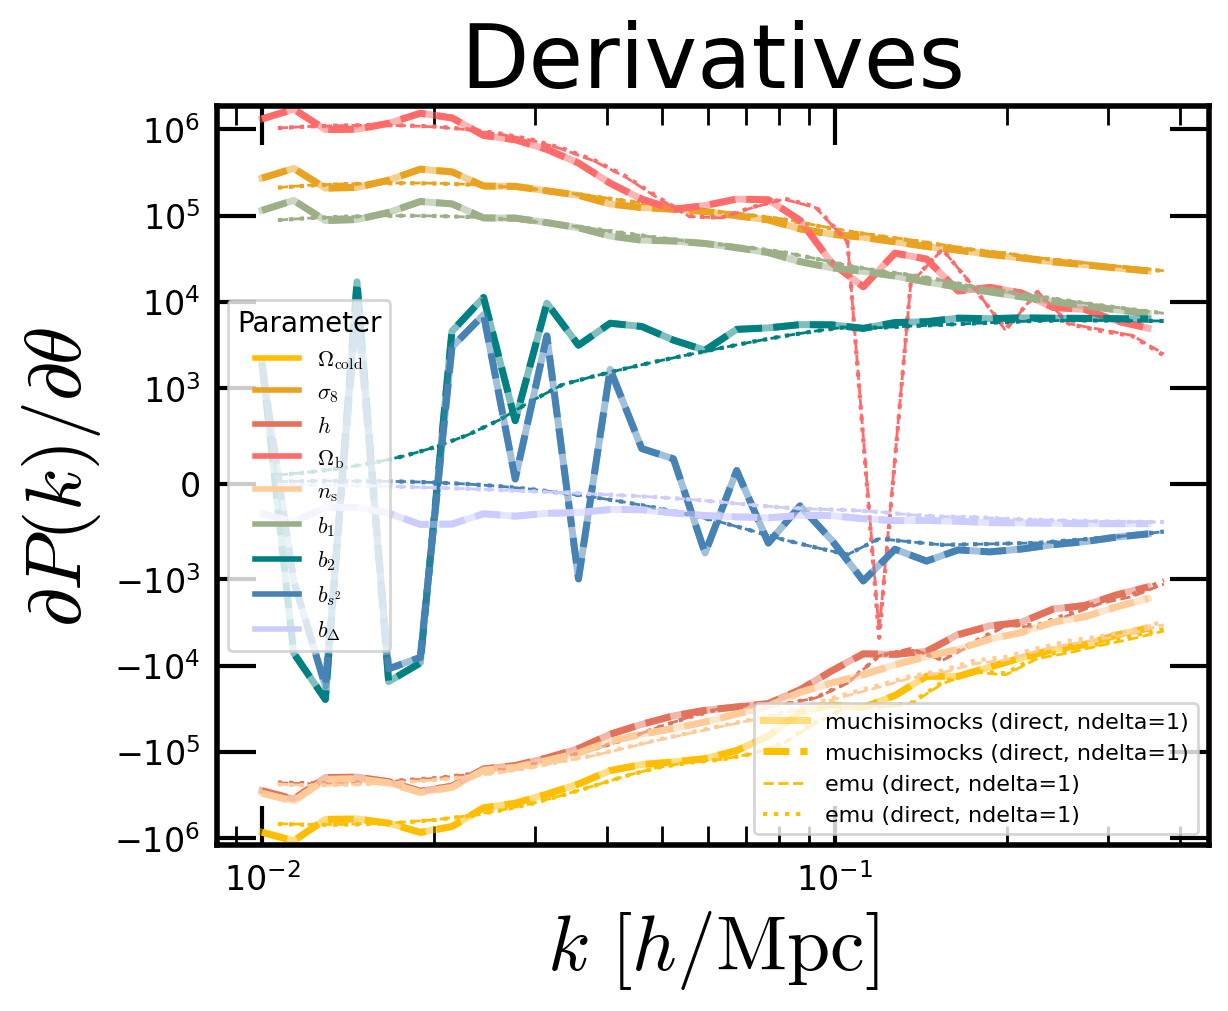

In [77]:
colors_params = ["#FFBF00", "#EAA221", "#E2725B", "#FF6B6B", "#FFCC99", "#9CAF88", "#008080", "#4682B4", "#CCCCFF"]

param_names_show = utils.param_names_all_ordered
for i, param_name in enumerate(param_names_show):
#for i, param_name in enumerate(param_names):
    if i==0:
        label_muchisimocks = 'muchisimocks (direct, ndelta=1)'
        label_emu = 'emu (direct, ndelta=1)'
    else:
        label_muchisimocks = None
        label_emu = None

    plt.plot(k, derivatives_shift_biaszen_nd1[param_name], label=label_muchisimocks, color=colors_params[i], alpha=0.5)
    plt.plot(k, derivatives_shift_biaszen_nd2[param_name], label=label_muchisimocks, color=colors_params[i], alpha=1, ls='--')
    plt.plot(k_biaszen, derivatives_shift_emu_nd1[param_name], label=label_emu, color=colors_params[i], lw=1, ls='--')
    plt.plot(k_biaszen, derivatives_shift_emu_nd2[param_name], label=label_emu, color=colors_params[i], lw=1.5, ls=':')
    # plt.plot(k_emu, derivatives_emu[param_name], label=label_emuPk, ls='--', lw=1, color=colors_params[i])
    # plt.plot(k_emu, derivatives_emu_shift[param_name], label=label_emuPk_shift, ls=':', color=colors_params[i])
#plt.plot(k_emu, np.sqrt(np.diag(cov_fid_emu)), label='cov_fid_emu', color='red')


# First legend: dataset types
legend1 = plt.legend(fontsize=8, loc='best')
plt.gca().add_artist(legend1)

# Second legend: parameter colors
from matplotlib.lines import Line2D
param_legend_handles = [Line2D([0], [0], color=colors_params[i], lw=2, label=utils.param_label_dict[param_names_show[i]]) for i in range(len(param_names_show))]
plt.legend(handles=param_legend_handles, title='Parameter', loc='best', fontsize=8)

plt.title(f'Derivatives')
plt.xlabel(r'$k\ [h/\mathrm{Mpc}]$')
plt.ylabel(r'$\partial P(k) / \partial \theta$')
plt.xscale('log')
plt.yscale('symlog', linthresh=1e3)

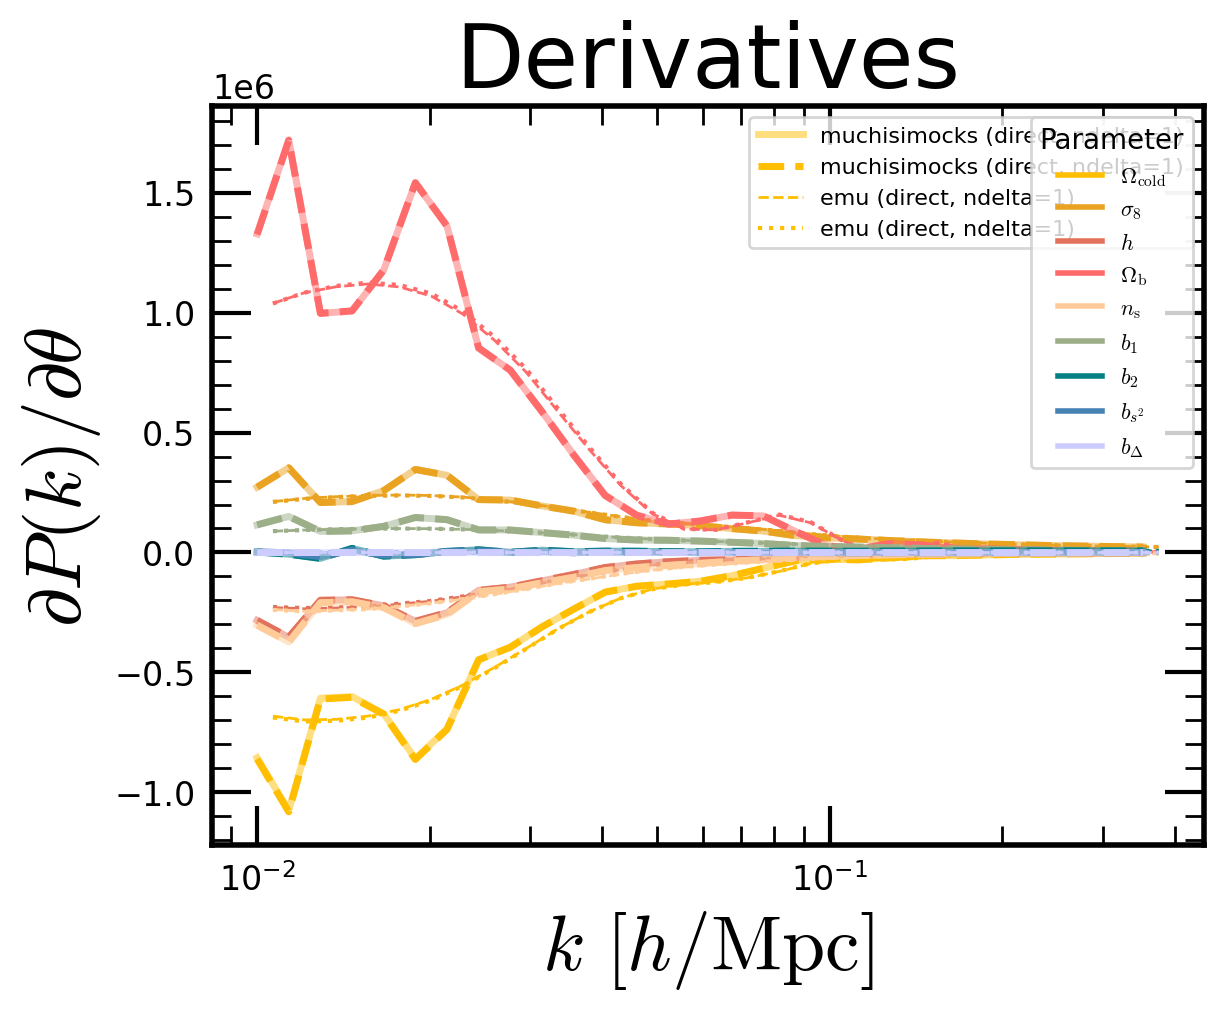

In [78]:
colors_params = ["#FFBF00", "#EAA221", "#E2725B", "#FF6B6B", "#FFCC99", "#9CAF88", "#008080", "#4682B4", "#CCCCFF"]

param_names_show = utils.param_names_all_ordered
for i, param_name in enumerate(param_names_show):
#for i, param_name in enumerate(param_names):
    if i==0:
        label_muchisimocks = 'muchisimocks (direct, ndelta=1)'
        label_emu = 'emu (direct, ndelta=1)'
    else:
        label_muchisimocks = None
        label_emu = None

    plt.plot(k, derivatives_shift_biaszen_nd1[param_name], label=label_muchisimocks, color=colors_params[i], alpha=0.5)
    plt.plot(k, derivatives_shift_biaszen_nd2[param_name], label=label_muchisimocks, color=colors_params[i], alpha=1, ls='--')
    plt.plot(k_biaszen, derivatives_shift_emu_nd1[param_name], label=label_emu, color=colors_params[i], lw=1, ls='--')
    plt.plot(k_biaszen, derivatives_shift_emu_nd2[param_name], label=label_emu, color=colors_params[i], lw=1.5, ls=':')
    # plt.plot(k_emu, derivatives_emu[param_name], label=label_emuPk, ls='--', lw=1, color=colors_params[i])
    # plt.plot(k_emu, derivatives_emu_shift[param_name], label=label_emuPk_shift, ls=':', color=colors_params[i])
#plt.plot(k_emu, np.sqrt(np.diag(cov_fid_emu)), label='cov_fid_emu', color='red')


# First legend: dataset types
legend1 = plt.legend(fontsize=8, loc='best')
plt.gca().add_artist(legend1)

# Second legend: parameter colors
from matplotlib.lines import Line2D
param_legend_handles = [Line2D([0], [0], color=colors_params[i], lw=2, label=utils.param_label_dict[param_names_show[i]]) for i in range(len(param_names_show))]
plt.legend(handles=param_legend_handles, title='Parameter', loc='best', fontsize=8)

plt.title(f'Derivatives')
plt.xlabel(r'$k\ [h/\mathrm{Mpc}]$')
plt.ylabel(r'$\partial P(k) / \partial \theta$')
plt.xscale('log')
#plt.yscale('symlog', linthresh=1e3)

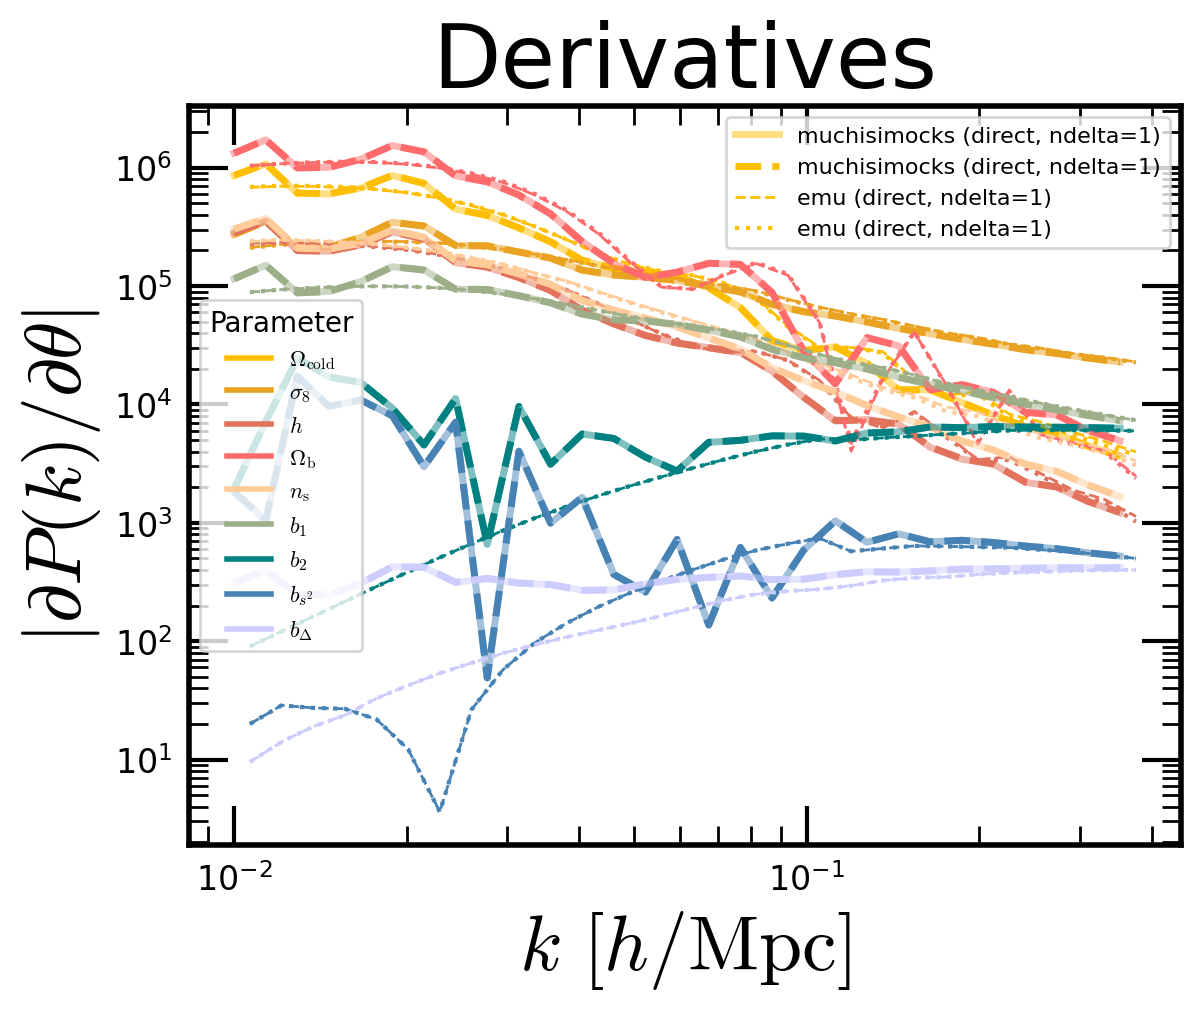

In [79]:
colors_params = ["#FFBF00", "#EAA221", "#E2725B", "#FF6B6B", "#FFCC99", "#9CAF88", "#008080", "#4682B4", "#CCCCFF"]

param_names_show = utils.param_names_all_ordered
for i, param_name in enumerate(param_names_show):
#for i, param_name in enumerate(param_names):
    if i==0:
        label_muchisimocks = 'muchisimocks (direct, ndelta=1)'
        label_emu = 'emu (direct, ndelta=1)'
    else:
        label_muchisimocks = None
        label_emu = None

    plt.plot(k, np.abs(derivatives_shift_biaszen_nd1[param_name]), label=label_muchisimocks, color=colors_params[i], alpha=0.5)
    plt.plot(k, np.abs(derivatives_shift_biaszen_nd2[param_name]), label=label_muchisimocks, color=colors_params[i], alpha=1, ls='--')
    plt.plot(k_biaszen, np.abs(derivatives_shift_emu_nd1[param_name]), label=label_emu, color=colors_params[i], lw=1, ls='--')
    plt.plot(k_biaszen, np.abs(derivatives_shift_emu_nd2[param_name]), label=label_emu, color=colors_params[i], lw=1.5, ls=':')
    # plt.plot(k_emu, derivatives_emu[param_name], label=label_emuPk, ls='--', lw=1, color=colors_params[i])
    # plt.plot(k_emu, derivatives_emu_shift[param_name], label=label_emuPk_shift, ls=':', color=colors_params[i])
#plt.plot(k_emu, np.sqrt(np.diag(cov_fid_emu)), label='cov_fid_emu', color='red')


# First legend: dataset types
legend1 = plt.legend(fontsize=8, loc='best')
plt.gca().add_artist(legend1)

# Second legend: parameter colors
from matplotlib.lines import Line2D
param_legend_handles = [Line2D([0], [0], color=colors_params[i], lw=2, label=utils.param_label_dict[param_names_show[i]]) for i in range(len(param_names_show))]
plt.legend(handles=param_legend_handles, title='Parameter', loc='best', fontsize=8)

plt.title(f'Derivatives')
plt.xlabel(r'$k\ [h/\mathrm{Mpc}]$')
plt.ylabel(r'$|\partial P(k) / \partial \theta|$')
plt.xscale('log')
plt.yscale('log')

recompute emu stats

In [80]:
cosmo_params = param_dict_fixed_cv_emu.copy()
# Some emulators require specific param names, adapt as needed
cosmo_params_emu = {utils.param_name_to_param_name_emu(k): v for k, v in cosmo_params.items()}
cosmo_params_emu['expfactor'] = 1.0
print(cosmo_params_emu)
k_emu_direct, pk_emu_direct, _ = emu.get_galaxy_real_pk(k=k_cv_emu, **cosmo_params_emu, bias=[1,0,0,0])
print(k_emu_direct.shape, pk_emu_direct.shape)

{'omega_cold': 0.3175, 'sigma8_cold': 0.834, 'hubble': 0.6711, 'omega_baryon': 0.049, 'ns': 0.9624, 'neutrino_mass': 0.0, 'w0': -1.0, 'wa': 0.0, 'expfactor': 1.0}
(29,) (29,)


In [81]:
bacco.configuration.update({'pknbody' : {'log_binning' : True}})
box_size = 1000
g_err_b000_mean = bacco.statistics.approx_pk_gaussian_error(k, pk_emu_direct, box_size)
cov_fid_emu_approx = np.diag(g_err_b000_mean**2)

In [82]:
fisher_matrix_shift_emu_nd1 = utils.compute_fisher_matrix(derivatives_shift_emu_nd1, cov_fid_emu_approx, utils.param_names_all_ordered)
cov_fisher_shift_emu_nd1 = np.linalg.inv(fisher_matrix_shift_emu_nd1)
print("Fisher matrix shape:", fisher_matrix_shift_emu_nd1.shape)

Fisher matrix shape: (9, 9)


In [83]:
n_samples = 10000
samples_shift_emu_nd1 = np.random.multivariate_normal(theta_fid[:len(utils.param_names_all_ordered)], cov_fisher_shift_emu_nd1, size=n_samples)

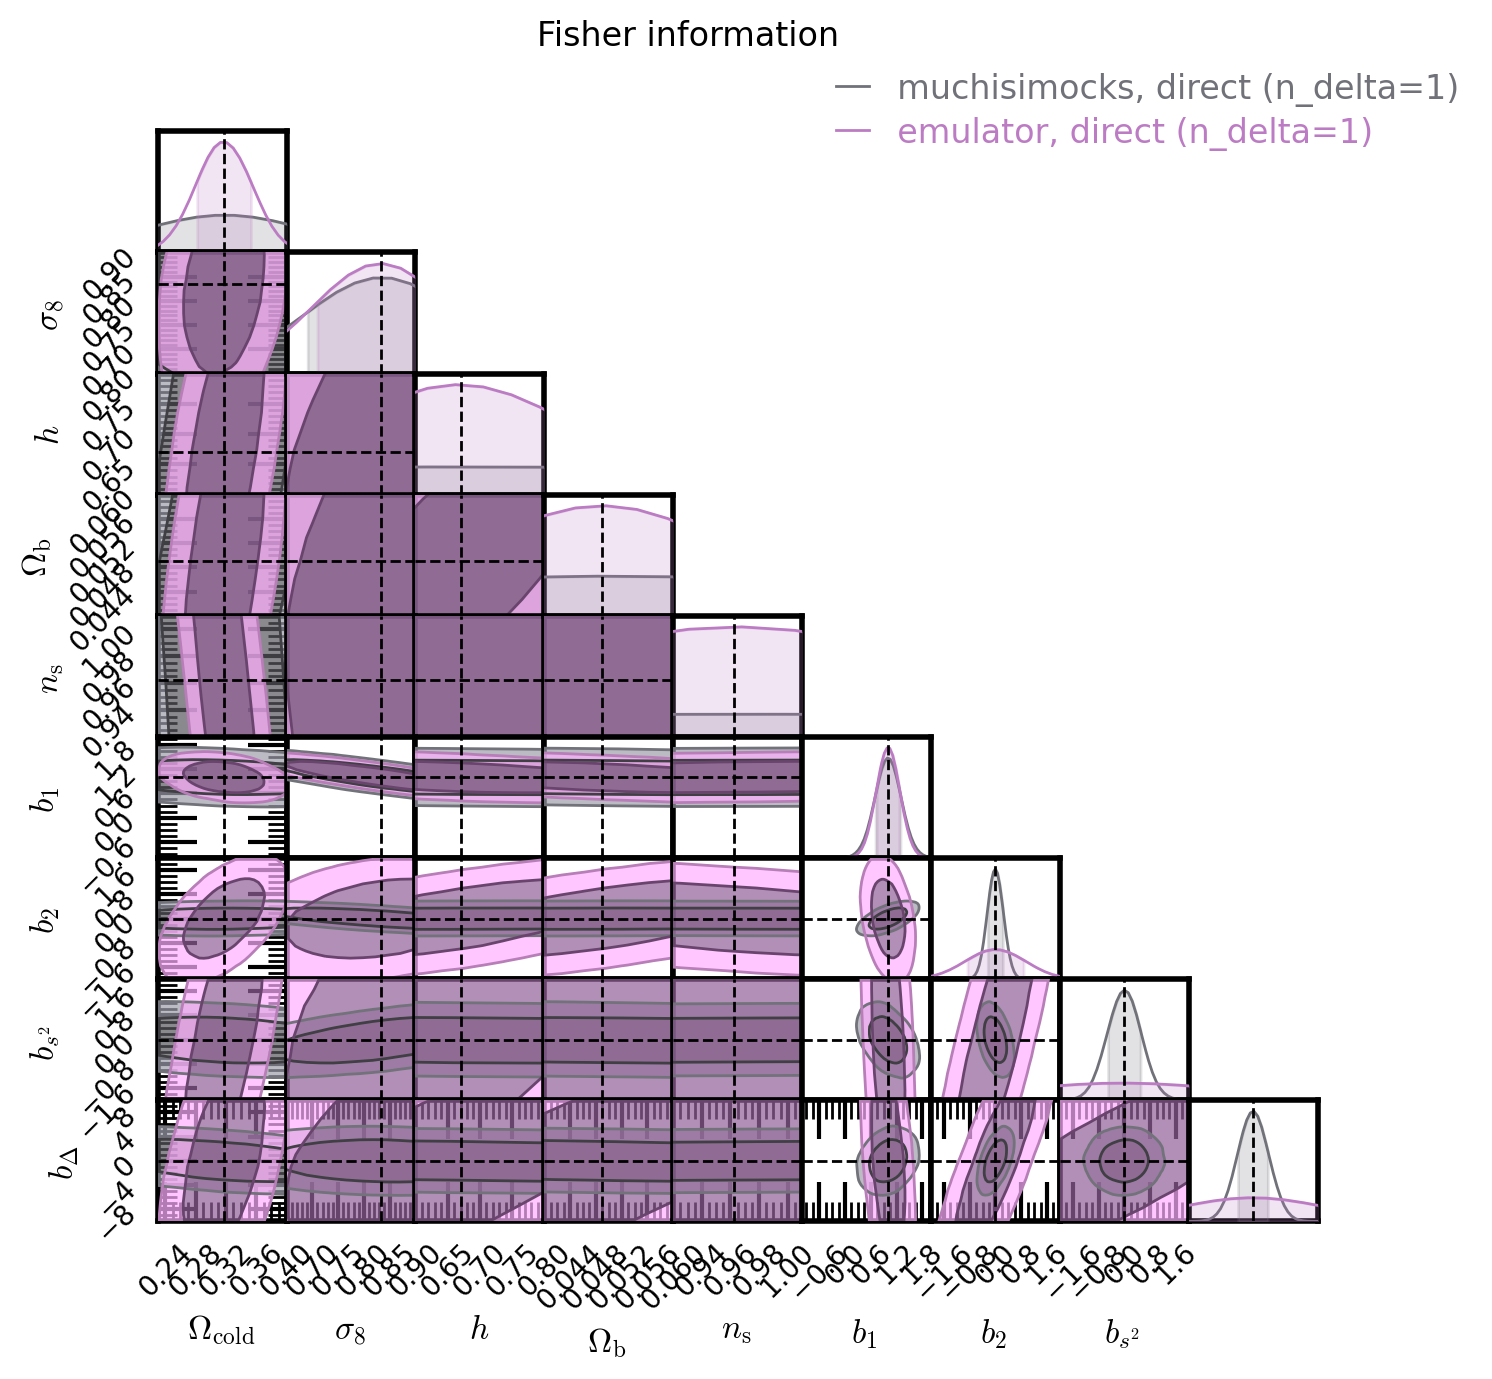

In [84]:

samples_arr = [samples_shift_biaszen_nd1,
               samples_shift_emu_nd1, 
               #samples_shift_biaszen_nd2
               ]
labels = ['muchisimocks, direct (n_delta=1)',
          'emulator, direct (n_delta=1)', 
          #'(n_delta=2)'
        ]
color_emu = '#bc7cc4'
colors = ['gray', color_emu]
smooth_arr = [2]*len(samples_arr)
bins_arr = [10]*len(samples_arr)
title = 'Fisher information'
plotter.plot_contours(samples_arr, labels, colors, utils.param_names_all_ordered, 
                      utils.param_label_dict, 
                  smooth_arr=smooth_arr, bins_arr=bins_arr,
                  truth_loc=params_dict_cv_emu, title=title, extents=extents, 
                  figsize=(7,7), fn_save=None)

### Cosmo only

In [85]:
fisher_matrix_shift_emu_nd1_cosmo = utils.compute_fisher_matrix(derivatives_shift_emu_nd1, cov_fid_emu, utils.cosmo_param_names_ordered)
cov_fisher_shift_emu_nd1_cosmo = np.linalg.inv(fisher_matrix_shift_emu_nd1_cosmo)
print("Fisher matrix shape:", fisher_matrix_shift_emu_nd1_cosmo.shape)

Fisher matrix shape: (5, 5)


In [86]:
n_samples = 10000
samples_shift_emu_nd1_cosmo = np.random.multivariate_normal(theta_fid[:len(utils.cosmo_param_names_ordered)], cov_fisher_shift_emu_nd1_cosmo, size=n_samples)

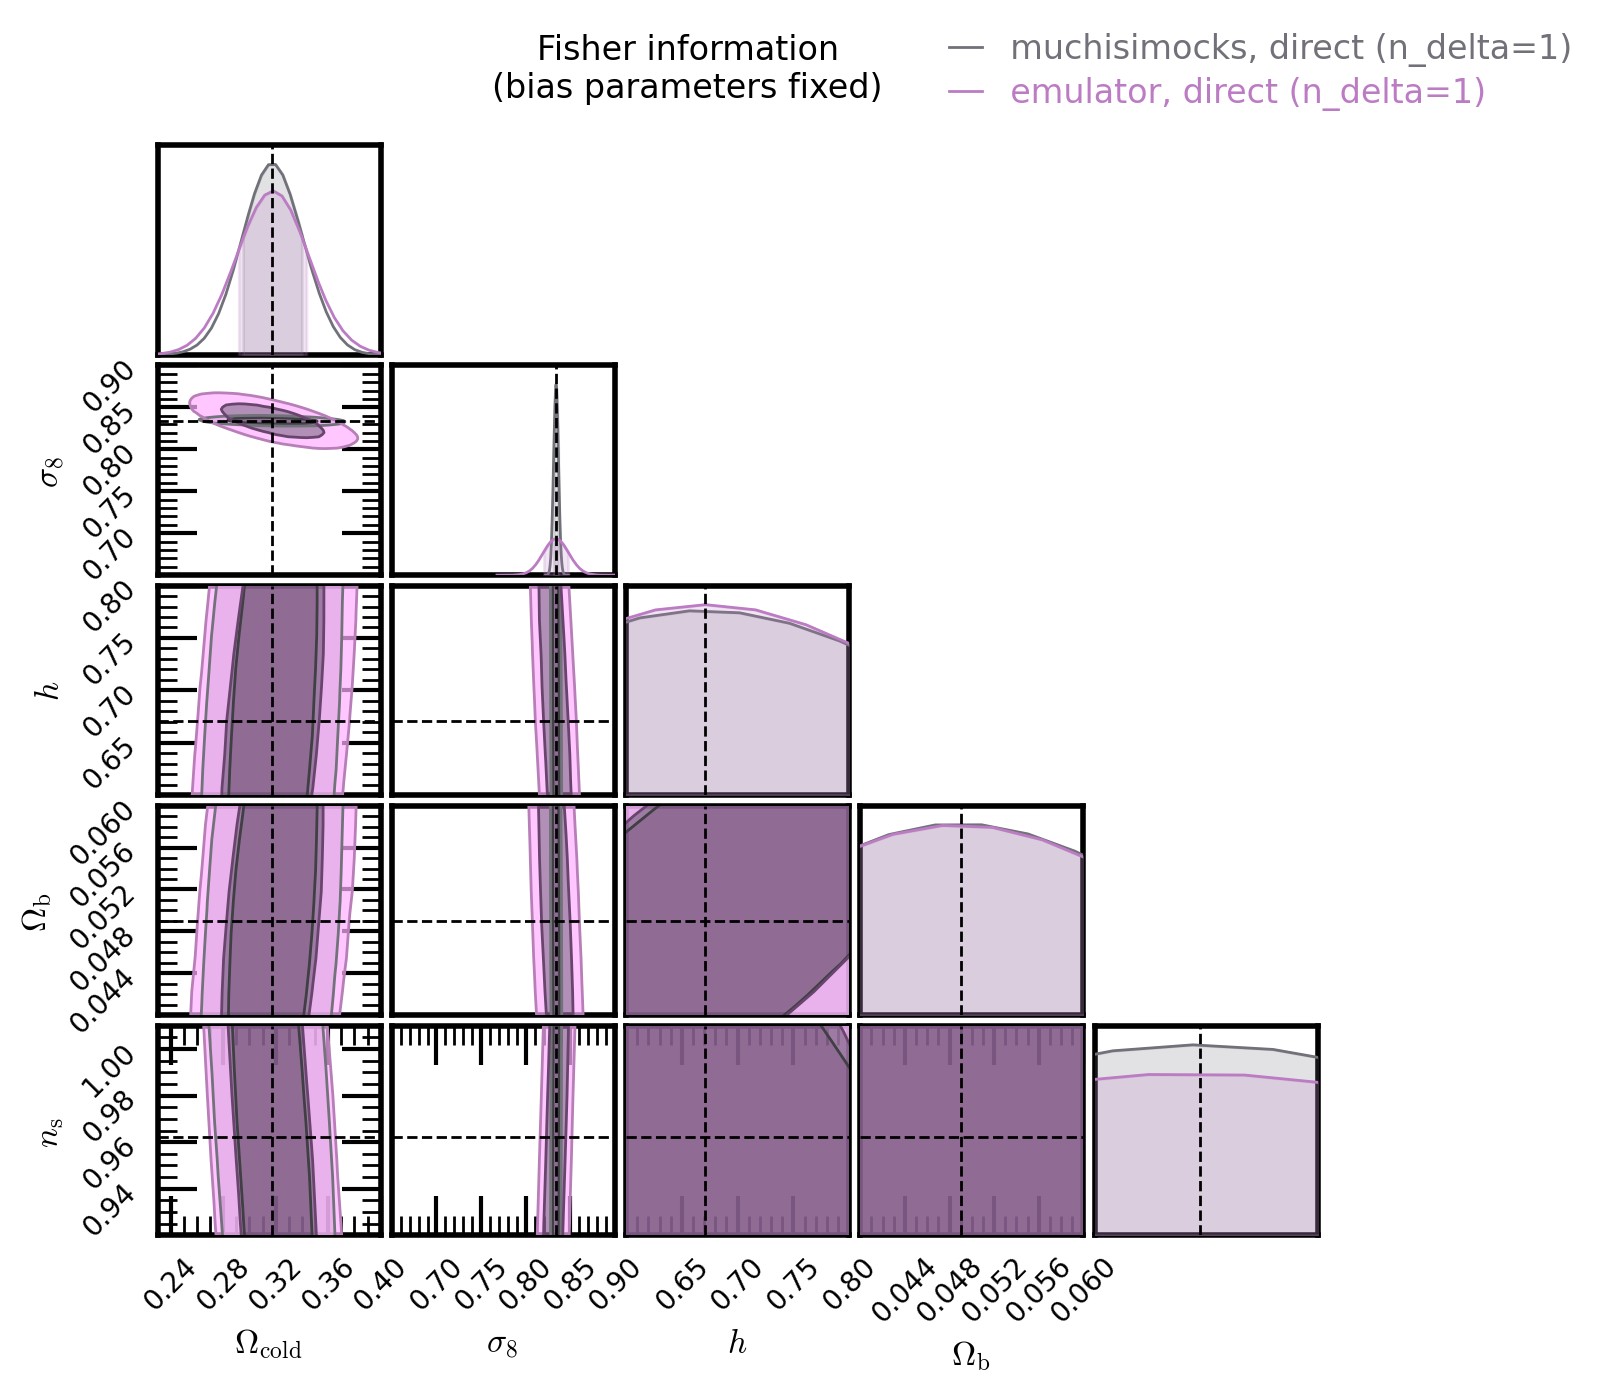

In [87]:

samples_arr = [samples_shift_nd1,
               samples_shift_emu_nd1_cosmo, 
               #samples_shift_biaszen_nd2
               ]
labels = ['muchisimocks, direct (n_delta=1)',
          'emulator, direct (n_delta=1)', 
          #'(n_delta=2)'
        ]
color_emu = '#bc7cc4'
colors = ['gray', color_emu]
smooth_arr = [2]*len(samples_arr)
bins_arr = [10]*len(samples_arr)
title = 'Fisher information\n(bias parameters fixed)'
plotter.plot_contours(samples_arr, labels, colors, utils.cosmo_param_names_ordered, 
                      utils.param_label_dict, 
                  smooth_arr=smooth_arr, bins_arr=bins_arr,
                  truth_loc=params_dict_cv_emu, title=title, extents=extents, 
                  figsize=(7,7), fn_save=None,
                  )

### Bias only

In [88]:
fisher_matrix_shift_emu_nd1_bias = utils.compute_fisher_matrix(derivatives_shift_emu_nd1, cov_fid_emu, utils.biasparam_names_ordered)
cov_fisher_shift_emu_nd1_bias = np.linalg.inv(fisher_matrix_shift_emu_nd1_bias)
print("Fisher matrix shape:", fisher_matrix_shift_emu_nd1_bias.shape)

Fisher matrix shape: (4, 4)


In [89]:
fisher_matrix_shift_nd1_bias = utils.compute_fisher_matrix(derivatives_shift_biaszen_nd1, cov_fid, utils.biasparam_names_ordered)
cov_fisher_shift_nd1_bias = np.linalg.inv(fisher_matrix_shift_nd1_bias)
print("Fisher matrix shape:", fisher_matrix_shift_emu_nd1_bias.shape)

Fisher matrix shape: (4, 4)


In [90]:
n_samples = 10000
theta_fid_bias = [params_dict_cv[param] for param in utils.biasparam_names_ordered]
samples_shift_emu_nd1_bias = np.random.multivariate_normal(theta_fid_bias, cov_fisher_shift_emu_nd1_bias, size=n_samples)

In [91]:
n_samples = 10000
samples_shift_nd1_bias = np.random.multivariate_normal(theta_fid_bias, cov_fisher_shift_nd1_bias, size=n_samples)

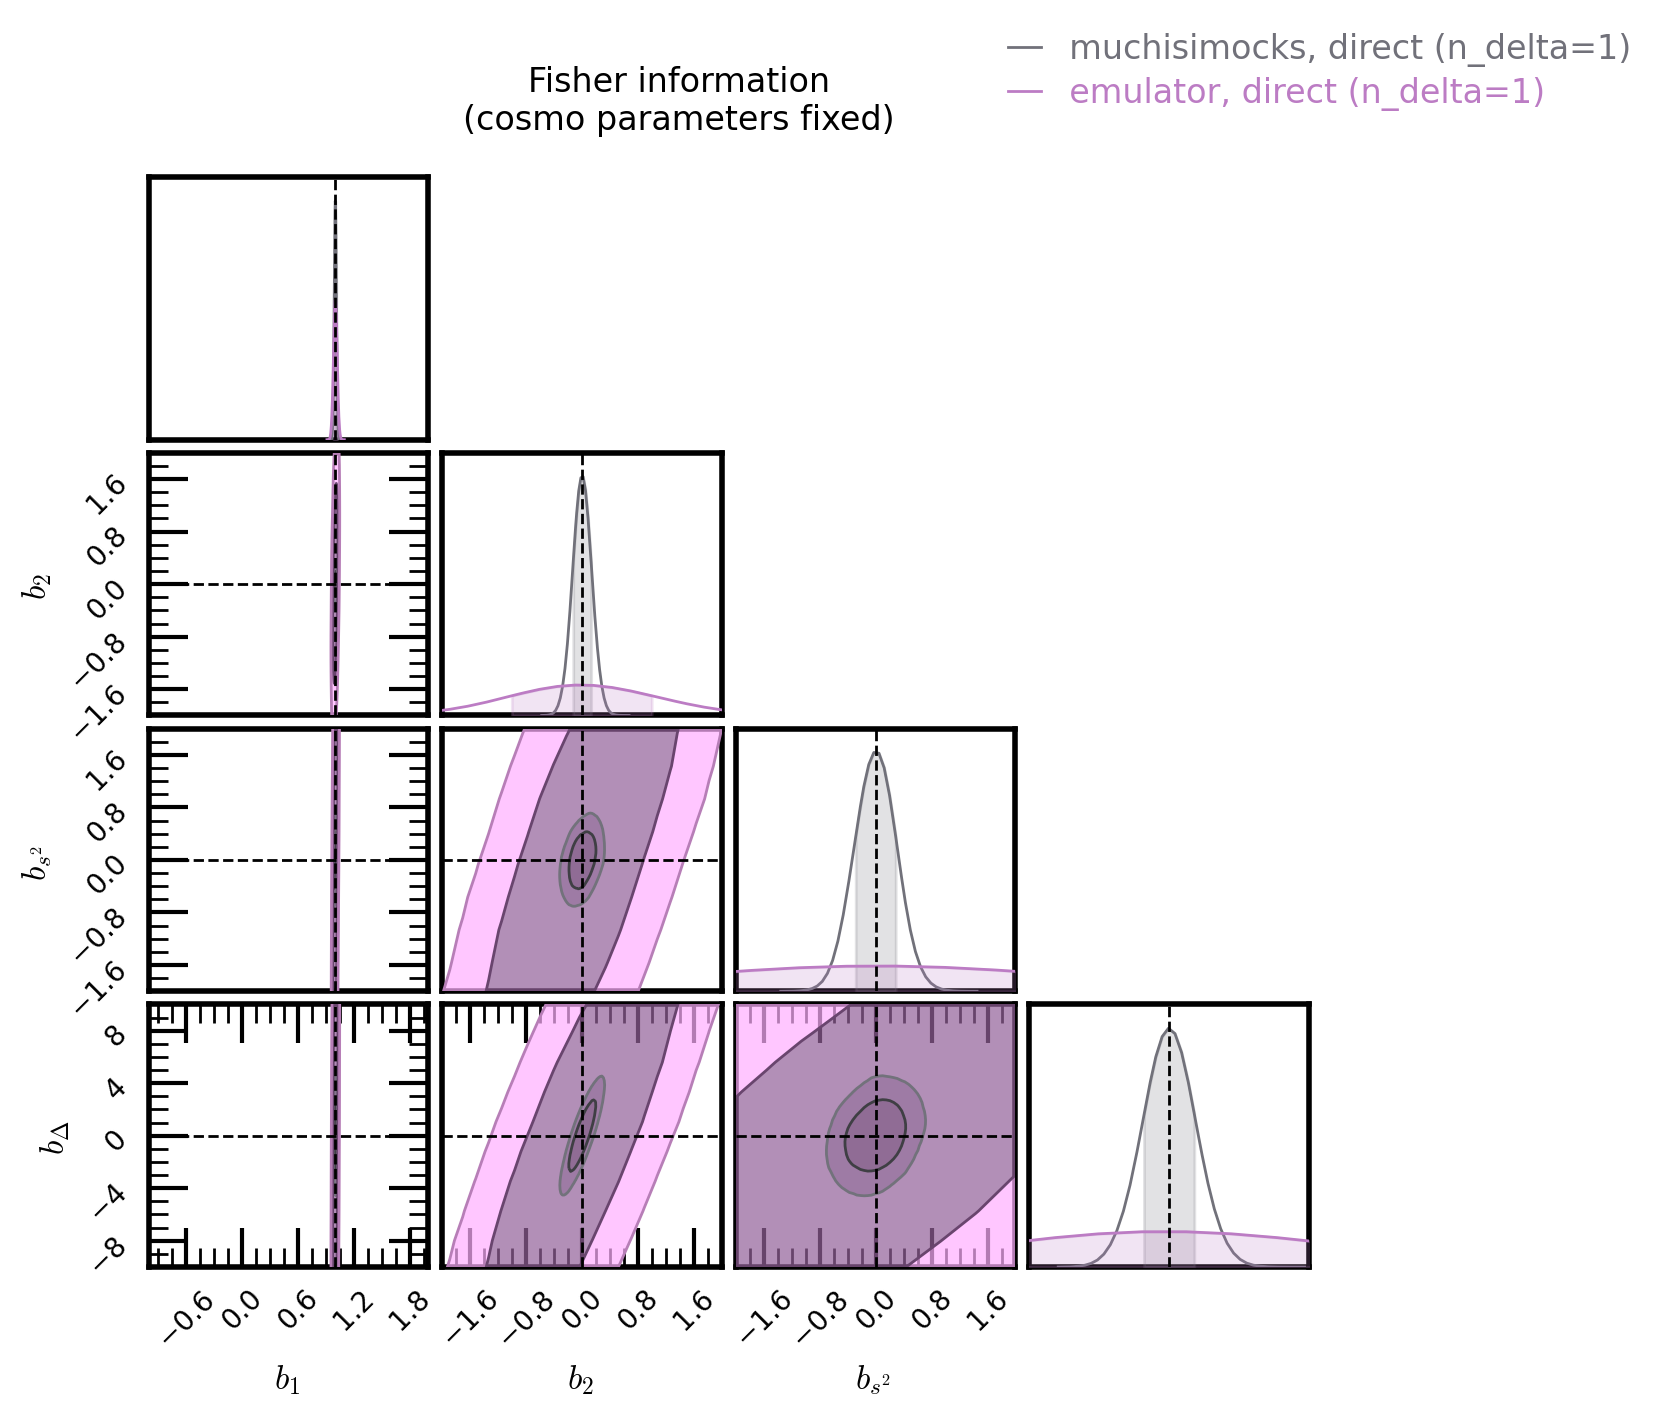

In [92]:

samples_arr = [               samples_shift_nd1_bias, 
               samples_shift_emu_nd1_bias,
               #samples_shift_biaszen_nd2
               ]
labels = ['muchisimocks, direct (n_delta=1)',
          'emulator, direct (n_delta=1)', 
          #'(n_delta=2)'
        ]
color_emu = '#bc7cc4'
colors = ['gray', color_emu]
smooth_arr = [2]*len(samples_arr)
bins_arr = [10]*len(samples_arr)
title = 'Fisher information\n(cosmo parameters fixed)'
plotter.plot_contours(samples_arr, labels, colors, utils.biasparam_names_ordered, 
                      utils.param_label_dict, 
                  smooth_arr=smooth_arr, bins_arr=bins_arr,
                  truth_loc=params_dict_cv_emu, title=title, extents=extents, 
                  figsize=(7,7), fn_save=None,
                  )

### mixing emu and muchisimocks derivs and covs

In [93]:
fisher_matrix_mcov_emuderiv = utils.compute_fisher_matrix(derivatives_shift_emu_nd1, cov_fid, utils.param_names_all_ordered)
cov_fisher_mcov_emuderiv = np.linalg.inv(fisher_matrix_mcov_emuderiv)
print("Fisher matrix shape:", fisher_matrix_mcov_emuderiv.shape)

Fisher matrix shape: (9, 9)


In [94]:
fisher_matrix_emucov_mderiv = utils.compute_fisher_matrix(derivatives_shift_biaszen_nd1, cov_fid_emu_approx, utils.param_names_all_ordered)
cov_fisher_emucov_mderiv = np.linalg.inv(fisher_matrix_emucov_mderiv)
print("Fisher matrix shape:", fisher_matrix_emucov_mderiv.shape)

Fisher matrix shape: (9, 9)


In [95]:
n_samples = 10000
samples_emucov_mderiv = np.random.multivariate_normal(theta_fid, cov_fisher_emucov_mderiv, size=n_samples)

In [96]:
n_samples = 10000
samples_mcov_emuderiv = np.random.multivariate_normal(theta_fid, cov_fisher_mcov_emuderiv, size=n_samples)

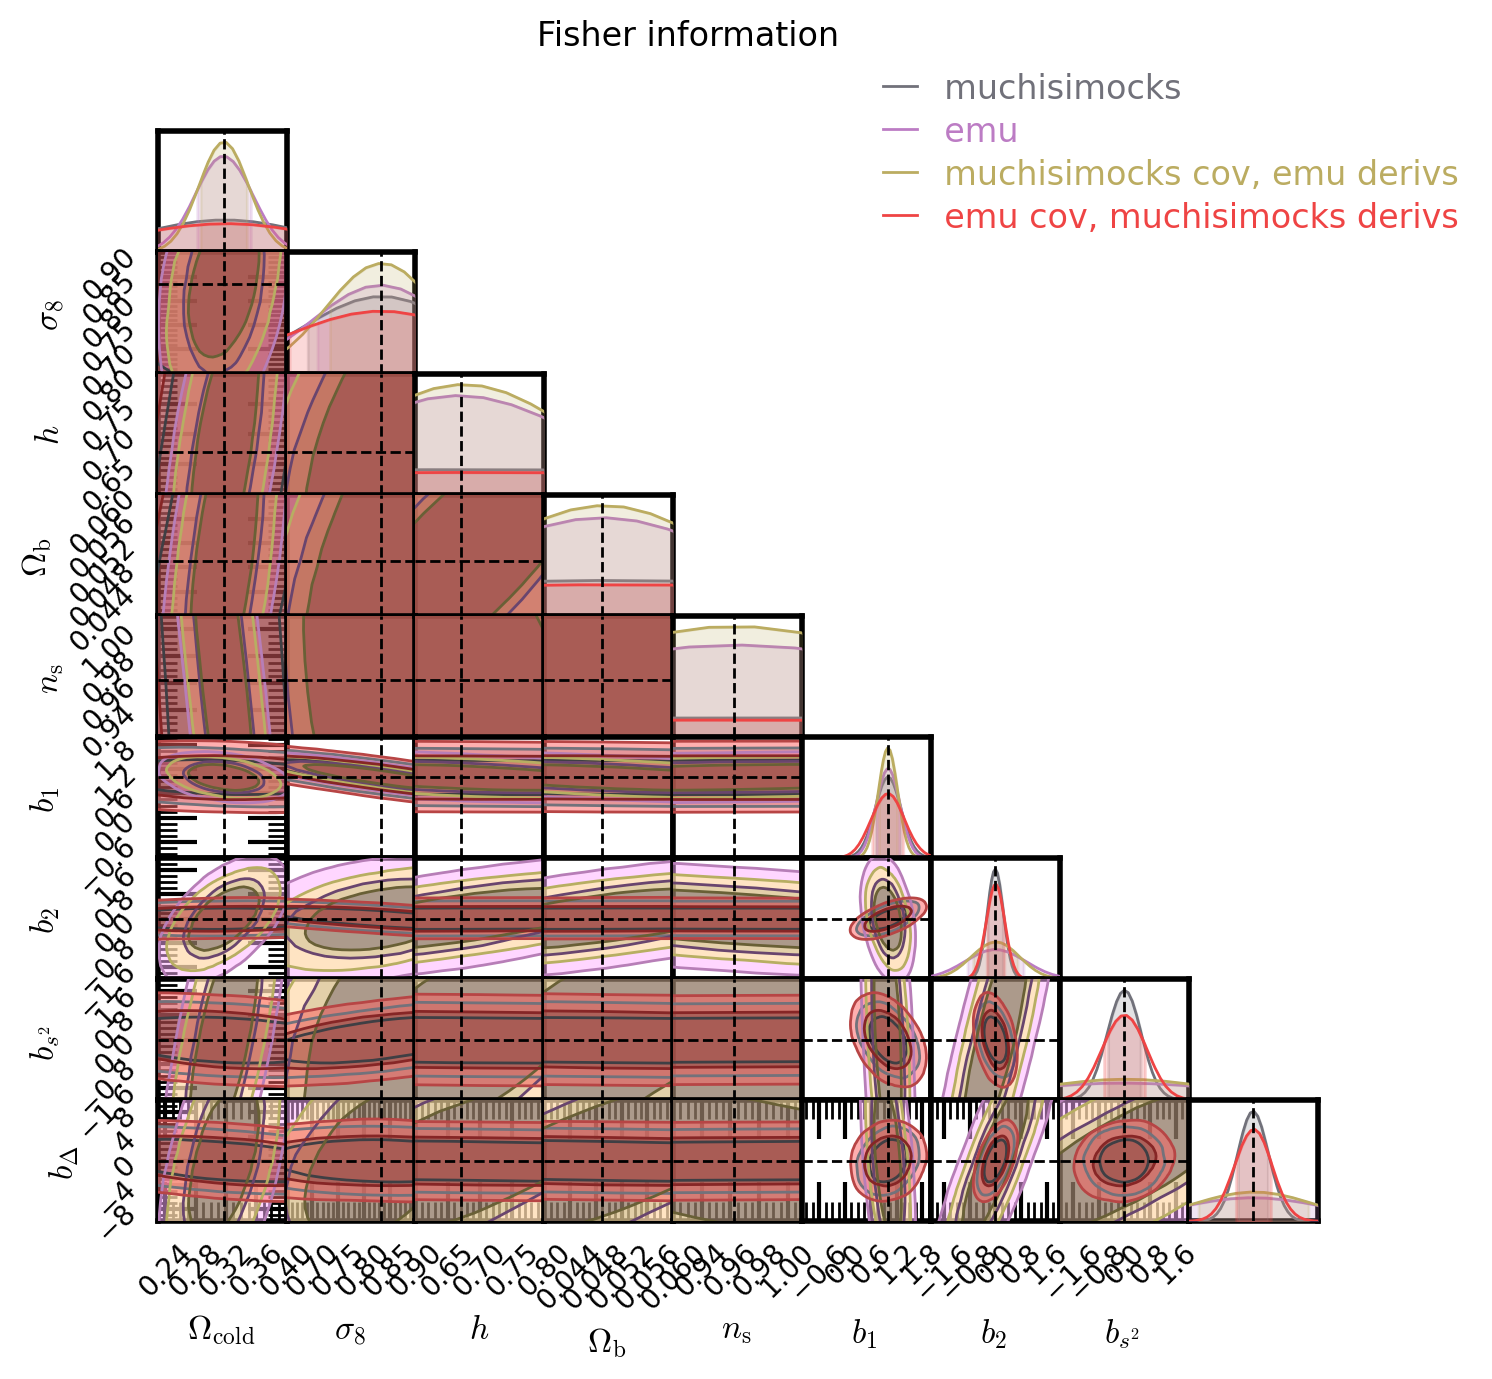

In [97]:

samples_arr = [samples_shift_biaszen_nd1,
               samples_shift_emu_nd1,
               samples_mcov_emuderiv,
               samples_emucov_mderiv, 
               #samples_shift_biaszen_nd2
               ]
labels = ['muchisimocks',
          'emu',
          'muchisimocks cov, emu derivs',
          'emu cov, muchisimocks derivs', 
          #'(n_delta=2)'
        ]
colors = ['gray', color_emu, '#bbac61', 'red']
smooth_arr = [2]*len(samples_arr)
bins_arr = [10]*len(samples_arr)
title = 'Fisher information'
plotter.plot_contours(samples_arr, labels, colors, utils.param_names_all_ordered, 
                      utils.param_label_dict, 
                  smooth_arr=smooth_arr, bins_arr=bins_arr,
                  truth_loc=params_dict_cv_emu, title=title, extents=extents, 
                  figsize=(7,7), fn_save=None)

muchisimocks is similar to emu cov, muchisimocks derivs. so changing the cov doesn't do much
emu is similar to muchisimocks cov, emu derivs. again, changing cov doesn't do much.

muchisimocks differs from muchisimocks cov, emu derivs. so just changing the derivatives changes the fisher info a lot.

So the difference is driven by the _derivatives_!

### mixing emu and muchisimocks covariance parts

In [108]:
corr_fid = cov_fid / np.sqrt(np.outer(np.diag(cov_fid), np.diag(cov_fid)))

corr_fid_emu_approx = cov_fid_emu_approx / np.sqrt(np.outer(np.diag(cov_fid_emu_approx), np.diag(cov_fid_emu_approx)))

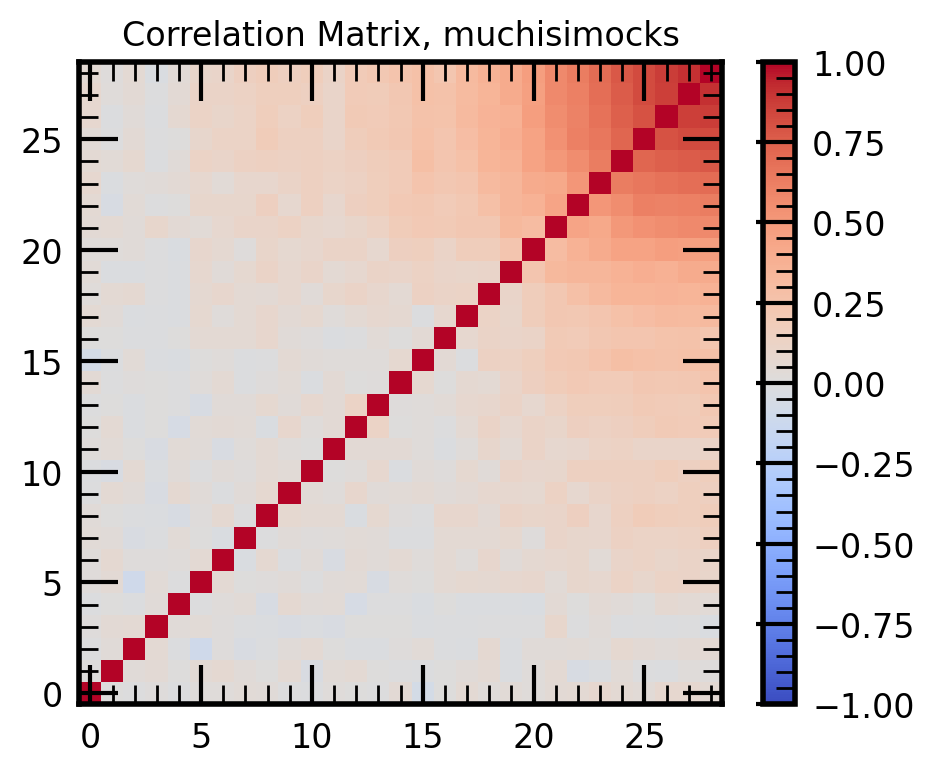

In [110]:
plt.figure(figsize=(6, 4))
im = plt.imshow(corr_fid, cmap='coolwarm', vmin=-1, vmax=1, aspect='equal', origin='lower')
plt.title('Correlation Matrix, muchisimocks', fontsize=12)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

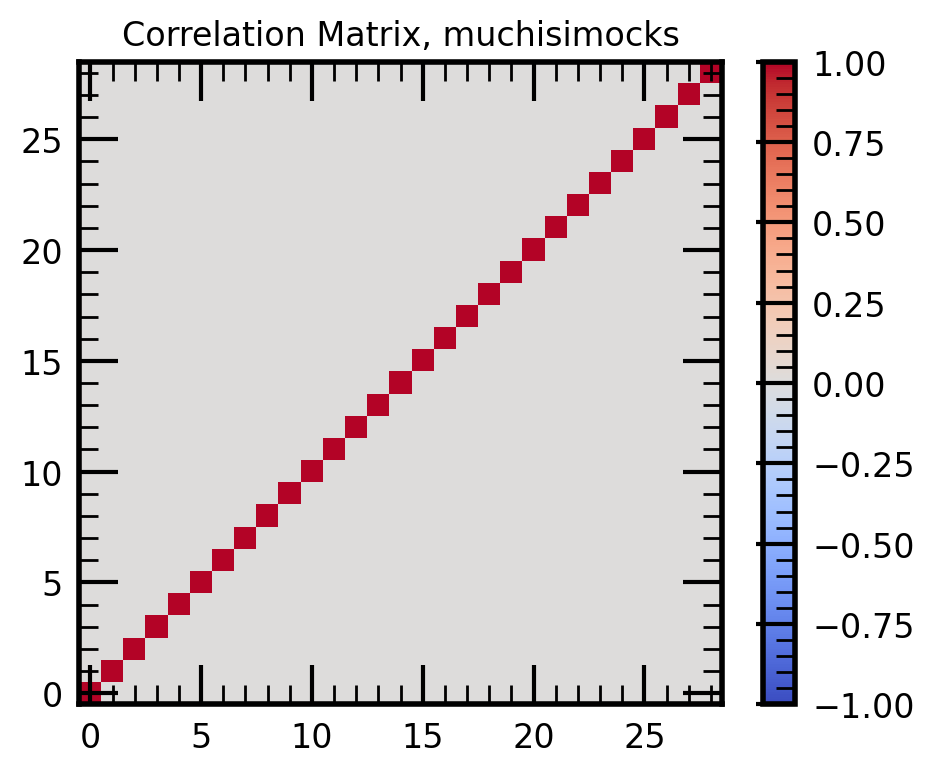

In [ ]:
plt.figure(figsize=(6, 4))
im = plt.imshow(corr_fid_emu_approx, cmap='coolwarm', vmin=-1, vmax=1, aspect='equal', origin='lower')
plt.title('Correlation Matrix, emu', fontsize=12)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

In [111]:
cov_fid_diag = np.diag(np.diag(cov_fid))

In [112]:
fisher_matrix_mcovdiag = utils.compute_fisher_matrix(derivatives_shift_biaszen_nd1, cov_fid_diag, utils.param_names_all_ordered)
cov_fisher_mcovdiag = np.linalg.inv(fisher_matrix_mcovdiag)
print("Fisher matrix shape:", fisher_matrix_mcovdiag.shape)

Fisher matrix shape: (9, 9)


In [113]:
n_samples = 10000
samples_mcovdiag = np.random.multivariate_normal(theta_fid, cov_fisher_mcovdiag, size=n_samples)

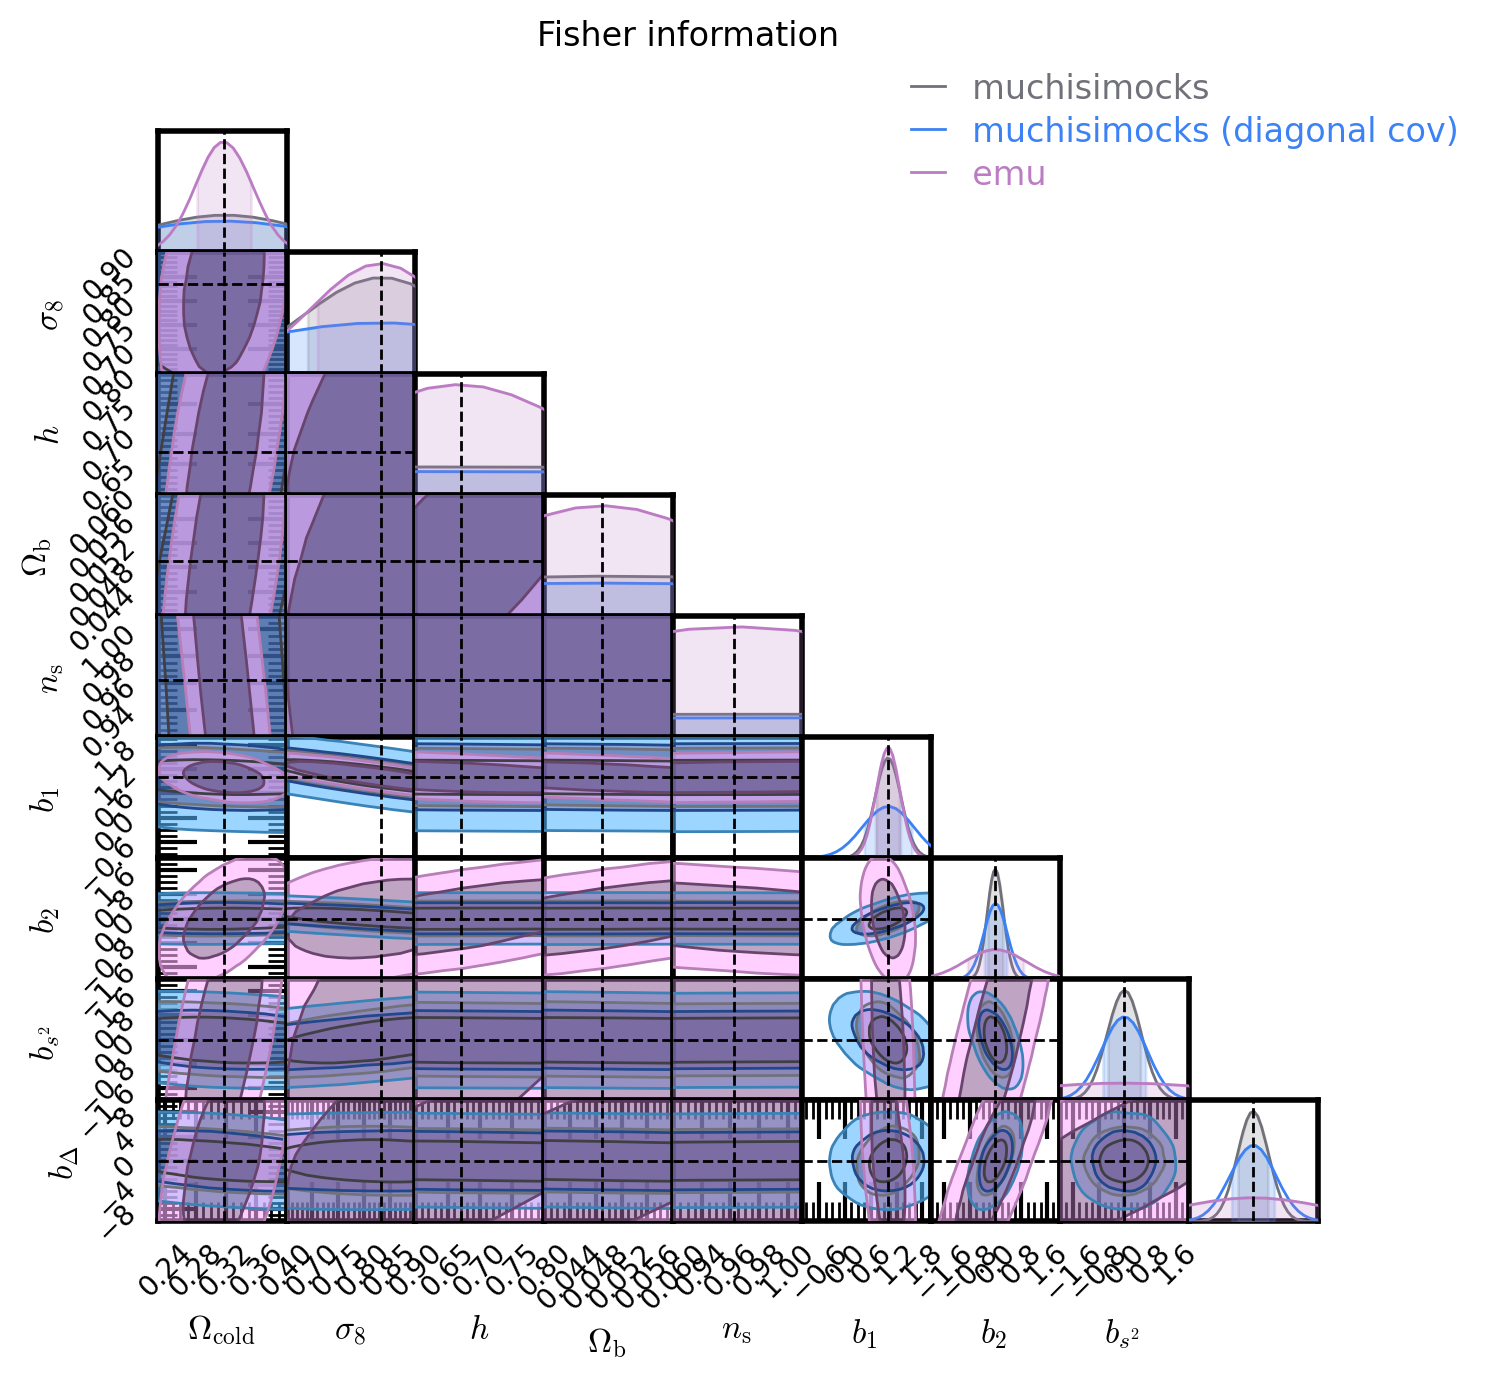

In [115]:

samples_arr = [samples_shift_biaszen_nd1,
               samples_mcovdiag,
               samples_shift_emu_nd1
               ]
labels = ['muchisimocks',
          'muchisimocks (diagonal cov)',
          'emu',
        ]
colors = ['gray', 'blue', color_emu]
smooth_arr = [2]*len(samples_arr)
bins_arr = [10]*len(samples_arr)
title = 'Fisher information'
plotter.plot_contours(samples_arr, labels, colors, utils.param_names_all_ordered, 
                      utils.param_label_dict, 
                  smooth_arr=smooth_arr, bins_arr=bins_arr,
                  truth_loc=params_dict_cv_emu, title=title, extents=extents, 
                  figsize=(7,7), fn_save=None)

### Let's check the effect of the scales:

In [94]:
def cut_scales_from_derivs_and_cov(derivatives_dict, cov, k, k_max):
    mask = k <= k_max
    derivatives_dict_cut = {param: arr[mask] for param, arr in derivatives_dict.items()}
    cov_cut = cov[np.ix_(mask, mask)]
    k_cut = k[mask]
    return derivatives_dict_cut, cov_cut, k_cut

In [95]:

k_max = 0.2

derivatives_shift_kcut, cov_fid_kcut, k_kcut = cut_scales_from_derivs_and_cov(derivatives_shift_biaszen_nd1, cov_fid_emu, k, k_max)
print(cov_fid_kcut.shape)

derivatives_shift_emu_kcut, cov_fid_emu_approx_kcut, k_emu_kcut = cut_scales_from_derivs_and_cov(derivatives_shift_emu_nd1, cov_fid_emu_approx, k_cv, k_max)
print(cov_fid_emu_approx_kcut.shape)


(24, 24)
(24, 24)


In [96]:
fisher_matrix_kcut = utils.compute_fisher_matrix(derivatives_shift_kcut, cov_fid_kcut, utils.param_names_all_ordered)
cov_fisher_kcut = np.linalg.inv(fisher_matrix_kcut)

In [97]:
fisher_matrix_emu_kcut = utils.compute_fisher_matrix(derivatives_shift_emu_kcut, cov_fid_emu_approx_kcut, utils.param_names_all_ordered)
cov_fisher_emu_kcut = np.linalg.inv(fisher_matrix_emu_kcut)

In [98]:
n_samples = 10000
samples_kcut = np.random.multivariate_normal(theta_fid, cov_fisher_kcut, size=n_samples)

In [99]:
n_samples = 10000
samples_emu_kcut = np.random.multivariate_normal(theta_fid, cov_fisher_emu_kcut, size=n_samples)

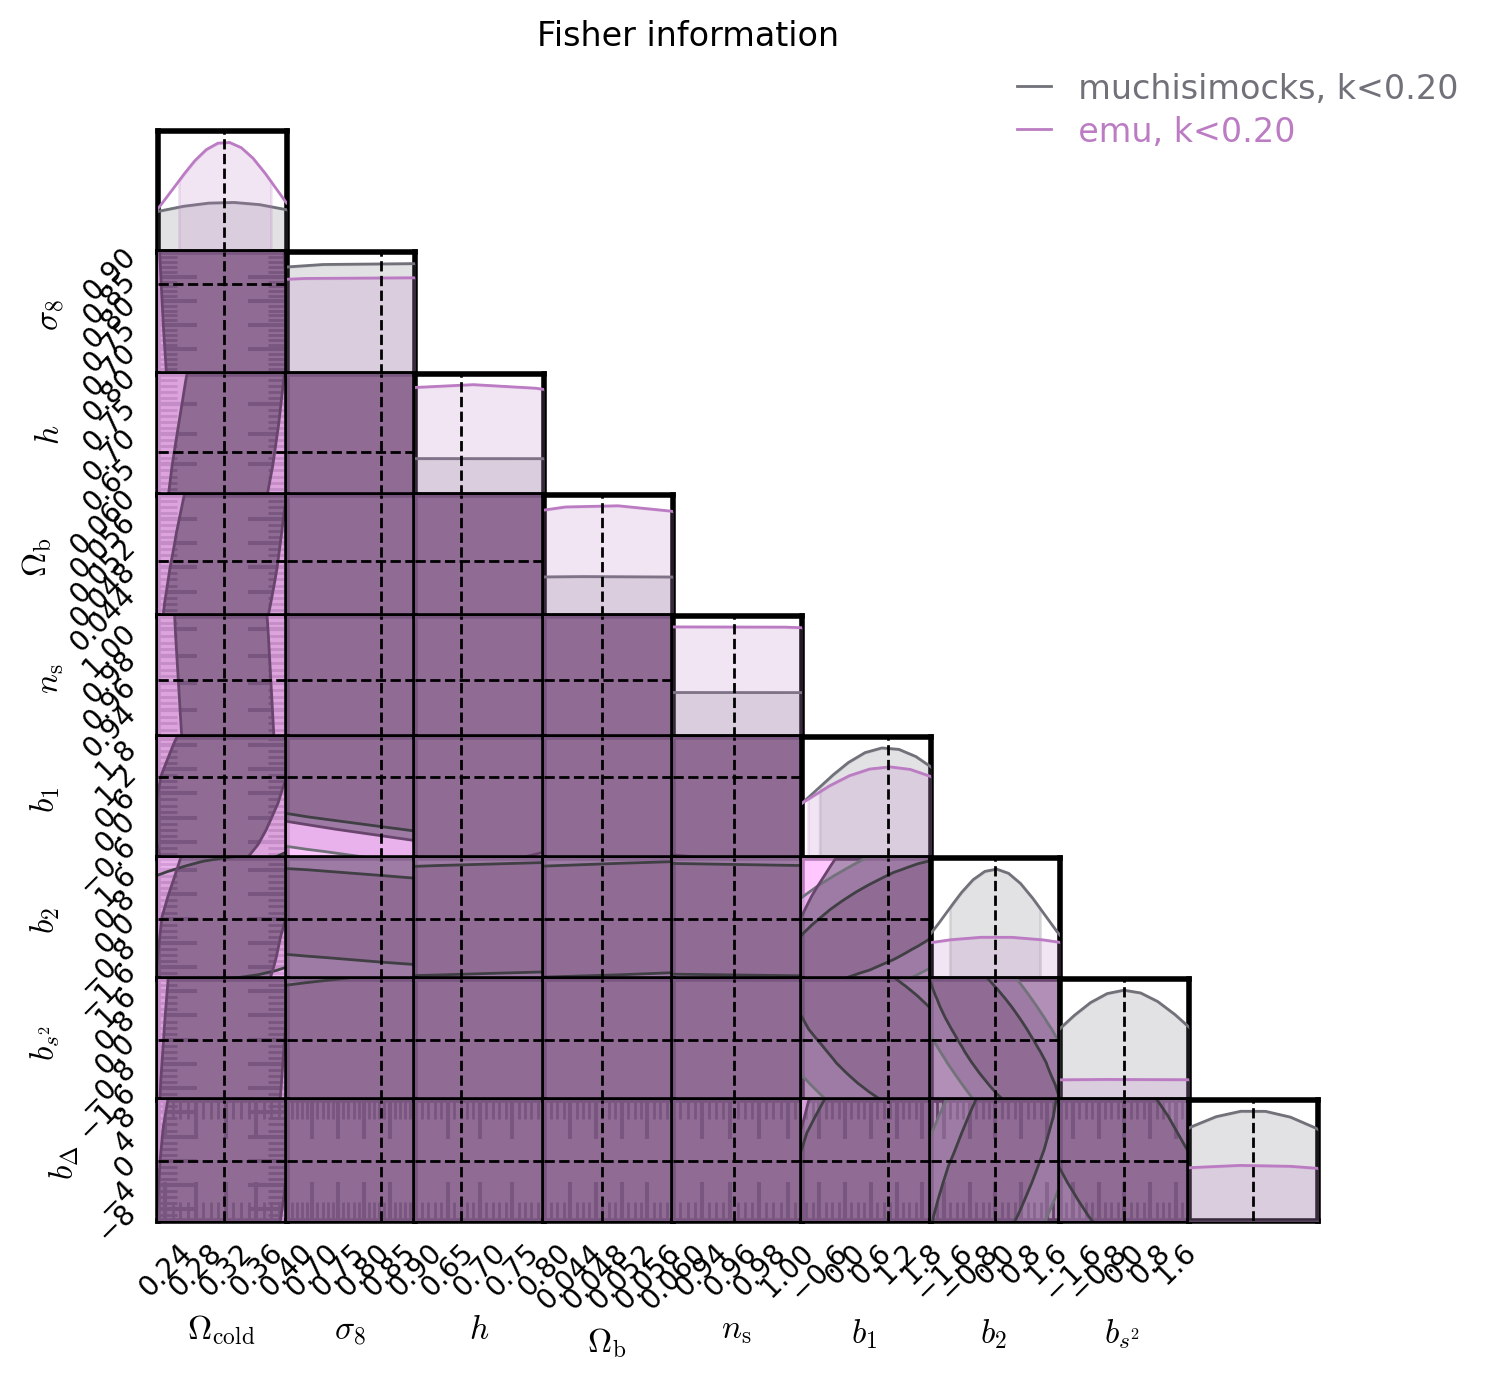

In [100]:

samples_arr = [samples_kcut,
               samples_emu_kcut,
               #samples_shift_biaszen_nd2
               ]
labels = [f'muchisimocks, k<{k_max:.2f}',
          f'emu, k<{k_max:.2f}',
        ]
colors = ['gray', color_emu]
smooth_arr = [2]*len(samples_arr)
bins_arr = [10]*len(samples_arr)
title = 'Fisher information'
plotter.plot_contours(samples_arr, labels, colors, utils.param_names_all_ordered, 
                      utils.param_label_dict, 
                  smooth_arr=smooth_arr, bins_arr=bins_arr,
                  truth_loc=params_dict_cv_emu, title=title, extents=extents, 
                  figsize=(7,7), fn_save=None)

print errors

In [101]:
param_names = utils.param_names_all_ordered
fisher_errors = np.sqrt(np.diag(cov_fisher_shift_biaszen_nd1))

print(f"{'Parameter':<20} {'Fisher 1-sigma error':>20}")
print("-" * 40)
for name, err in zip(param_names, fisher_errors):
    print(f"{name:<20} {err:>20.4e}")

Parameter            Fisher 1-sigma error
----------------------------------------
omega_cold                     9.7225e-02
sigma8_cold                    1.3290e-01
hubble                         6.3898e-01
omega_baryon                   4.9450e-02
ns                             6.7576e-01
b1                             2.7254e-01
b2                             2.1367e-01
bs2                            4.6577e-01
bl                             2.1305e+00


In [102]:
param_names = utils.param_names_all_ordered
fisher_errors = np.sqrt(np.diag(cov_fisher_shift_biaszen_nd1))

print(f"{'Parameter':<20} {'Fisher 1-sigma error':>20}")
print("-" * 40)
for name, err in zip(param_names, fisher_errors):
    print(f"{name:<20} {err:>20.4e}")

Parameter            Fisher 1-sigma error
----------------------------------------
omega_cold                     9.7225e-02
sigma8_cold                    1.3290e-01
hubble                         6.3898e-01
omega_baryon                   4.9450e-02
ns                             6.7576e-01
b1                             2.7254e-01
b2                             2.1367e-01
bs2                            4.6577e-01
bl                             2.1305e+00


### Covariance comparison

In [103]:
y_err_cv_emu

array([[22278.78808086, 20638.59751652, 18804.61549079, ...,
           74.70476145,    58.27826375,    45.63477551],
       [22278.78808086, 20638.59751652, 18804.61549079, ...,
           74.70476145,    58.27826375,    45.63477551],
       [22278.78808086, 20638.59751652, 18804.61549079, ...,
           74.70476145,    58.27826375,    45.63477551],
       ...,
       [22278.78808086, 20638.59751652, 18804.61549079, ...,
           74.70476145,    58.27826375,    45.63477551],
       [22278.78808086, 20638.59751652, 18804.61549079, ...,
           74.70476145,    58.27826375,    45.63477551],
       [22278.78808086, 20638.59751652, 18804.61549079, ...,
           74.70476145,    58.27826375,    45.63477551]])

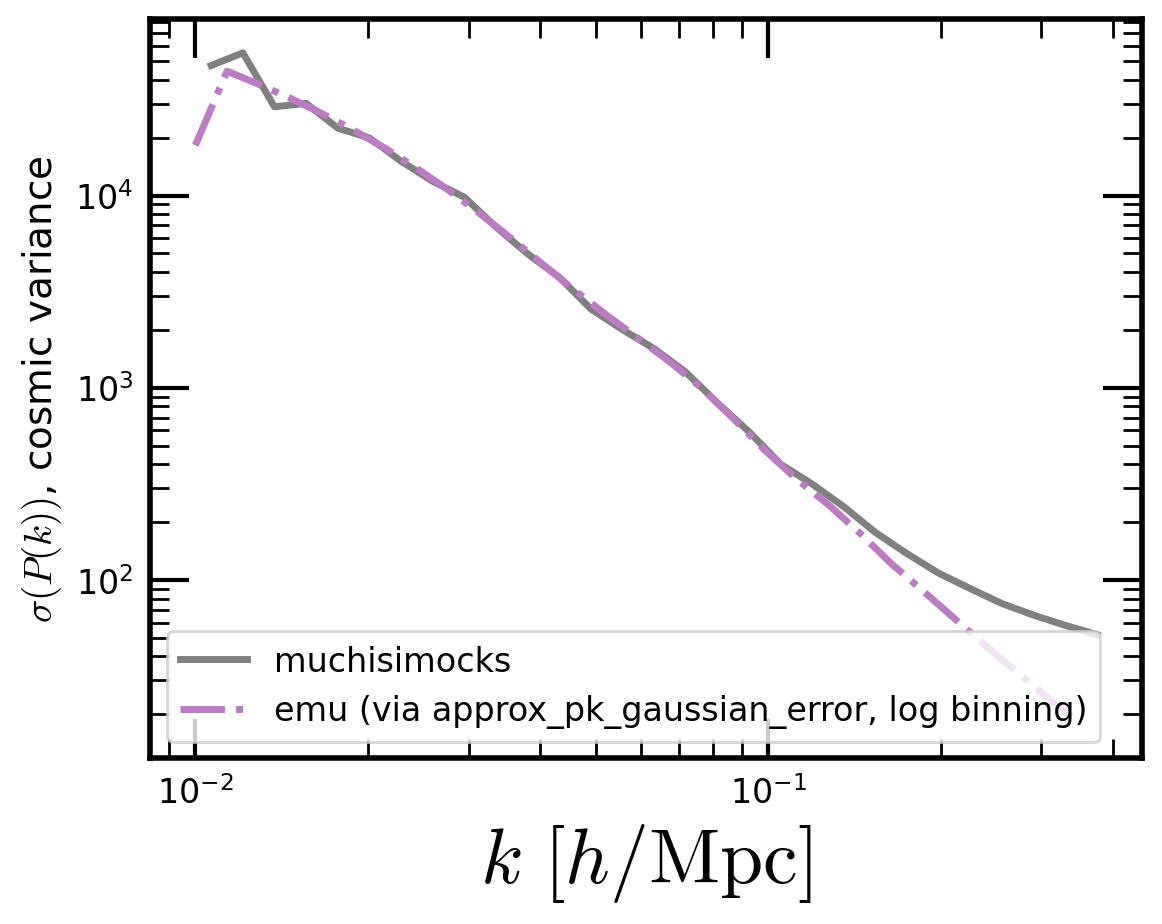

In [104]:
plt.plot(k_biaszen, np.sqrt(np.diag(cov_fid)), color='grey', label='muchisimocks')
#plt.plot(k, np.sqrt(np.diag(cov_fid_emu)), color=color_emu, label='emu (computed from 1000 draws)', alpha=0.6)
#plt.plot(k, y_err_cv_emu[0], color=color_emu, label='emu (via approx_pk_gaussian_error)', ls='--', lw=1.5)
plt.plot(k, np.sqrt(np.diag(cov_fid_emu_approx)), color=color_emu, label='emu (via approx_pk_gaussian_error, log binning)', ls='-.', lw=2.5)

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k\ [h/\mathrm{Mpc}]$')
plt.ylabel(r'$\sigma(P(k))$, cosmic variance', fontsize=14)
plt.legend(fontsize=12)

### Cov of P11 term

Muchisimocks

In [105]:
data_mode = 'muchisimocks'
statistics = ['pk']

tag_params_cv = '_quijote_p0_n1000'
tag_biasparams_cv_b0000 = '_b0000_p0_n1'
tag_datagen = ''
kwargs_data = {
    'tag_datagen': tag_datagen
}

tag_stats = f'_{"_".join(statistics)}'    
tag_data_cv_b0000 = '_'+data_mode + tag_stats + tag_params_cv + tag_biasparams_cv_b0000 + tag_datagen

In [106]:
k_cv_b0000, y_cv_b0000, y_err_cv_b0000, idxs_params_cv_b0000, params_df_cv_b0000, param_dict_fixed_cv_b0000, biasparams_df_cv_b0000, biasparams_dict_fixed_cv_b0000, random_ints_cosmo_cv_b0000, random_ints_bias_cv_b0000 = \
            data_loader.load_data(data_mode, statistics, 
                                    tag_params_cv, tag_biasparams_cv_b0000,
                                    tag_data=tag_data_cv_b0000,
                                    kwargs=kwargs_data)
k_cv_b0000, y_cv_b0000, y_err_cv_b0000 = k_cv_b0000[0], y_cv_b0000[0], y_err_cv_b0000[0]

Loading muchisimocks data
Found 1000 diff cosmo pnns in /scratch/kstoreyf/muchisimocks/data/pnns_mlib/pnns_quijote_p0_n1000
Loaded pk data with shape (1000, 30)
fn_mask: ../data/masks/mask_muchisimocks_pk_quijote_p0_n1000_b0000_p0_n1.txt
Loading from ../data/masks/mask_muchisimocks_pk_quijote_p0_n1000_b0000_p0_n1.txt (already exists)
Masked 1 out of 30 bins


In [107]:
cov_fid_b0000 = np.cov(y_cv_b0000, rowvar=False)
print(cov_fid_b0000.shape)

(29, 29)


Text(0, 0.5, '$P(k)$')

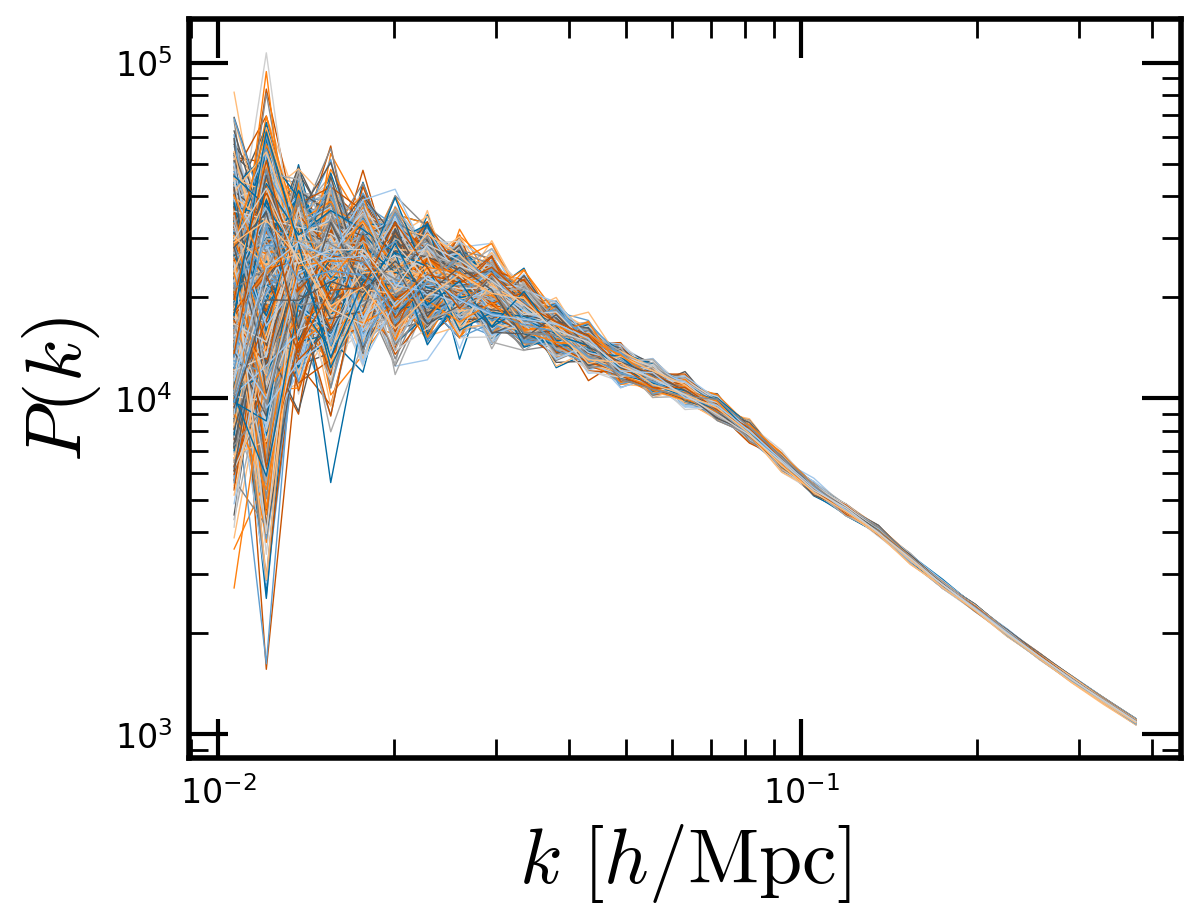

In [108]:
plt.plot(k_cv_b0000, y_cv_b0000.T, lw=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k\ [h/\mathrm{Mpc}]$')
plt.ylabel(r'$P(k)$')

In [109]:
box_size = 1000
y_cv_b0000_mean = y_cv_b0000.mean(axis=0)
bacco.configuration.update({'pknbody' : {'log_binning' : False}})
g_err_b000_mean = bacco.statistics.approx_pk_gaussian_error(k, y_cv_b0000_mean, box_size)

In [110]:
bacco.configuration.update({'pknbody' : {'log_binning' : True}})
g_err_b000_mean_logbinning = bacco.statistics.approx_pk_gaussian_error(k, y_cv_b0000_mean, box_size)

Emu

checked that draws are true to the error, so can just get the error on the pnn

In [111]:
cosmo_params = param_dict_fixed_cv_b0000.copy()
# Some emulators require specific param names, adapt as needed
cosmo_params_emu = {utils.param_name_to_param_name_emu(k): v for k, v in cosmo_params.items()}
cosmo_params_emu['expfactor'] = 1.0
print(cosmo_params_emu)

{'omega_cold': 0.3175, 'sigma8_cold': 0.834, 'hubble': 0.6711, 'omega_baryon': 0.049, 'ns': 0.9624, 'neutrino_mass': 0.0, 'w0': -1.0, 'wa': 0.0, 'expfactor': 1.0}


In [112]:
k_pnn, pnn = emu.get_nonlinear_pnn(k=k_cv_b0000, **cosmo_params_emu)
print(k_pnn.shape, pnn.shape)

(29,) (15, 29)


In [113]:
box_size = 1000
bacco.configuration.update({'pknbody' : {'log_binning' : False}})
g_err = bacco.statistics.approx_pk_gaussian_error(k, pnn[0], box_size)
bacco.configuration.update({'pknbody' : {'log_binning' : True}})
g_err_logbinning = bacco.statistics.approx_pk_gaussian_error(k, pnn[0], box_size)

In [114]:
# data_mode_emu = 'emu'
# statistics = ['pk']

# tag_params = '_quijote_p0_n1000'
# tag_biasparams_b0000 = '_b0000_p0_n1'
# tag_errG = '_boxsize1000'
# n_rlzs_per_cosmo = 1
# tag_noiseless = ''
# #tag_noiseless = '_noiseless' # if use noiseless, set evaluate_mean=False (?)
# tag_datagen = f'{tag_errG}_nrlzs{n_rlzs_per_cosmo}'
# kwargs_data = {'n_rlzs_per_cosmo': n_rlzs_per_cosmo,
#                     'tag_errG': tag_errG,
#                     'tag_datagen': tag_datagen,
#                     'tag_noiseless': tag_noiseless}
    
# tag_stats = f'_{"_".join(statistics)}'    
# tag_data_emu_b0000 = '_'+data_mode_emu + tag_stats + tag_params + tag_biasparams_b0000 + tag_datagen

In [115]:
# k_cv_emu_b0000, y_cv_emu_b0000, y_err_cv_emu_b0000, idxs_params_emu_b0000, params_df_cv_emu_b0000, param_dict_fixed_cv_emu_b0000, biasparams_df_cv_emu_b0000, biasparams_dict_fixed_cv_emu_b0000, random_ints_cosmo_cv_emu_b0000, random_ints_bias_cv_emu_b0000 = \
#             data_loader.load_data(data_mode_emu, statistics, 
#                                     tag_params, tag_biasparams_b0000,
#                                     tag_data=tag_data_b0000,
#                                     kwargs=kwargs_data)
# k_cv_emu_b0000, y_cv_emu_b0000, y_err_cv_emu_b0000 = k_cv_emu_b0000[0], y_cv_emu_b0000[0], y_err_cv_emu_b0000[0]

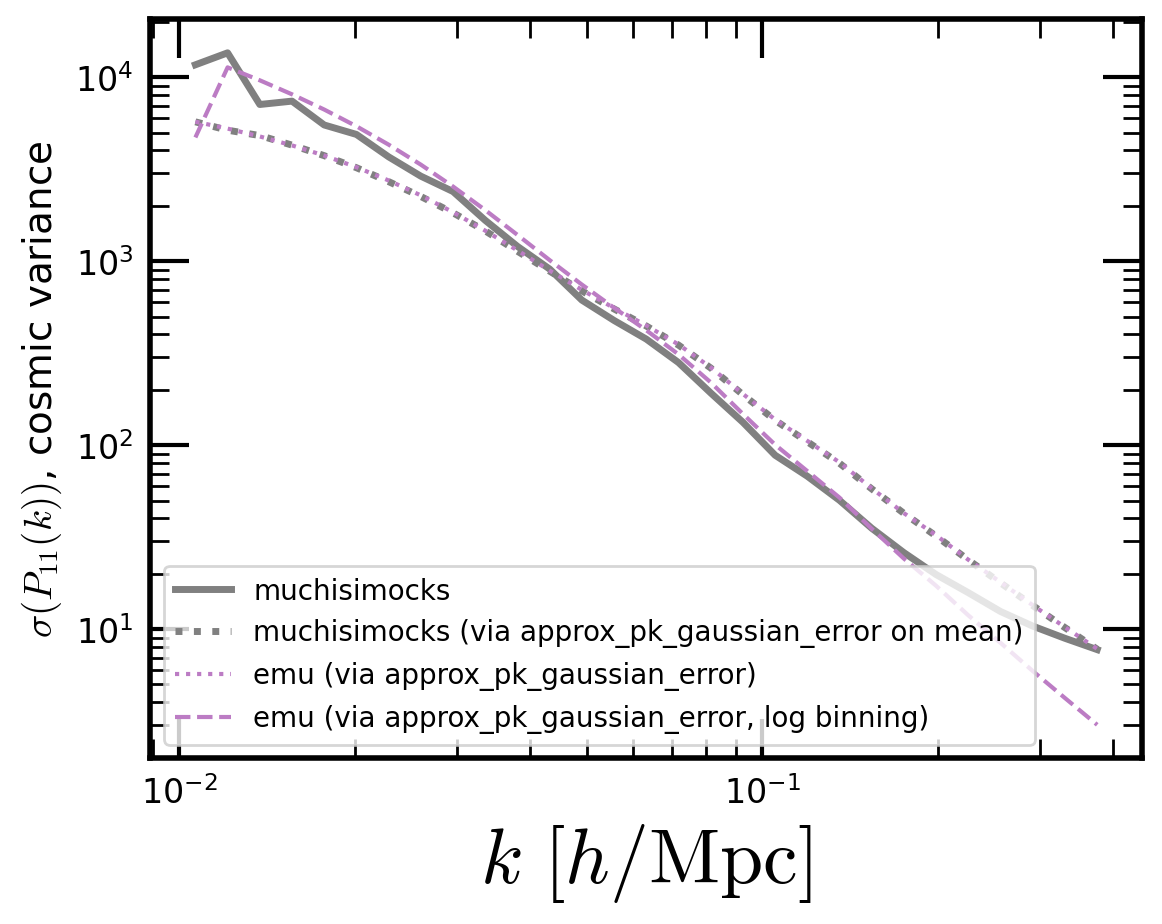

In [116]:
plt.plot(k_cv_b0000, np.sqrt(np.diag(cov_fid_b0000)), color='grey', label='muchisimocks')
#plt.plot(k, np.sqrt(np.diag(cov_fid_emu)), color=color_emu, label='emu (computed from 1000 draws)', alpha=0.6)
plt.plot(k_cv_b0000, g_err_b000_mean, color='grey', label='muchisimocks (via approx_pk_gaussian_error on mean)', ls=':', lw=2.5)

plt.plot(k_pnn, g_err, color=color_emu, label='emu (via approx_pk_gaussian_error)', ls=':', lw=1.5)
plt.plot(k_pnn, g_err_logbinning, color=color_emu, label='emu (via approx_pk_gaussian_error, log binning)', ls='--', lw=1.5)


plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k\ [h/\mathrm{Mpc}]$')
plt.ylabel(r'$\sigma(P_\text{11}(k))$, cosmic variance', fontsize=14)
plt.legend(fontsize=10)

In [117]:
statistic = 'pk'

k_i, y_i, y_err_i, idxs_params, pk_obj_arr = data_loader.load_data_muchisimocks(statistic,
                                            tag_params, tag_biasparams_cv_b0000, **kwargs_data,
                                            return_pk_objs=True)


Loading muchisimocks data
Found 1000 diff cosmo pnns in /scratch/kstoreyf/muchisimocks/data/pnns_mlib/pnns_quijote_p0_n1000


In [118]:
pk_obj = pk_obj_arr[0][0]
pk_obj.keys()

dict_keys(['k', 'pk', 'pk1', 'pk2', 'pk_l2', 'pk_l4', 'pk_theory_lin', 'pk_theory_nl', 'shotnoise', 'nmodes', 'pk_gaussian_error', 'r', 'xi', 'xi1', 'xi2', 'dd', 'theta', 'bispec', 'bispec_im', 'mu', 'p2d', 'p2ds', 'pmulti', 'pmoments', 'pk_jack', 'cov_J'])

In [119]:
mask = data_loader.get_Pk_mask(tag_data_cv_b0000)

fn_mask: ../data/masks/mask_muchisimocks_pk_quijote_p0_n1000_b0000_p0_n1.txt
Loading from ../data/masks/mask_muchisimocks_pk_quijote_p0_n1000_b0000_p0_n1.txt (already exists)


In [120]:
pk_gaussian_error = np.array([pk_obj[0]['pk_gaussian_error'] for pk_obj in pk_obj_arr])
pk_gaussian_error = pk_gaussian_error[:,mask]
pk_gaussian_error.shape

(1000, 29)

In [121]:
import scipy
P_interp = scipy.interpolate.interp1d(k_cv_b0000, y_cv_b0000_mean, bounds_error=False, fill_value='extrapolate')
dk = k_cv_b0000[1]-k_cv_b0000[0]
kf = 2 * np.pi / box_size
Vs = 4*np.pi * np.unique(k_cv_b0000)**2 * dk + np.pi/3 * dk**3
pk_var_theo = 2*kf**3/Vs*(P_interp(k_cv_b0000))**2

Vs_nofincorr = 4*np.pi * np.unique(k_cv_b0000)**2 * dk
pk_var_theo_nofincorr = 2*kf**3/Vs_nofincorr*(P_interp(k_cv_b0000))**2

dk_log = np.concatenate((np.diff(k_cv_b0000), [k_cv_b0000[-1]-k_cv_b0000[-2]]))
Vs_log = 4*np.pi * np.unique(k_cv_b0000)**2 * dk_log + np.pi/3 * dk_log**3
pk_var_theo_log = 2*kf**3/Vs_log*(P_interp(k_cv_b0000))**2

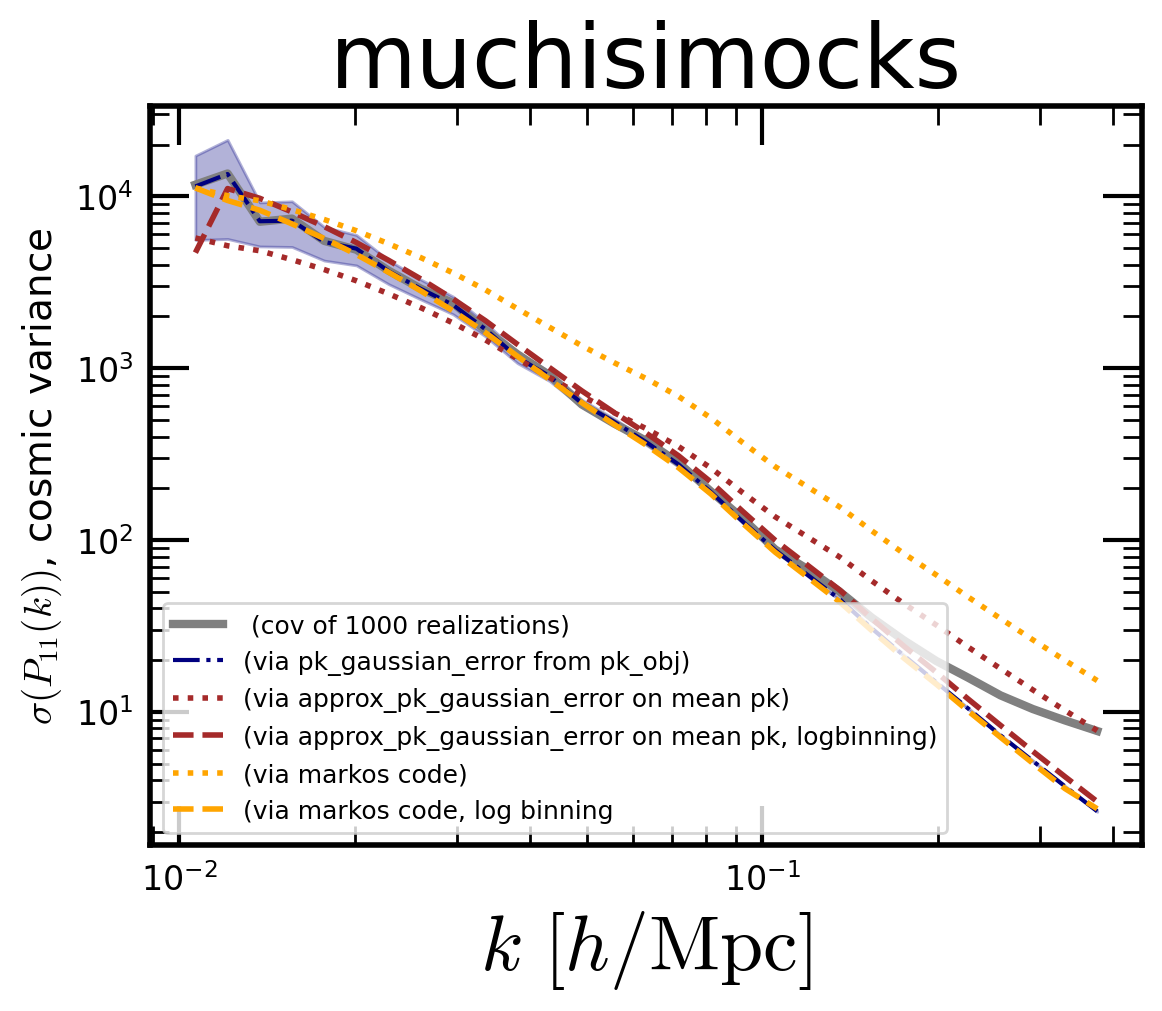

In [122]:
plt.title('muchisimocks')
plt.plot(k_cv_b0000, np.sqrt(np.diag(cov_fid_b0000)), color='grey', label=' (cov of 1000 realizations)', lw=3)
#plt.plot(k, np.sqrt(np.diag(cov_fid_emu)), color=color_emu, label='emu (computed from 1000 draws)', alpha=0.6)
mean_pk_gaussian_error = np.mean(pk_gaussian_error, axis=0)
std_pk_gaussian_error = np.std(pk_gaussian_error, axis=0)
plt.plot(k_cv_b0000, mean_pk_gaussian_error, color='navy', label='(via pk_gaussian_error from pk_obj)', ls='-.', lw=1.5)
plt.fill_between(
    k_cv_b0000,
    mean_pk_gaussian_error - std_pk_gaussian_error,
    mean_pk_gaussian_error + std_pk_gaussian_error,
    color='navy',
    alpha=0.3,
)

plt.plot(k_cv_b0000, g_err_b000_mean, color='brown', label='(via approx_pk_gaussian_error on mean pk)', ls=':', lw=2)
plt.plot(k_cv_b0000, g_err_b000_mean_logbinning, color='brown', label='(via approx_pk_gaussian_error on mean pk, logbinning)', ls='--', lw=2)

plt.plot(k_cv_b0000, np.sqrt(pk_var_theo), color='orange', label='(via markos code)', ls=':', lw=2)
plt.plot(k_cv_b0000, np.sqrt(pk_var_theo_log), color='orange', label='(via markos code, log binning', ls='--', lw=2)
#plt.plot(k_cv_b0000, np.sqrt(pk_var_theo_nofincorr), color='orange', label='(via markos code, no pi/3*dk^3 term)', ls=':', lw=1.5)


#plt.plot(k_pnn, g_err, color=color_emu, label='emu (via approx_pk_gaussian_error)', ls='--', lw=1.5)


plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k\ [h/\mathrm{Mpc}]$')
plt.ylabel(r'$\sigma(P_\text{11}(k))$, cosmic variance', fontsize=14)
plt.legend(fontsize=9)

In [123]:
nmodes_actual = np.array([pk_obj[0]['nmodes'] for pk_obj in pk_obj_arr])
nmodes_actual = nmodes_actual[:,mask]
nmodes_actual.shape

(1000, 29)

In [124]:
bacco.configuration.update({'pknbody' : {'log_binning' : False}})
nmodes_approx = bacco.statistics.approx_number_k_modes(k_cv_b0000, box_size)
nmodes_approx.shape, nmodes_approx

((29,),
 array([3.61487696e+01, 4.66208744e+01, 6.01266919e+01, 7.75450724e+01,
        1.00009464e+02, 1.28981670e+02, 1.66346969e+02, 2.14536794e+02,
        2.76686954e+02, 3.56841682e+02, 4.60216805e+02, 5.93539147e+02,
        7.65484258e+02, 9.87240946e+02, 1.27323936e+03, 1.64208998e+03,
        2.11779464e+03, 2.73130840e+03, 3.52255381e+03, 4.54301877e+03,
        5.85910697e+03, 7.55645886e+03, 9.74552450e+03, 1.25687507e+04,
        1.62098505e+04, 2.09057573e+04, 2.69620431e+04, 3.47728026e+04,
        4.48462971e+04]))

In [125]:
bacco.configuration.update({'pknbody' : {'log_binning' : True}})
nmodes_approx_logbinning = bacco.statistics.approx_number_k_modes(k_cv_b0000, box_size)
nmodes_approx_logbinning.shape, nmodes_approx_logbinning

((29,),
 array([5.71522645e+01, 1.07258862e+01, 1.57095422e+01, 2.30087949e+01,
        3.36995589e+01, 4.93576597e+01, 7.22911115e+01, 1.05880320e+02,
        1.55076356e+02, 2.27130748e+02, 3.32664359e+02, 4.87232913e+02,
        7.13619914e+02, 1.04519495e+03, 1.53083240e+03, 2.24211554e+03,
        3.28388797e+03, 4.80970761e+03, 7.04448127e+03, 1.03176160e+04,
        1.51115741e+04, 2.21329880e+04, 3.24168186e+04, 4.74789094e+04,
        6.95394221e+04, 1.01850091e+05, 1.49173529e+05, 2.18485242e+05,
        3.20001821e+05]))

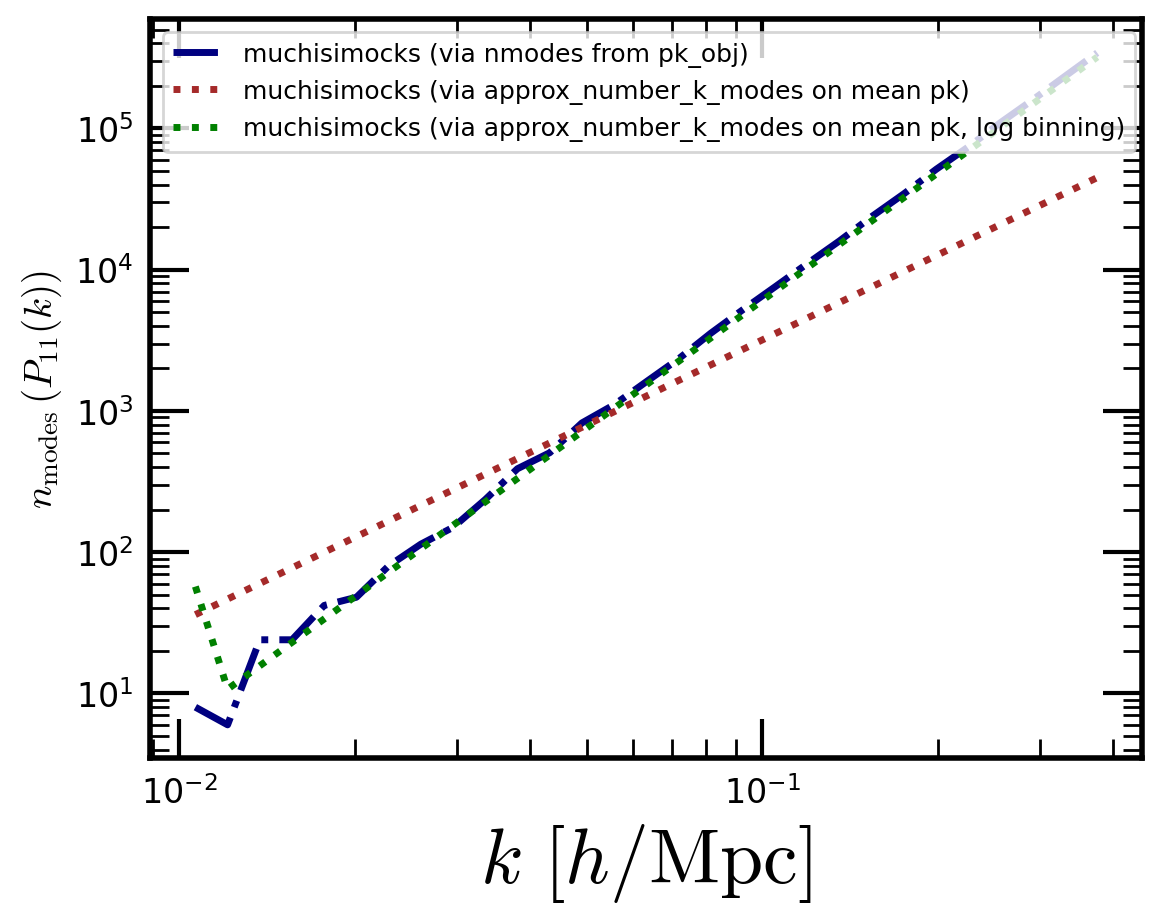

In [126]:
#plt.plot(k_cv_b0000, np.sqrt(np.diag(cov_fid_b0000)), color='grey', label='muchisimocks (cov of 1000 realizations)')
#plt.plot(k, np.sqrt(np.diag(cov_fid_emu)), color=color_emu, label='emu (computed from 1000 draws)', alpha=0.6)
mean_nmodes = np.mean(nmodes_actual, axis=0)
std_nmodes = np.std(nmodes_actual, axis=0)
plt.plot(k_cv_b0000, mean_nmodes, color='navy', label='muchisimocks (via nmodes from pk_obj)', ls='-.', lw=2.5)
# plt.fill_between(
#     k_cv_b0000,
#     mean_nmodes - std_nmodes,
#     mean_nmodes + std_nmodes,
#     color='navy',
#     alpha=0.3,
# )

plt.plot(k_cv_b0000, nmodes_approx, color='brown', label='muchisimocks (via approx_number_k_modes on mean pk)', ls=':', lw=2.5)
plt.plot(k_cv_b0000, nmodes_approx_logbinning, color='green', label='muchisimocks (via approx_number_k_modes on mean pk, log binning)', ls=':', lw=2.5)


#plt.plot(k_pnn, g_err, color=color_emu, label='emu (via approx_pk_gaussian_error)', ls='--', lw=1.5)


plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k\ [h/\mathrm{Mpc}]$')
plt.ylabel(r'$n_\text{modes} \, (P_\text{11}(k))$', fontsize=14)
plt.legend(fontsize=9, loc='upper left')

# Pklin

Try one to check

In [127]:
# Example: Load a pk object for a single idx_LH
import numpy as np

idx_LH = 0  # choose your index
statistic = 'pnn'
tag_params_cv = '_quijote_p0_n1000'
dir_statistics = f'/scratch/kstoreyf/muchisimocks/data/{statistic}s_mlib/{statistic}s{tag_params_cv}'
fn_stat = f'{dir_statistics}/{statistic}_{idx_LH}.npy'
pnn_obj = np.load(fn_stat, allow_pickle=True)
pk_b0000 = utils.pnn_to_pk(pnn_obj, bias_params=[0,0,0,0])

In [128]:
#import bacco
# Load the parameter DataFrames using the tags
params_df, param_dict_fixed = data_loader.load_cosmo_params(tag_params)
param_dict = param_dict_fixed.copy()

# Create and set up the bacco cosmology object
cosmo = utils.get_cosmo(param_dict)

# Compute the linear power spectrum at z=0 for the k values in pk_obj
k_vals = pk_obj['k']
pk_lin = cosmo.get_powerspec_z(wavemode=k_vals, expfactor=1.0, bias=1.0)

k_tab = cosmo._tabPowerSpectrum_z0['x']
pk_lin_tab = cosmo._tabPowerSpectrum_z0['y']


In [129]:
fn_stat = f'/scratch/kstoreyf/muchisimocks/data/pklins_mlib/pklins_quijote_p0_n1000/pklin_{idx_LH}.npy'
pklin_obj = np.load(fn_stat, allow_pickle=True).item()

(100.0, 500000.0)

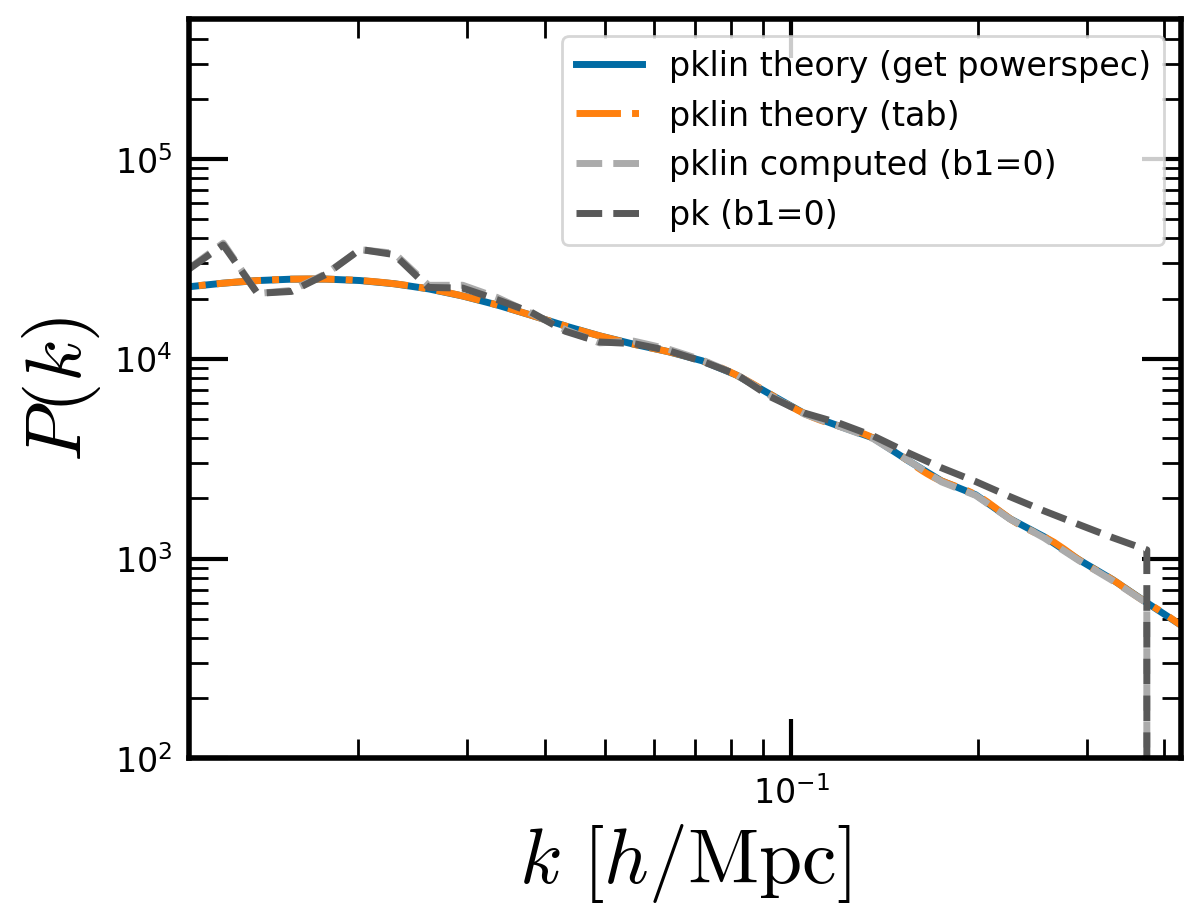

In [130]:

plt.plot(k_vals, pk_lin, label='pklin theory (get powerspec)')
plt.plot(k_tab, pk_lin_tab, label='pklin theory (tab)', ls='-.')
plt.plot(pklin_obj['k'], pklin_obj['pk'], label='pklin computed (b1=0)', ls='--')
plt.plot(k_vals, pk_b0000, label='pk (b1=0)', ls='--')

plt.legend(fontsize=12)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k\ [h/\mathrm{Mpc}]$')
plt.ylabel(r'$P(k)$')
plt.xlim(np.min(k_vals), np.max(k_vals))
plt.ylim(1e2, 5e5)

In [131]:
def compute_pklins(params_all_df, param_dict_fixed, k_vals):
    pks = []
    for _, row in params_all_df.iterrows():
        # Build parameter dicts
        cosmo_params = {pn: row[pn] for pn in utils.cosmo_param_names_ordered}
        cosmo_params.update(param_dict_fixed)
        cosmo = utils.get_cosmo(cosmo_params)

        # Compute the linear power spectrum at z=0 for the k values in pk_obj
        pk_lin = cosmo.get_powerspec_z(wavemode=k_vals, expfactor=1.0, bias=1.0)
        pks.append(pk_lin)
        
    return np.array(pks)

In [132]:
pks_lin = compute_pklins(params_df_biaszen, param_dict_fixed_biaszen, k_biaszen)
pks_lin.shape

(21, 29)

In [133]:
i_fid = np.where(params_df_biaszen['param_shifted']=='fiducial')[0][0]
pk_lin_fid = pks_lin[i_fid]
bacco.configuration.update({'pknbody' : {'log_binning' : True}})
err_pklin = bacco.statistics.approx_pk_gaussian_error(k_biaszen, pk_lin_fid, box_size)
cov_fid_pklin = np.diag(err_pklin**2)
print(cov_fid_pklin.shape)

(29, 29)


In [134]:
derivatives_pklin_nd1 = compute_derivatives_from_fisherset(params_df_biaszen, pks_lin, 
                        utils.cosmo_param_names_ordered, n_deltas_for_diff=1)

In [135]:
derivatives_pklin_nd2 = compute_derivatives_from_fisherset(params_df_biaszen, pks_lin, 
                        utils.cosmo_param_names_ordered, n_deltas_for_diff=2)

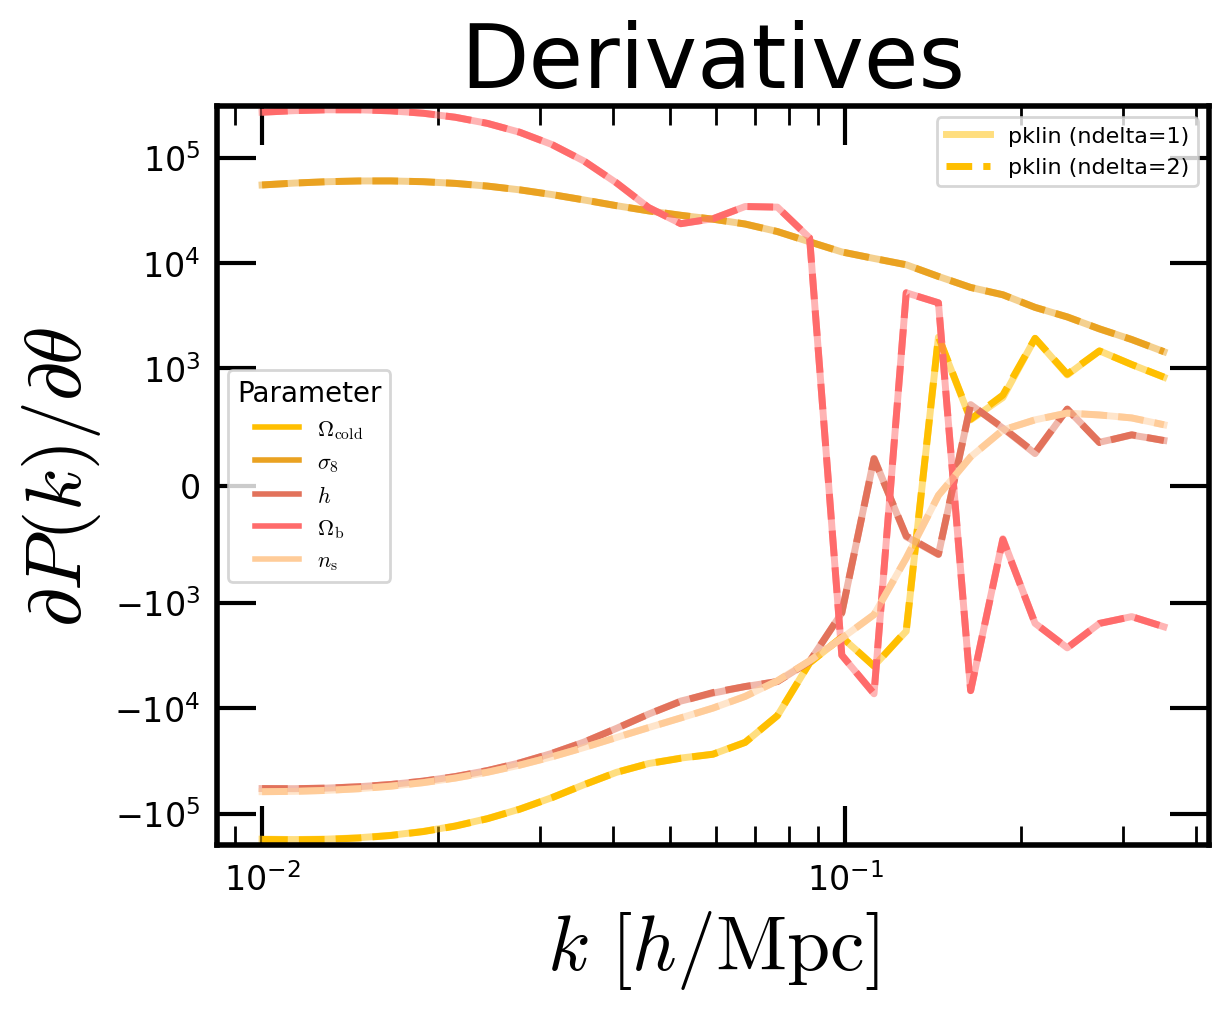

In [136]:
colors_params = ["#FFBF00", "#EAA221", "#E2725B", "#FF6B6B", "#FFCC99", "#9CAF88", "#008080", "#4682B4", "#CCCCFF"]

param_names_show = utils.cosmo_param_names_ordered
for i, param_name in enumerate(param_names_show):
#for i, param_name in enumerate(param_names):
    if i==0:
        label_pklin1 = 'pklin (ndelta=1)'
        label_pklin2 = 'pklin (ndelta=2)'
    else:
        label_pklin1 = None
        label_pklin2 = None

    plt.plot(k, derivatives_pklin_nd1[param_name], label=label_pklin1, color=colors_params[i], alpha=0.5)
    plt.plot(k, derivatives_pklin_nd2[param_name], label=label_pklin2, color=colors_params[i], alpha=1, ls='--')

# First legend: dataset types
legend1 = plt.legend(fontsize=8, loc='best')
plt.gca().add_artist(legend1)

# Second legend: parameter colors
from matplotlib.lines import Line2D
param_legend_handles = [Line2D([0], [0], color=colors_params[i], lw=2, label=utils.param_label_dict[param_names_show[i]]) for i in range(len(param_names_show))]
plt.legend(handles=param_legend_handles, title='Parameter', loc='best', fontsize=8)

plt.title(f'Derivatives')
plt.xlabel(r'$k\ [h/\mathrm{Mpc}]$')
plt.ylabel(r'$\partial P(k) / \partial \theta$')
plt.xscale('log')
plt.yscale('symlog', linthresh=1e3)

In [137]:
fisher_matrix_pklin_nd1 = utils.compute_fisher_matrix(derivatives_pklin_nd1, cov_fid_pklin, utils.cosmo_param_names_ordered)
cov_fisher_pklin_nd1 = np.linalg.inv(fisher_matrix_pklin_nd1)
print("Fisher matrix shape:", fisher_matrix_pklin_nd1.shape)

Fisher matrix shape: (5, 5)


In [138]:
n_samples = 10000
samples_pklin_nd1 = np.random.multivariate_normal(theta_fid[:len(utils.cosmo_param_names_ordered)], cov_fisher_pklin_nd1, size=n_samples)

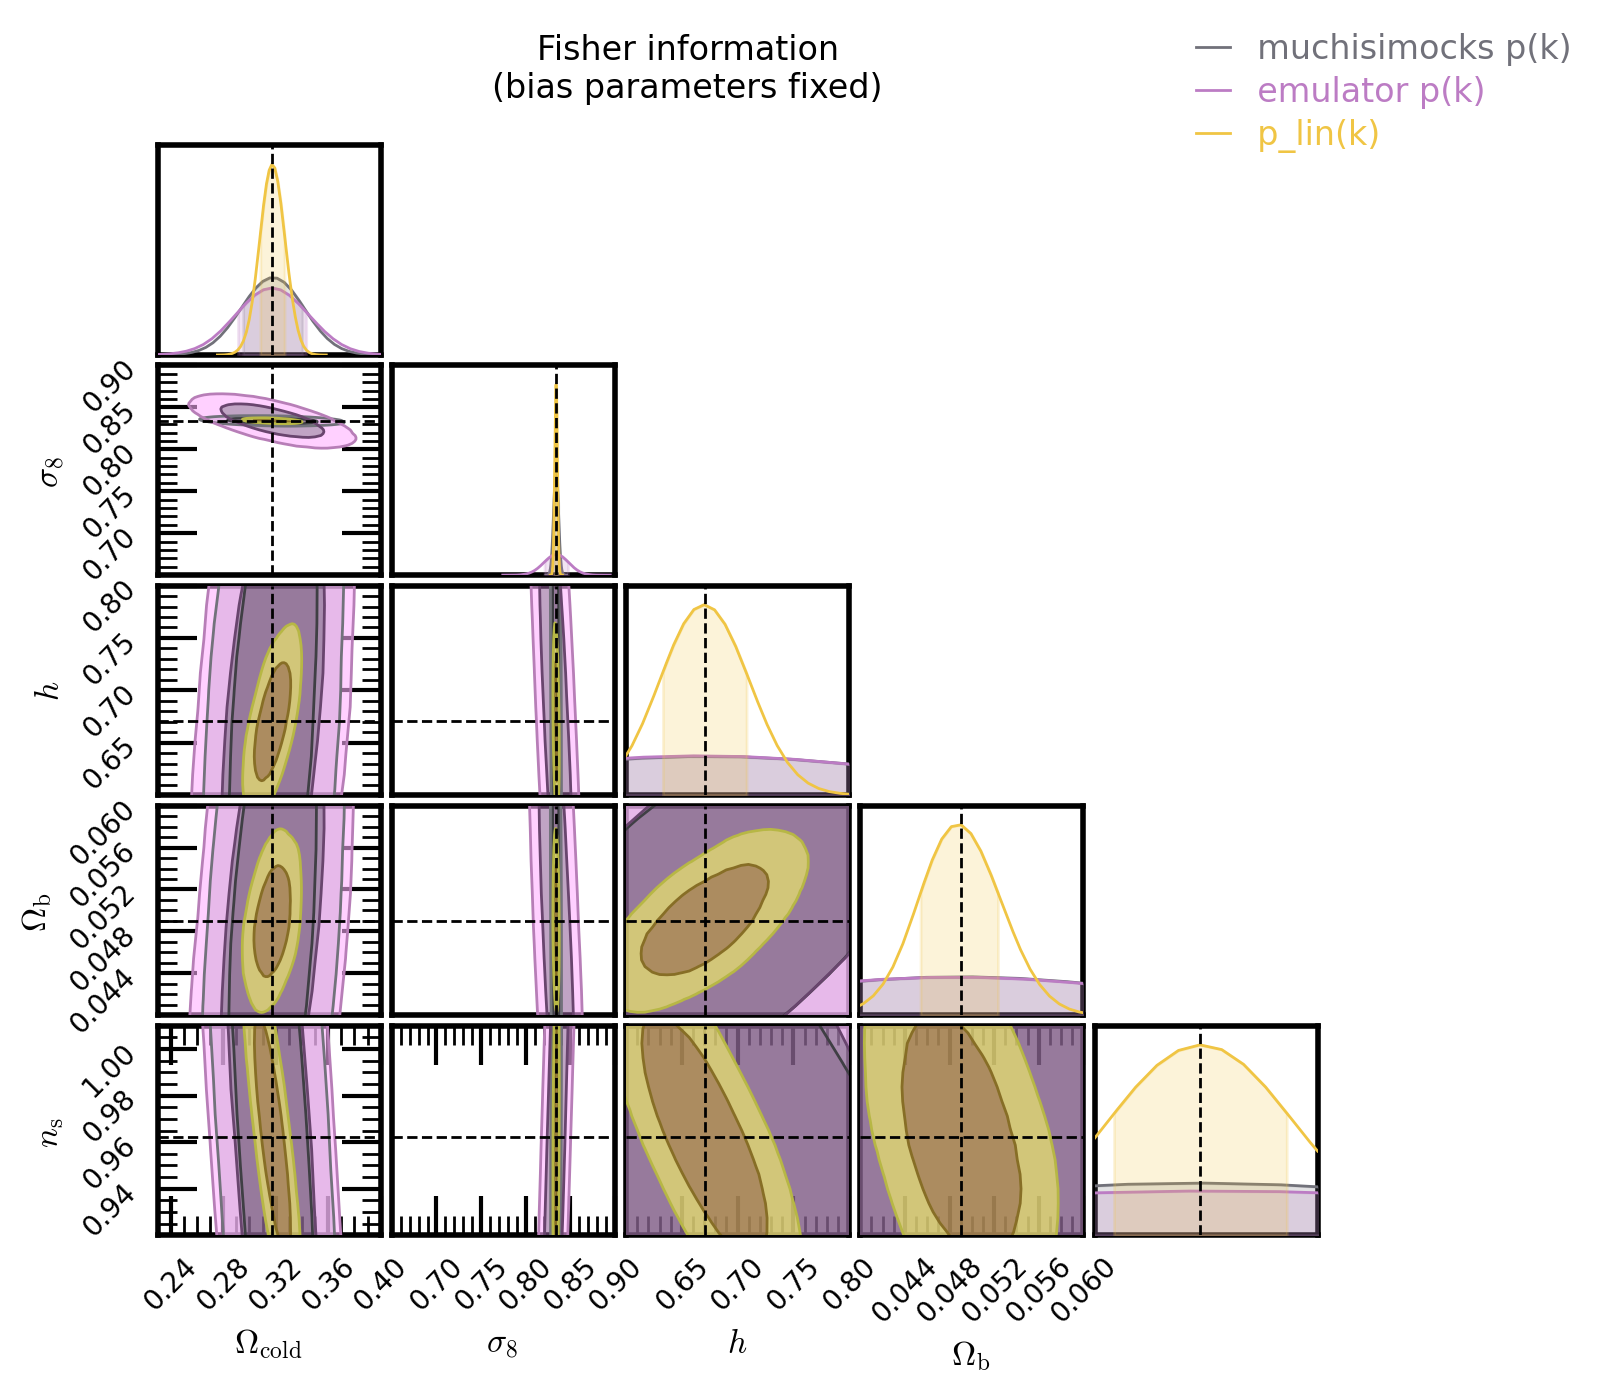

In [139]:

samples_arr = [samples_shift_nd1,
               samples_shift_emu_nd1_cosmo, 
               samples_pklin_nd1,
               #samples_shift_bispec_nd1,
               #samples_shift_biaszen_nd2
               ]
labels = ['muchisimocks p(k)',
          'emulator p(k)', 
          'p_lin(k)'
        ]
color_emu = '#bc7cc4'
color_pklin = "#F0C544"
colors = ['gray', color_emu, color_pklin]
smooth_arr = [2]*len(samples_arr)
bins_arr = [10]*len(samples_arr)
title = 'Fisher information\n(bias parameters fixed)'
plotter.plot_contours(samples_arr, labels, colors, utils.cosmo_param_names_ordered, 
                      utils.param_label_dict, 
                  smooth_arr=smooth_arr, bins_arr=bins_arr,
                  truth_loc=params_dict_cv_emu, title=title, extents=extents, 
                  figsize=(7,7), fn_save=None,
                  )

## Scale dependence

In [140]:
#k_max_arr = [0.03, 0.06, 0.1, 0.2, 0.3, 0.4]
k_max_arr = [0.05, 0.1, 0.2, 0.3, 0.4]

fisher_info_dict = {
    'muchisimocks_pk': {
        'derivatives': derivatives_shift_biaszen_nd1,
        'cov': cov_fid,
        'k': k_biaszen
    },
    'emulator_pk': {
        'derivatives': derivatives_shift_emu_nd1,
        'cov': cov_fid_emu,
        'k': k
    },
    # 'muchisimocks_bispec': {
    #     'derivatives': derivatives_shift_biaszen_bispec_nd1,
    #     'cov': cov_fid_bispec,
    #     'k': k_cv_bispec
    # },
    'pklin': {
        'derivatives': derivatives_pklin_nd1,
        'cov': cov_fid_pklin,
        'k': k_biaszen
    }
}

param_names_plot = utils.cosmo_param_names_ordered

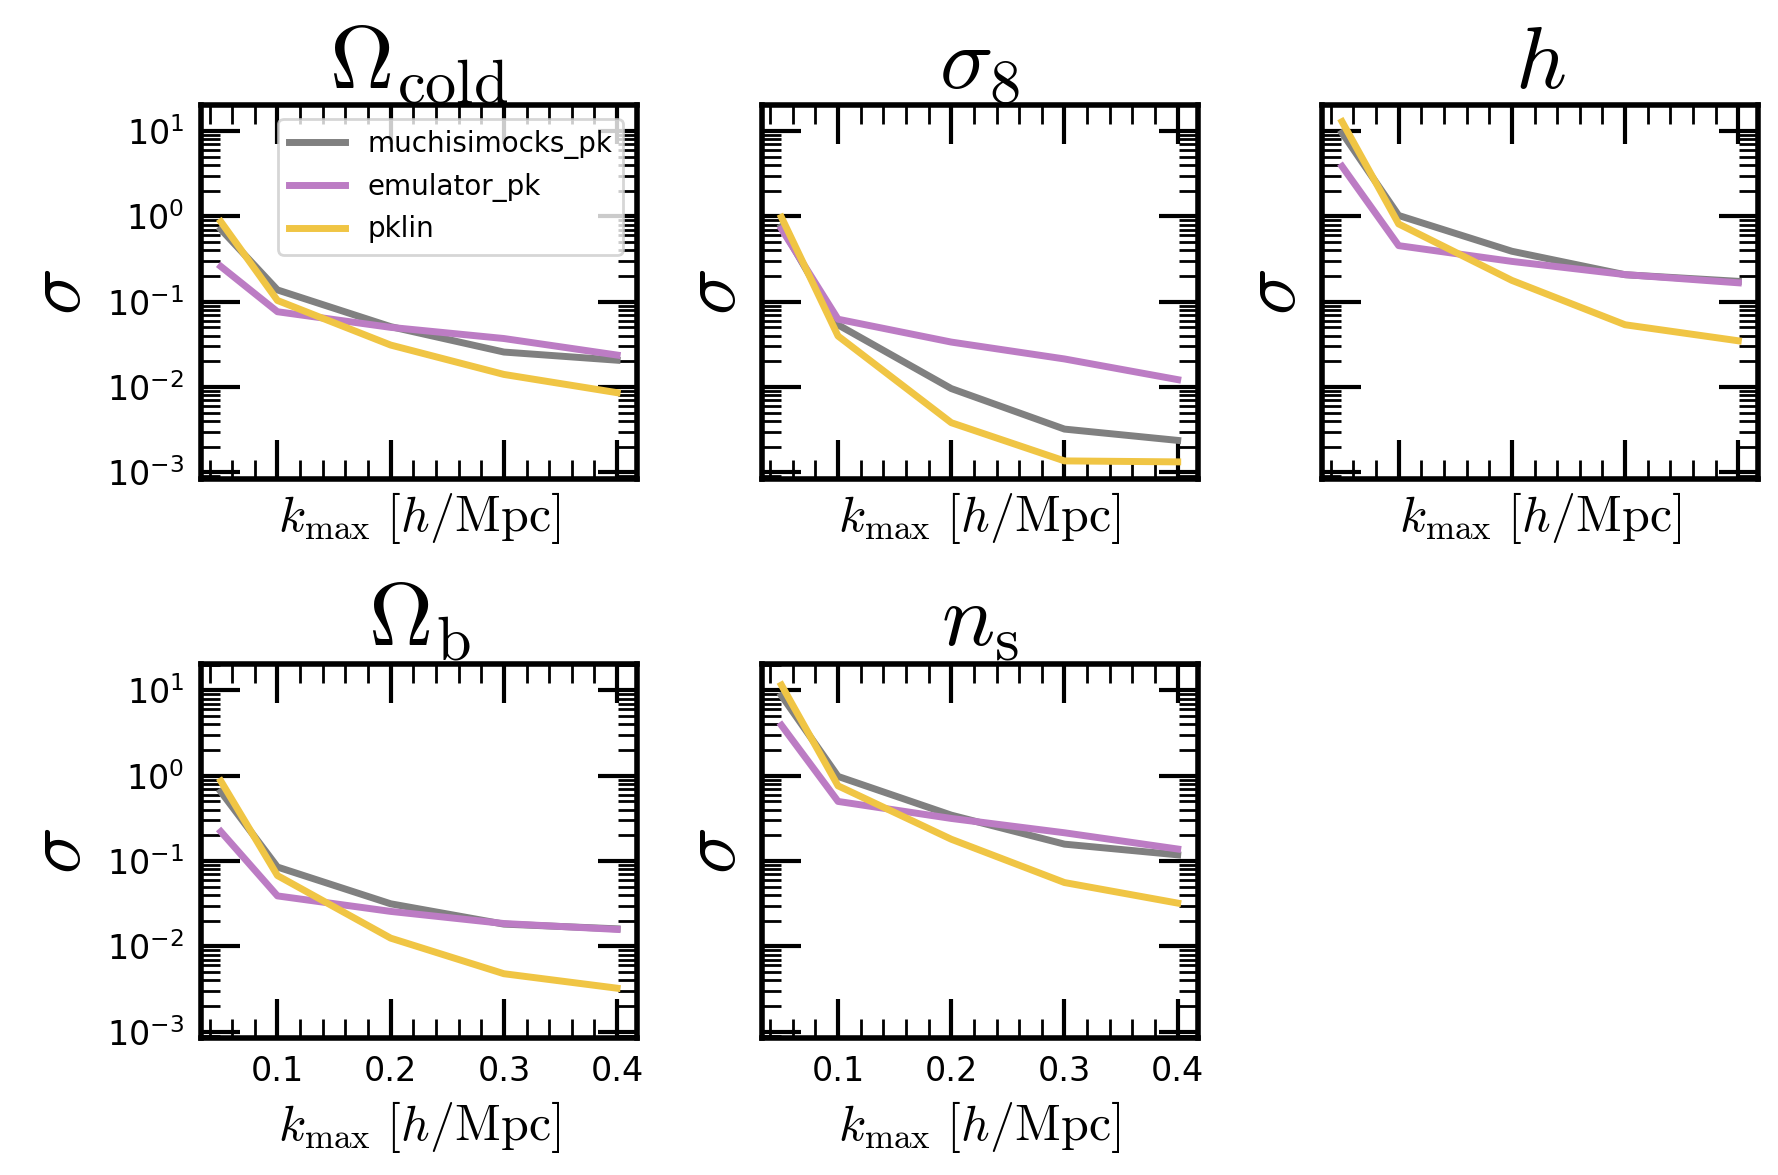

In [141]:
import matplotlib.pyplot as plt

n_rows, n_cols = 2, 3
param_names_plot = utils.cosmo_param_names_ordered
n_params = len(param_names_plot)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*3), sharex=True, sharey=True)

for i, param_name in enumerate(param_names_plot):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]
    ax.set_title(f'{utils.param_label_dict[param_name]}')
    ax.set_xlabel(r'$k_{\rm max}\ [h/\mathrm{Mpc}]$', size=18)
    ax.set_ylabel(r'$\sigma$')
    #ax.set_xscale('log')
    ax.set_yscale('log')
    for j, fisher_name in enumerate(fisher_info_dict.keys()):
        fisher_info = fisher_info_dict[fisher_name]
        sigma_arr = []
        for k_max in k_max_arr:
            derivatives_kcut, cov_fid_kcut, k_kcut = cut_scales_from_derivs_and_cov(
                fisher_info['derivatives'], fisher_info['cov'], fisher_info['k'], k_max)
            fisher_matrix_kcut = utils.compute_fisher_matrix(derivatives_kcut, cov_fid_kcut, param_names_plot)
            cov_fisher_kcut = np.linalg.inv(fisher_matrix_kcut)
            sigma_arr.append(np.sqrt(cov_fisher_kcut[i, i]))
        ax.plot(k_max_arr, sigma_arr, color=colors[j], label=fisher_name)
    if i == 0:
        ax.legend(fontsize=10)

# Hide any unused subplots
for j in range(n_params, n_rows * n_cols):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()

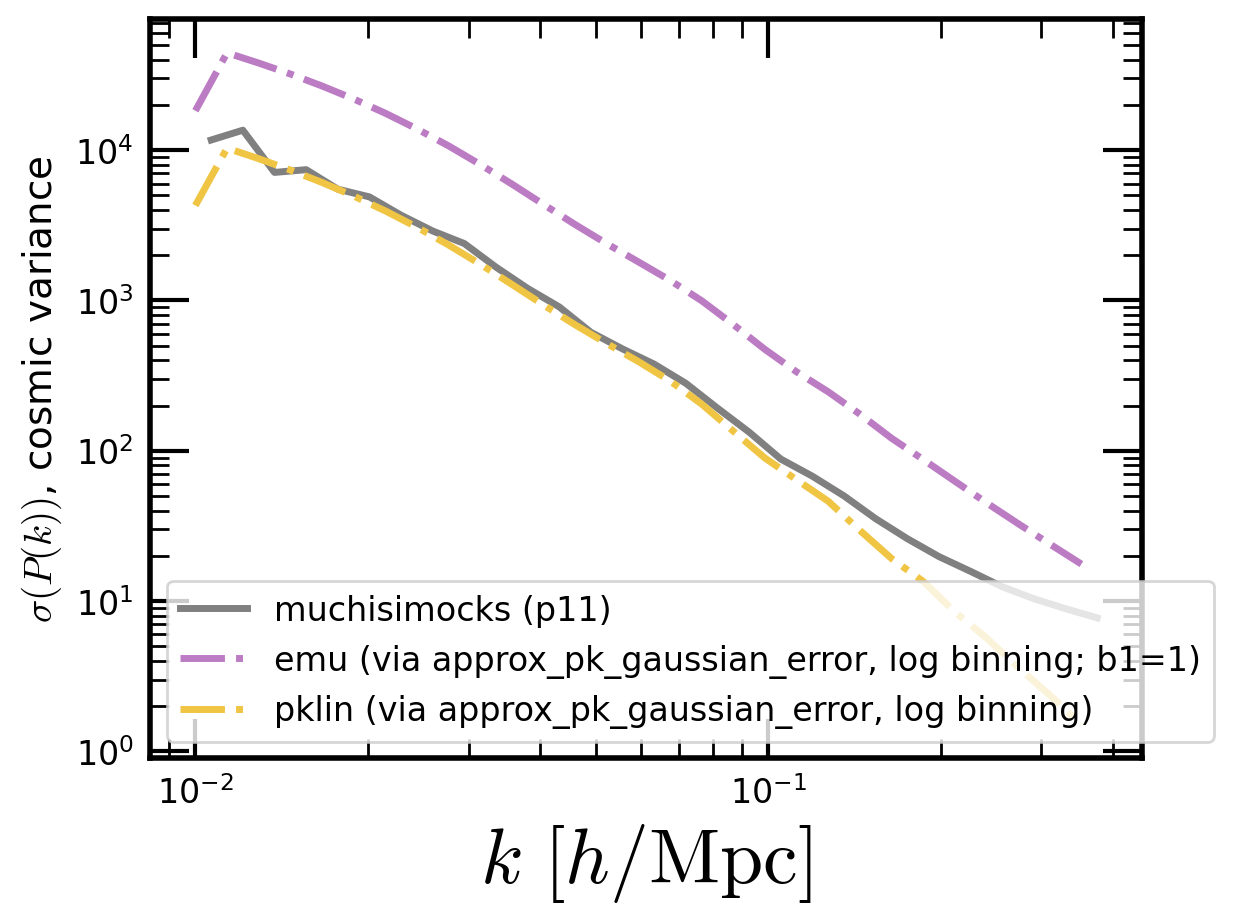

In [147]:
plt.plot(k_biaszen, np.sqrt(np.diag(cov_fid_b0000)), color='grey', label='muchisimocks (p11)')
plt.plot(k, np.sqrt(np.diag(cov_fid_emu_approx)), color=color_emu, label='emu (via approx_pk_gaussian_error, log binning; b1=1)', ls='-.', lw=2.5)
plt.plot(k, np.sqrt(np.diag(cov_fid_pklin)), color=color_pklin, label='pklin (via approx_pk_gaussian_error, log binning)', ls='-.', lw=2.5)


plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k\ [h/\mathrm{Mpc}]$')
plt.ylabel(r'$\sigma(P(k))$, cosmic variance', fontsize=14)
plt.legend(fontsize=12)